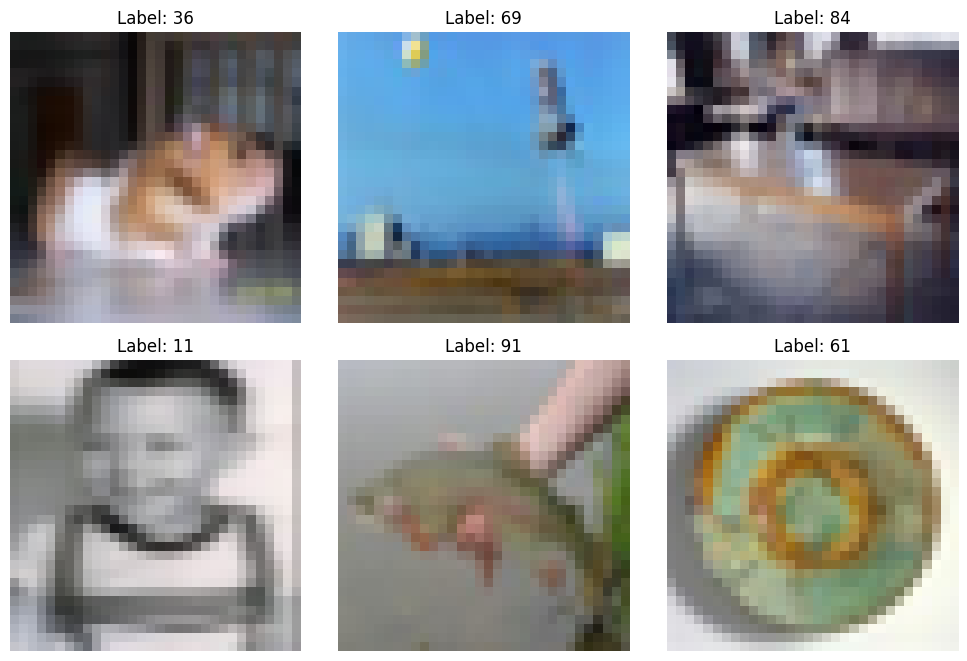

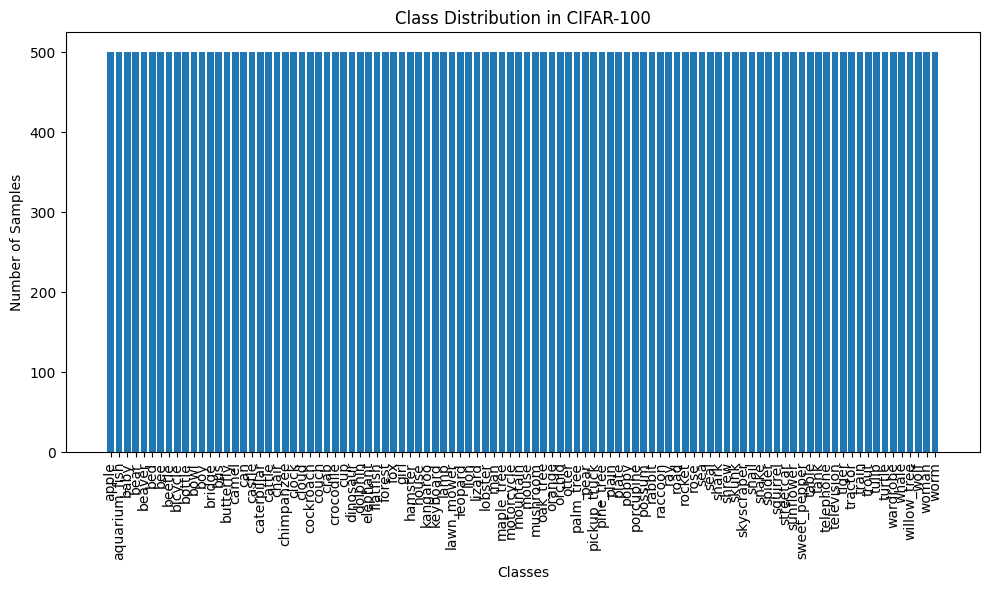

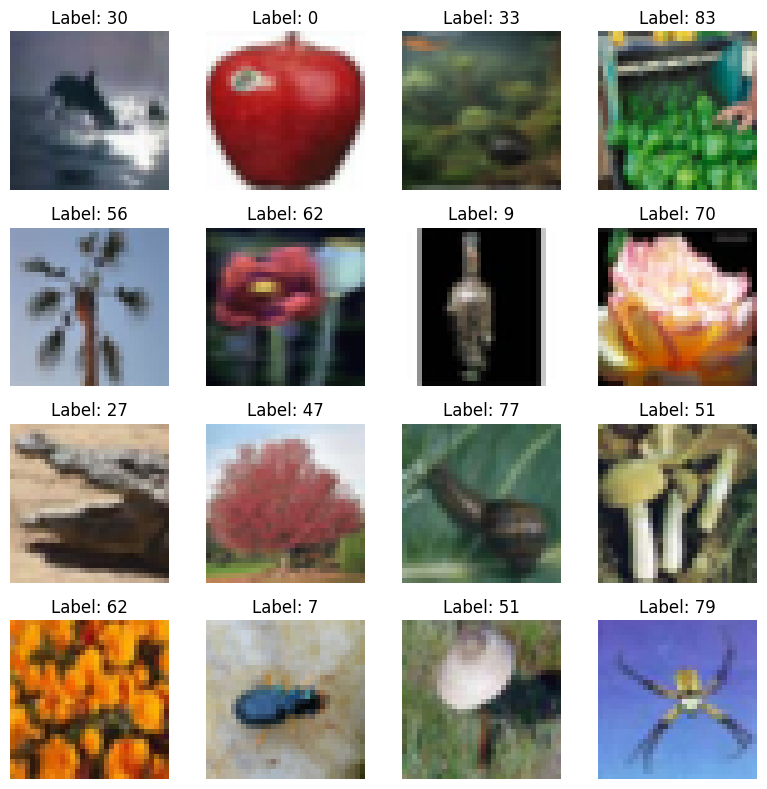

In [11]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

# CIFAR-100 dataset loading (with transformation to tensor)
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# 1. Display Random Images from CIFAR-100
def show_random_images(dataset, num_images=6):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)  # Convert CHW to HWC format for plt.imshow
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_random_images(trainset)

# 2. Plot Class Distribution of CIFAR-100
def plot_class_distribution(dataset):
    labels = [label for _, label in dataset]
    unique, counts = np.unique(labels, return_counts=True)
    class_names = torchvision.datasets.CIFAR100(root='./data', train=True).classes

    plt.figure(figsize=(10, 6))
    plt.bar(unique, counts, tick_label=[class_names[i] for i in unique])
    plt.title('Class Distribution in CIFAR-100')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_class_distribution(trainset)

# 3. Display Image Grid (4x4 grid of CIFAR-100 Images)
def show_image_grid(dataset, num_images=16):
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)  
        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_image_grid(trainset)



In [47]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import weightwatcher as ww
from torch.optim.lr_scheduler import OneCycleLR

# =============================================================================
# Helper: Cutout Transform
class Cutout(object):
    def __init__(self, n_holes=1, length=8):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.shape[1], img.shape[2]
        mask = np.ones((h, w), np.float32)
        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1:y2, x1:x2] = 0.
        mask = torch.from_numpy(mask).float()
        mask = mask.expand_as(img)
        return img * mask

# =============================================================================
# Directories
os.makedirs('plots', exist_ok=True)
os.makedirs('histograms', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

# =============================================================================
# Data Transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=10),
    transforms.ToTensor(),
    Cutout(n_holes=1, length=8),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# =============================================================================
# ResNet-18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, 1, stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return torch.relu(out)

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], 1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], 2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], 2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return self.linear(out)

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# =============================================================================
# Mixup

def mixup_data(x, y, alpha=0.1):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    index = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    return mixed_x, y, y[index], lam

def mixup_criterion(criterion, preds, y_a, y_b, lam):
    return lam * criterion(preds, y_a) + (1 - lam) * criterion(preds, y_b)

# =============================================================================
# WeightWatcher Analysis
def run_weightwatcher_analysis(model, epoch):
    print(f"[WW] Running WeightWatcher analysis at epoch {epoch}...")
    base_dir = f"plots/ww/epoch_{epoch}"
    os.makedirs(base_dir, exist_ok=True)
    esd_dir = os.path.join(base_dir, "esd_log")
    os.makedirs(esd_dir, exist_ok=True)

    watcher = ww.WeightWatcher(model=model)
    details_df = watcher.analyze()
    details_df.to_csv(os.path.join(base_dir, "details.csv"), index=False)

    alpha_columns = ['layer_id', 'alpha', 'alpha_weighted', 'log_norm', 'log_alpha_norm']
    if 'layer_name' in details_df.columns:
        alpha_columns.insert(1, 'layer_name')

    alpha_df = details_df[alpha_columns].copy() if alpha_columns else None
    if alpha_df is not None:
        alpha_df['epoch'] = epoch
        alpha_df.to_csv(os.path.join(base_dir, "alphas.csv"), index=False)

    # Plot ESD (singular value distribution) in log-log scale
    for idx, row in details_df.iterrows():
        layer_name = row.get('layer_name', f'layer_{idx}')
        sv = row.get('sv', None)

        if isinstance(sv, np.ndarray) and len(sv) > 0:
            try:
                plt.figure()
                log_sv = np.log10(np.clip(sv, a_min=1e-10, a_max=None))
                plt.hist(log_sv, bins=50, density=True)
                plt.title(f"Log ESD: {layer_name}")
                plt.xlabel("log₁₀(Singular Values)")
                plt.ylabel("Density")
                plt.grid(True)
                safe_name = layer_name.replace('/', '_').replace('.', '_')
                plt.savefig(os.path.join(esd_dir, f"{safe_name}_log_esd.png"))
                plt.close()
            except Exception as e:
                print(f"[WW] Skipping ESD plot for {layer_name}: {e}")

    return alpha_df if alpha_columns else None


# =============================================================================
# Logging Functions

def plot_esd(epoch, model):
    os.makedirs('plots/esd', exist_ok=True)
    for name, param in model.named_parameters():
        if 'weight' in name and param.ndim >= 2:
            try:
                W = param.detach().cpu().numpy().reshape(param.size(0), -1)
                s = np.linalg.svd(W, compute_uv=False)
                plt.hist(s, bins=50, density=True)
                plt.title(f'ESD: {name} @ Epoch {epoch}')
                plt.savefig(f'plots/esd/{name.replace(".", "_")}_epoch{epoch}.png')
                plt.close()
            except Exception as e:
                print(f"[ESD ERROR] {name}: {e}")

def plot_param_histograms(epoch, model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            plt.hist(param.detach().cpu().numpy().flatten(), bins=50, density=True)
            plt.title(f'{name} Histogram @ Epoch {epoch}')
            subdir = 'weights' if 'weight' in name else 'biases'
            os.makedirs(f'plots/{subdir}', exist_ok=True)
            plt.savefig(f'plots/{subdir}/{name.replace(".", "_")}_epoch{epoch}.png')
            plt.close()

def plot_layer_norms(epoch, model):
    norms = {name: torch.norm(p).item() for name, p in model.named_parameters() if p.requires_grad}
    plt.barh(list(norms.keys()), list(norms.values()))
    plt.title(f'Layer Norms @ Epoch {epoch}')
    os.makedirs('plots/norms', exist_ok=True)
    plt.savefig(f'plots/norms/layer_norms_epoch{epoch}.png')
    plt.close()

def plot_alpha_history(alphas):
    os.makedirs('plots/alpha', exist_ok=True)
    plt.plot(range(1, len(alphas) + 1), alphas, marker='o')
    plt.title("Mixup Alpha per Epoch")
    plt.savefig("plots/alpha/mixup_alpha.png")
    plt.close()

def save_checkpoint(model, optimizer, scheduler, epoch, train_loss, train_acc, test_loss, test_acc, alpha):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'train_accuracy': train_acc,
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'alpha': alpha
    }, f'checkpoints/epoch_{epoch}.pth')

# =============================================================================
# Training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
num_epochs = 49
scheduler = OneCycleLR(optimizer, max_lr=0.2, steps_per_epoch=len(trainloader), epochs=num_epochs, pct_start=0.3)

def evaluate(model, dataloader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss_sum += criterion(outputs, targets).item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return loss_sum / total, 100.0 * correct / total

train_losses, test_losses = [], []
train_accs, test_accs, mixup_alphas = [], [], []
all_alpha_history = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=0.1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct_train += lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item()
        total_train += targets.size(0)

    train_loss = running_loss / total_train
    train_acc = 100. * correct_train / total_train
    test_loss, test_acc = evaluate(model, testloader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    mixup_alphas.append(lam)

    plot_esd(epoch, model)
    plot_param_histograms(epoch, model)
    plot_layer_norms(epoch, model)
    save_checkpoint(model, optimizer, scheduler, epoch, train_loss, train_acc, test_loss, test_acc, lam)

    alpha_df = run_weightwatcher_analysis(model, epoch)
    if alpha_df is not None:
        all_alpha_history.append(alpha_df)

    print(f"Epoch [{epoch}/{num_epochs}] Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

if all_alpha_history:
    combined_df = pd.concat(all_alpha_history, ignore_index=True)
    combined_df.to_csv("plots/ww/all_epochs_alphas.csv", index=False)

plot_alpha_history(mixup_alphas)

plt.figure()
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.legend(); plt.title('Accuracy over Epochs'); plt.savefig('plots/accuracy_curve.png'); plt.close()

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend(); plt.title('Loss over Epochs'); plt.savefig('plots/loss_curve.png'); plt.close()

[WW] Running WeightWatcher analysis at epoch 1...
Epoch [1/49] Train Acc: 7.26%, Test Acc: 15.71%
[WW] Running WeightWatcher analysis at epoch 2...
Epoch [2/49] Train Acc: 14.84%, Test Acc: 24.27%
[WW] Running WeightWatcher analysis at epoch 3...
Epoch [3/49] Train Acc: 21.82%, Test Acc: 31.43%
[WW] Running WeightWatcher analysis at epoch 4...
Epoch [4/49] Train Acc: 27.25%, Test Acc: 33.47%
[WW] Running WeightWatcher analysis at epoch 5...
Epoch [5/49] Train Acc: 31.94%, Test Acc: 34.71%
[WW] Running WeightWatcher analysis at epoch 6...
Epoch [6/49] Train Acc: 35.99%, Test Acc: 41.68%
[WW] Running WeightWatcher analysis at epoch 7...
Epoch [7/49] Train Acc: 38.05%, Test Acc: 43.88%
[WW] Running WeightWatcher analysis at epoch 8...
Epoch [8/49] Train Acc: 39.86%, Test Acc: 42.71%
[WW] Running WeightWatcher analysis at epoch 9...
Epoch [9/49] Train Acc: 41.66%, Test Acc: 46.19%
[WW] Running WeightWatcher analysis at epoch 10...
Epoch [10/49] Train Acc: 41.62%, Test Acc: 49.29%
[WW] Runn

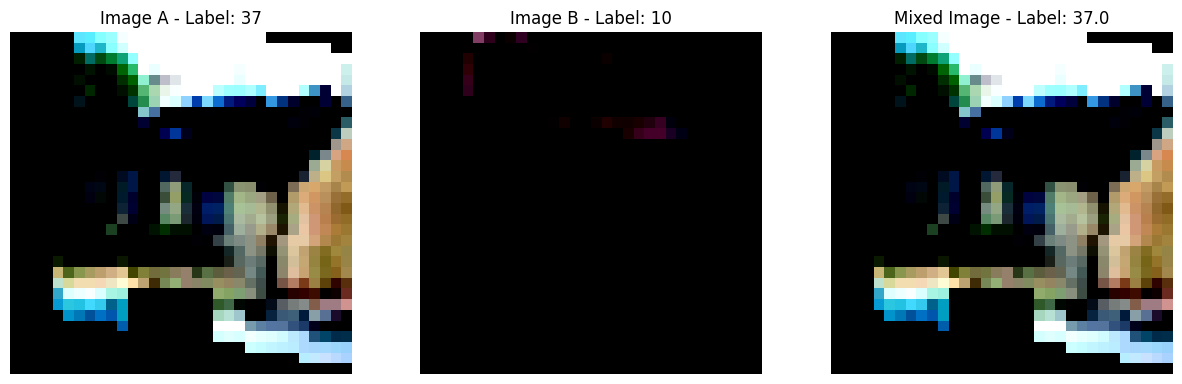

(tensor([[[-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957],
          [-1.8957, -1.8957, -1.8957,  ...,  1.7840, -1.8957, -1.8957],
          [-1.8957, -1.8957, -1.8957,  ...,  1.7840,  1.8280,  1.5787],
          ...,
          [-1.8957, -1.8957, -1.8957,  ...,  0.6405,  0.6112,  0.5965],
          [-1.8957, -1.8957, -1.8957,  ...,  0.7871,  0.7285,  0.6698],
          [-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957]],
 
         [[-1.8975, -1.8975, -1.8975,  ..., -1.8975, -1.8975, -1.8975],
          [-1.8975, -1.8975, -1.8975,  ...,  1.9094, -1.8975, -1.8975],
          [-1.8975, -1.8975, -1.8975,  ...,  1.9400,  1.9706,  1.7107],
          ...,
          [-1.8975, -1.8975, -1.8975,  ...,  0.8545,  0.8392,  0.8239],
          [-1.8975, -1.8975, -1.8975,  ...,  0.8851,  0.8545,  0.8239],
          [-1.8975, -1.8975, -1.8975,  ..., -1.8975, -1.8975, -1.8975]],
 
         [[-1.5965, -1.5965, -1.5965,  ..., -1.5965, -1.5965, -1.5965],
          [-1.5965, -1.5965,

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_mixup_image(x_a, x_b, y_a, y_b, alpha=0.2):
    # Generate lambda from the Beta distribution
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    
    # Mix the images
    mixed_x = lam * x_a + (1 - lam) * x_b
    
    # Create mixed label
    mixed_label = lam * y_a + (1 - lam) * y_b
    
    # Convert images to numpy arrays for visualization
    x_a_np = x_a.cpu().numpy().transpose((1, 2, 0))
    x_b_np = x_b.cpu().numpy().transpose((1, 2, 0))
    mixed_x_np = mixed_x.cpu().numpy().transpose((1, 2, 0))
    
    # Clip values to be in the valid image range [0, 1]
    x_a_np = np.clip(x_a_np, 0, 1)
    x_b_np = np.clip(x_b_np, 0, 1)
    mixed_x_np = np.clip(mixed_x_np, 0, 1)

    # Plot the images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(x_a_np)
    ax[0].set_title(f"Image A - Label: {y_a}")
    ax[0].axis('off')
    
    ax[1].imshow(x_b_np)
    ax[1].set_title(f"Image B - Label: {y_b}")
    ax[1].axis('off')
    
    ax[2].imshow(mixed_x_np)
    ax[2].set_title(f"Mixed Image - Label: {mixed_label}")
    ax[2].axis('off')
    
    plt.show()
    return mixed_x, mixed_label  # Return mixed image and label for further use

# Example usage with two CIFAR-100 images (assuming you have a batch of images and labels)
data_iter = iter(trainloader)  # Create an iterator over the DataLoader
images, labels = next(data_iter)  # Get the next batch from the iterator

# Pick two random images from the batch
x_a, x_b = images[0], images[1]
y_a, y_b = labels[0], labels[1]

# Visualize the mixup
visualize_mixup_image(x_a, x_b, y_a, y_b, alpha=0.2)


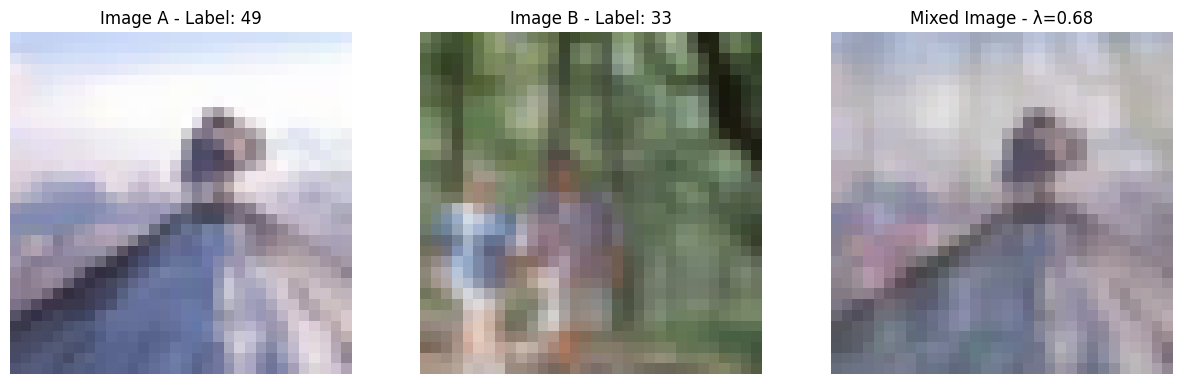

In [16]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# CIFAR-100 dataset (without any transformations)
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Convert images to tensor
    torchvision.transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # CIFAR-100 normalization
])

# Load CIFAR-100 dataset (no augmentation)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Function to denormalize the image for visualization
def denormalize(tensor, mean, std):
    return tensor * std[:, None, None] + mean[:, None, None]

# Mixup function to combine two images
def mixup_data(x_a, x_b, alpha=0.1):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0  # Random lambda from a Beta distribution
    index = torch.randperm(x_a.size(0)).to(x_a.device)  # Shuffle the indices
    mixed_x = lam * x_a + (1 - lam) * x_b[index]  # Mix the images
    return mixed_x, lam

# Visualize the original and mixup images
def visualize_images(x_a, x_b, y_a, y_b, mixed_x, lam):
    # CIFAR-100 mean and std for denormalization
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])

    # Denormalize images
    x_a_denorm = denormalize(x_a, mean, std).cpu().numpy().transpose((1, 2, 0))
    x_b_denorm = denormalize(x_b, mean, std).cpu().numpy().transpose((1, 2, 0))
    mixed_x_denorm = denormalize(mixed_x, mean, std).cpu().numpy().transpose((1, 2, 0))

    # Clip to make sure the values are within [0, 1]
    x_a_denorm = np.clip(x_a_denorm, 0, 1)
    x_b_denorm = np.clip(x_b_denorm, 0, 1)
    mixed_x_denorm = np.clip(mixed_x_denorm, 0, 1)

    # Plot the images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(x_a_denorm)
    ax[0].set_title(f"Image A - Label: {y_a}")
    ax[0].axis('off')
    
    ax[1].imshow(x_b_denorm)
    ax[1].set_title(f"Image B - Label: {y_b}")
    ax[1].axis('off')
    
    ax[2].imshow(mixed_x_denorm)
    ax[2].set_title(f"Mixed Image - λ={lam:.2f}")
    ax[2].axis('off')
    
    plt.show()

# Example usage with two CIFAR-100 images (pure images without augmentation)
data_iter = iter(testloader)  # Create an iterator over the DataLoader
images, labels = next(data_iter)  # Get the next batch from the iterator

# Pick two random images from the batch
x_a, x_b = images[0], images[1]
y_a, y_b = labels[0].item(), labels[1].item()  # Labels as integers

# Apply Mixup
mixed_x, lam = mixup_data(x_a, x_b, alpha=0.1)

# Visualize the pure CIFAR-100 images and the mixed-up image
visualize_images(x_a, x_b, y_a, y_b, mixed_x, lam)


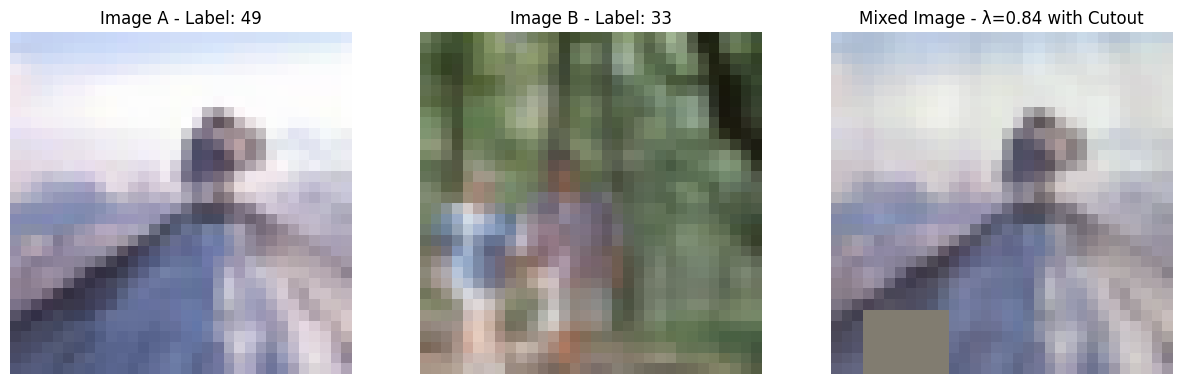

In [17]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# CIFAR-100 dataset (without any transformations)
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Convert images to tensor
    torchvision.transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # CIFAR-100 normalization
])

# Load CIFAR-100 dataset (no augmentation)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Function to denormalize the image for visualization
def denormalize(tensor, mean, std):
    return tensor * std[:, None, None] + mean[:, None, None]

# Cutout transform definition
class Cutout(object):
    def __init__(self, n_holes=1, length=8):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.shape[1], img.shape[2]
        mask = np.ones((h, w), np.float32)
        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1:y2, x1:x2] = 0.
        mask = torch.from_numpy(mask).float()
        mask = mask.expand_as(img)
        return img * mask

# Mixup function to combine two images and apply cutout to the mixed image
def mixup_data_with_cutout(x_a, x_b, alpha=0.1, cutout_transform=None):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0  # Random lambda from a Beta distribution
    index = torch.randperm(x_a.size(0)).to(x_a.device)  # Shuffle the indices
    mixed_x = lam * x_a + (1 - lam) * x_b[index]  # Mix the images
    
    if cutout_transform:
        mixed_x = cutout_transform(mixed_x)  # Apply Cutout after Mixup
    
    return mixed_x, lam

# Visualize the original and mixup images with Cutout applied
def visualize_images(x_a, x_b, y_a, y_b, mixed_x, lam):
    # CIFAR-100 mean and std for denormalization
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])

    # Denormalize images
    x_a_denorm = denormalize(x_a, mean, std).cpu().numpy().transpose((1, 2, 0))
    x_b_denorm = denormalize(x_b, mean, std).cpu().numpy().transpose((1, 2, 0))
    mixed_x_denorm = denormalize(mixed_x, mean, std).cpu().numpy().transpose((1, 2, 0))

    # Clip to make sure the values are within [0, 1]
    x_a_denorm = np.clip(x_a_denorm, 0, 1)
    x_b_denorm = np.clip(x_b_denorm, 0, 1)
    mixed_x_denorm = np.clip(mixed_x_denorm, 0, 1)

    # Plot the images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(x_a_denorm)
    ax[0].set_title(f"Image A - Label: {y_a}")
    ax[0].axis('off')
    
    ax[1].imshow(x_b_denorm)
    ax[1].set_title(f"Image B - Label: {y_b}")
    ax[1].axis('off')
    
    ax[2].imshow(mixed_x_denorm)
    ax[2].set_title(f"Mixed Image - λ={lam:.2f} with Cutout")
    ax[2].axis('off')
    
    plt.show()

# Example usage with two CIFAR-100 images (pure images without augmentation)
data_iter = iter(testloader)  # Create an iterator over the DataLoader
images, labels = next(data_iter)  # Get the next batch from the iterator

# Pick two random images from the batch
x_a, x_b = images[0], images[1]
y_a, y_b = labels[0].item(), labels[1].item()  # Labels as integers

# Create an instance of the Cutout transform
cutout_transform = Cutout(n_holes=1, length=8)

# Apply Mixup and Cutout to the images
mixed_x, lam = mixup_data_with_cutout(x_a, x_b, alpha=0.1, cutout_transform=cutout_transform)

# Visualize the pure CIFAR-100 images and the mixed-up image with Cutout
visualize_images(x_a, x_b, y_a, y_b, mixed_x, lam)


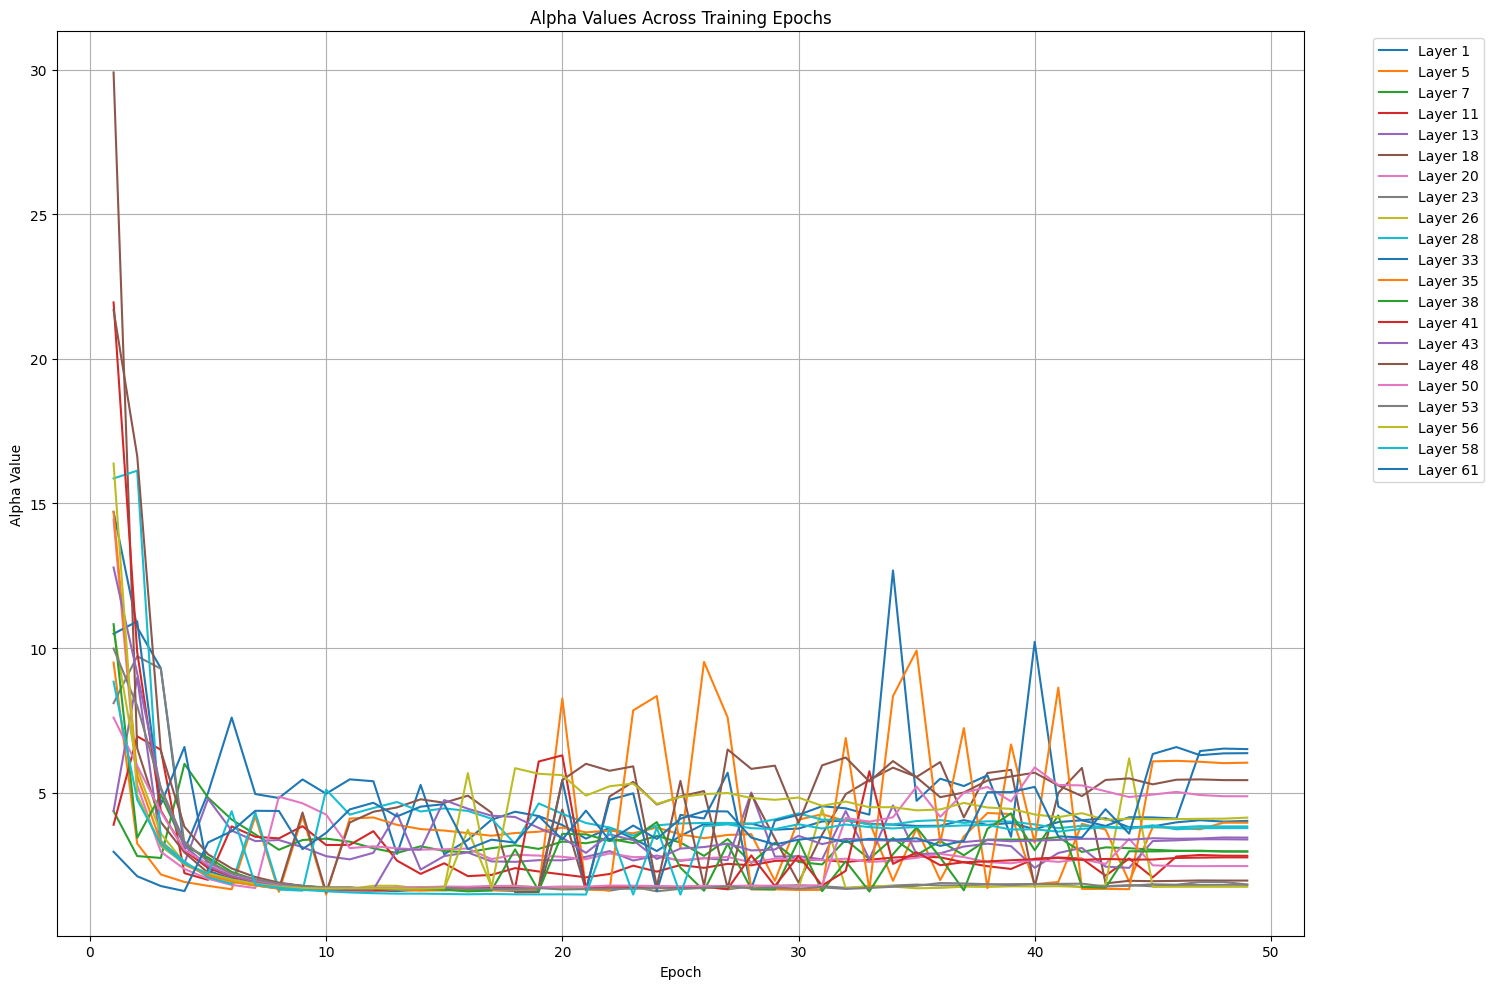

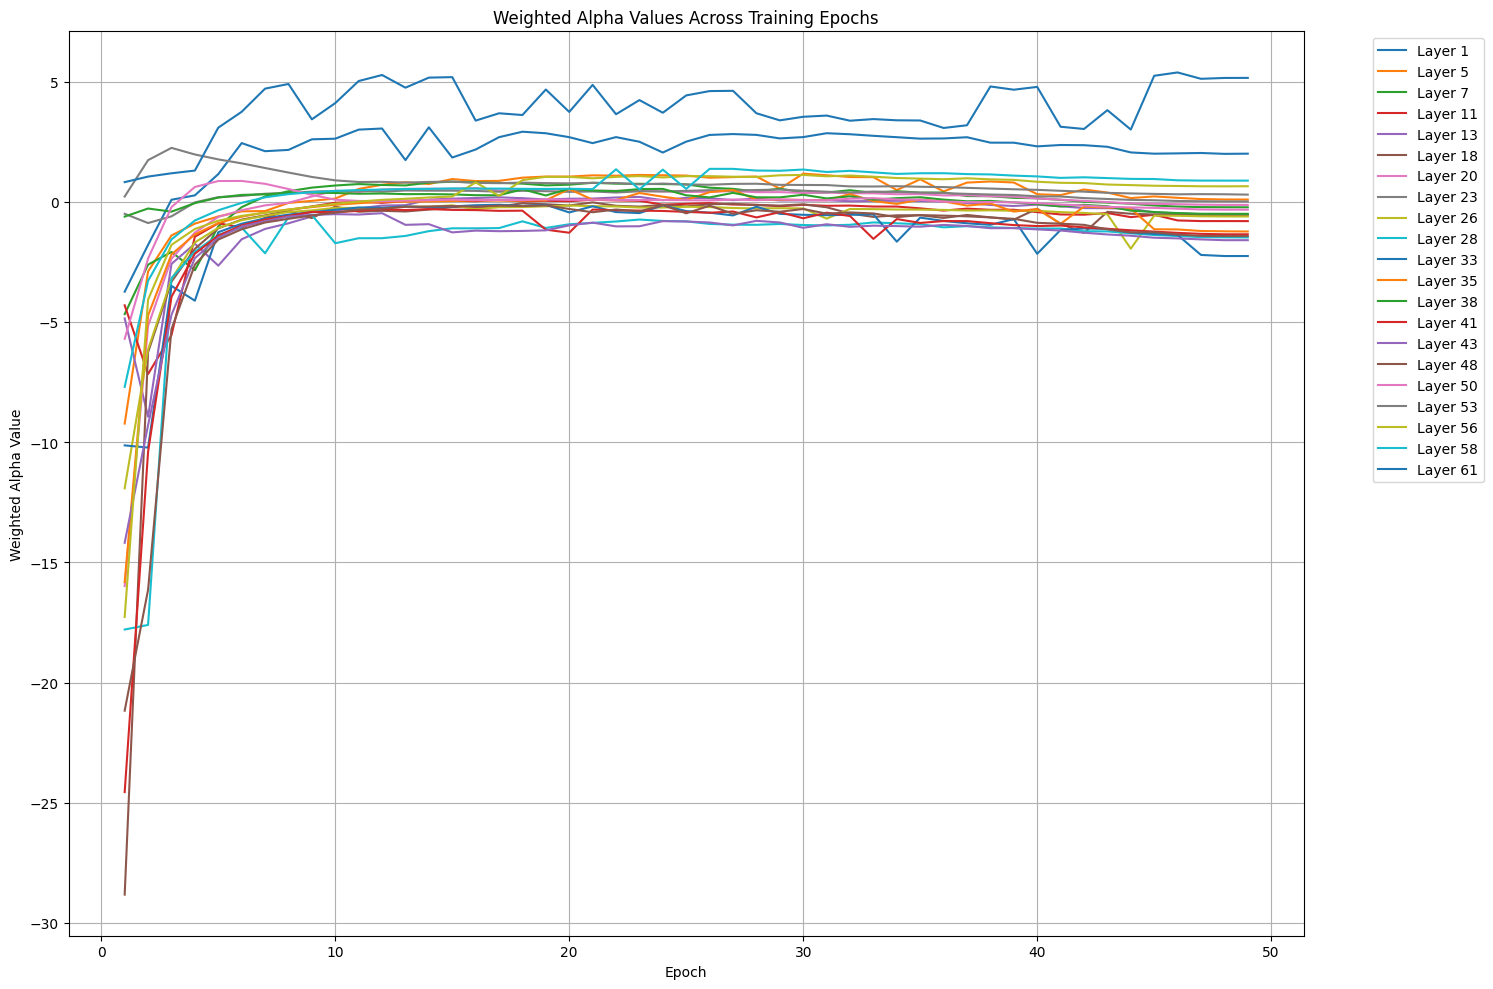

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('/home/amar/Desktop/DeepFake1M/plots/ww/all_epochs_alphas.csv')

# Create a figure with subplots
plt.figure(figsize=(15, 10))

# Get unique layer_ids
unique_layers = df['layer_id'].unique()

# Plot alpha values for each layer across epochs
for layer in unique_layers:
    layer_data = df[df['layer_id'] == layer]
    plt.plot(layer_data['epoch'], layer_data['alpha'], label=f'Layer {layer}')

plt.title('Alpha Values Across Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Alpha Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a similar plot for alpha_weighted
plt.figure(figsize=(15, 10))
for layer in unique_layers:
    layer_data = df[df['layer_id'] == layer]
    plt.plot(layer_data['epoch'], layer_data['alpha_weighted'], label=f'Layer {layer}')

plt.title('Weighted Alpha Values Across Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Weighted Alpha Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

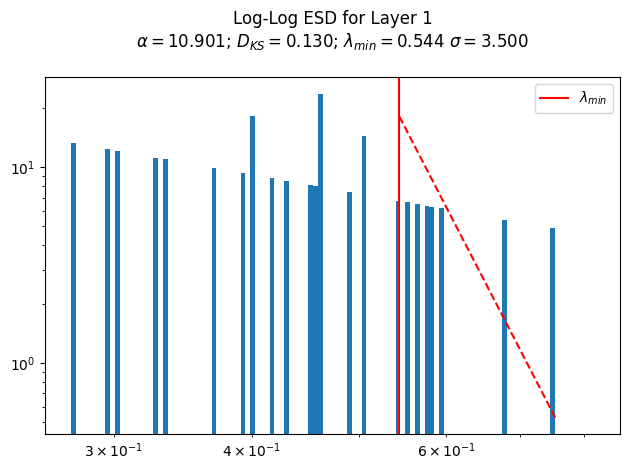

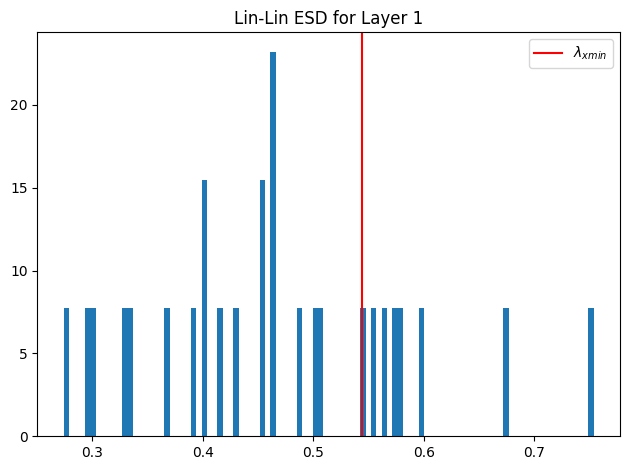

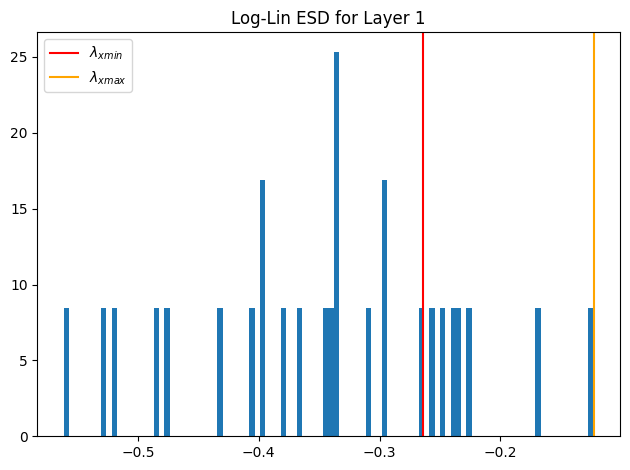

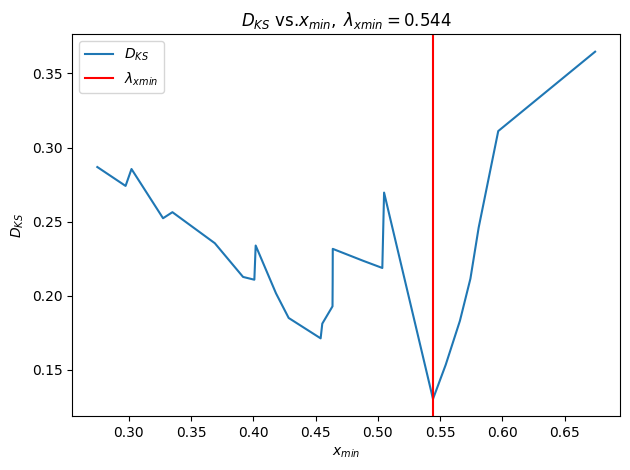

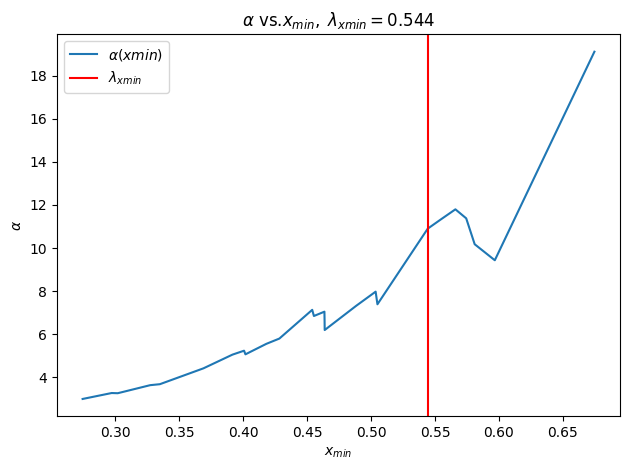

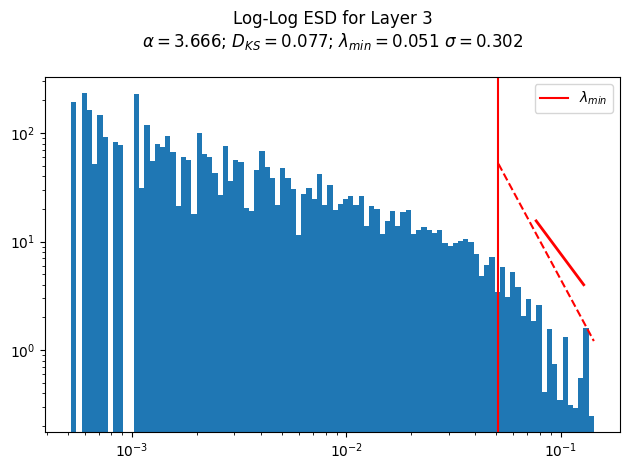

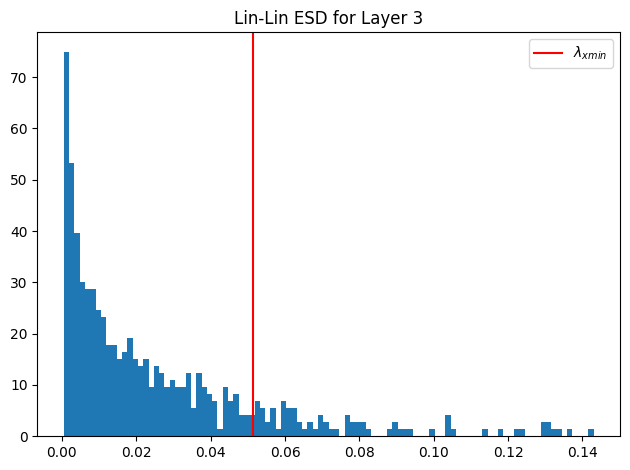

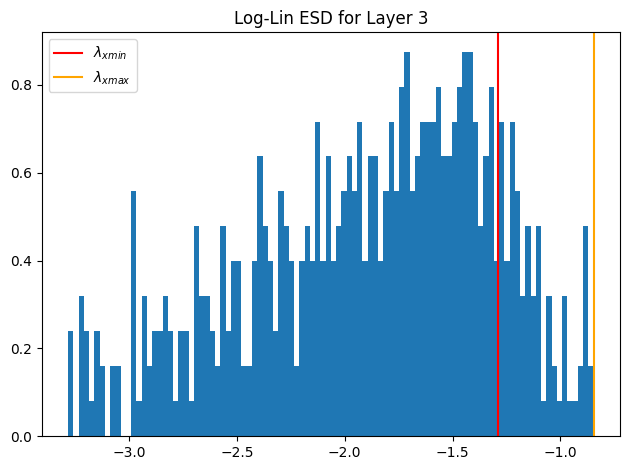

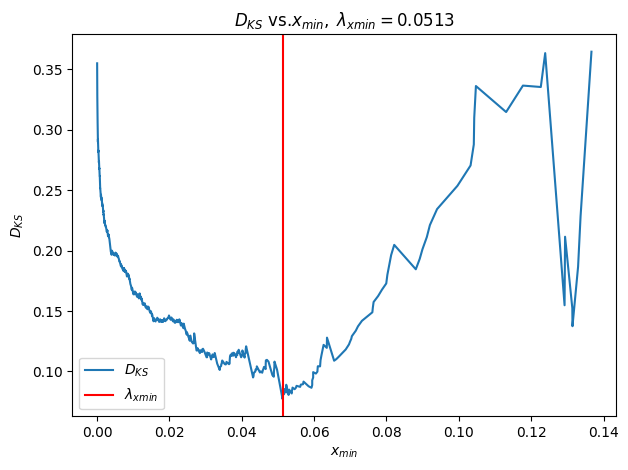

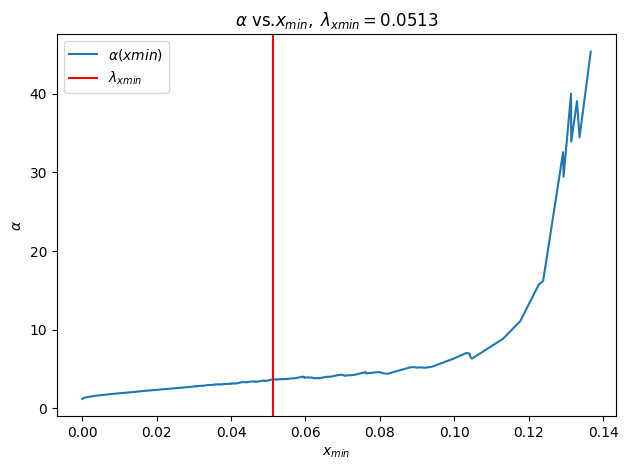

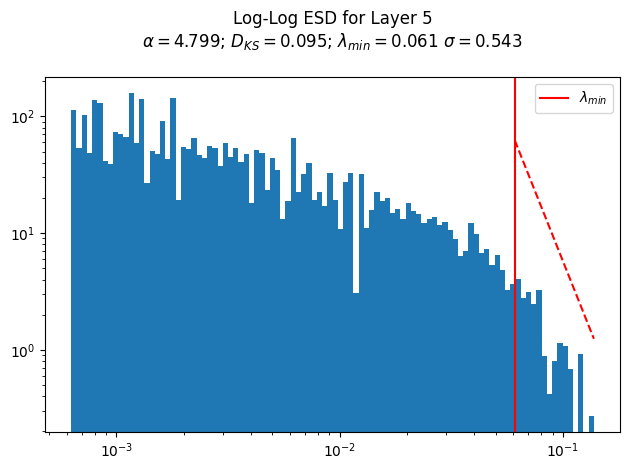

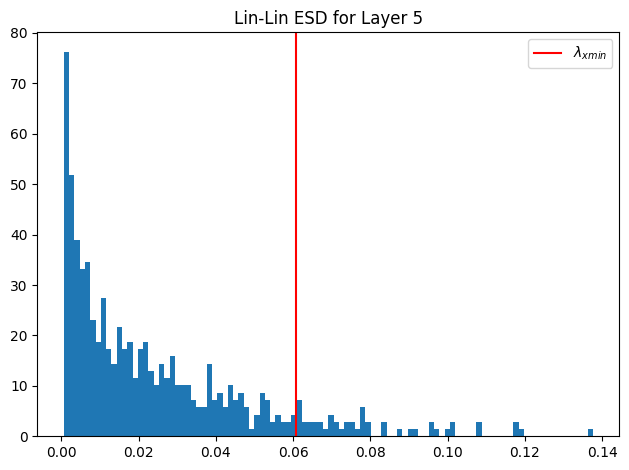

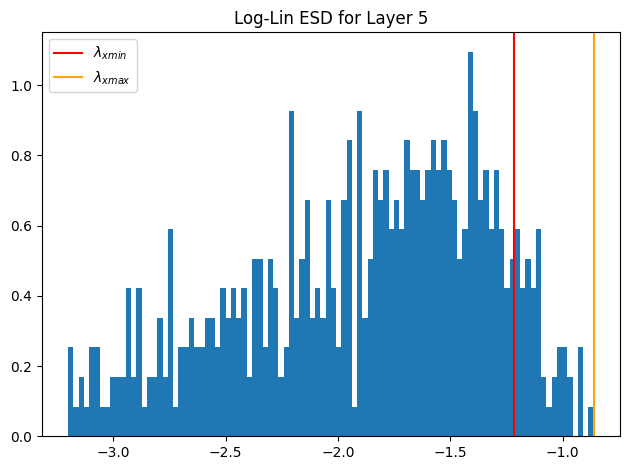

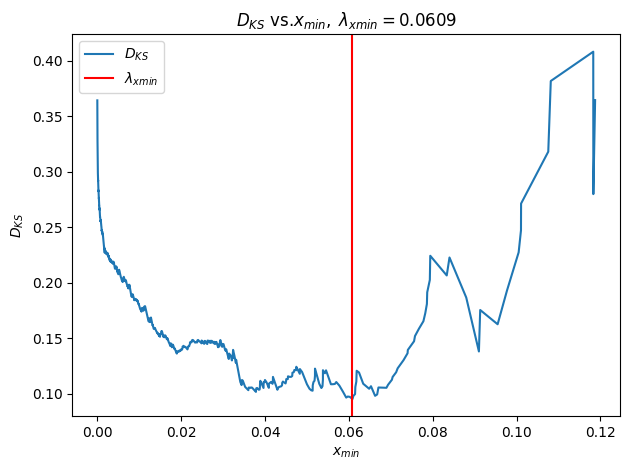

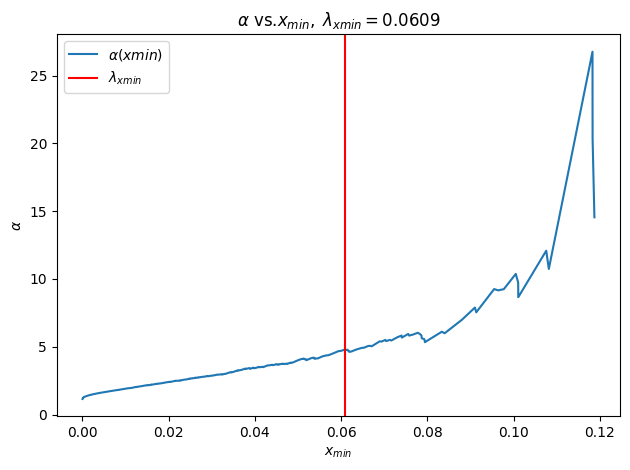

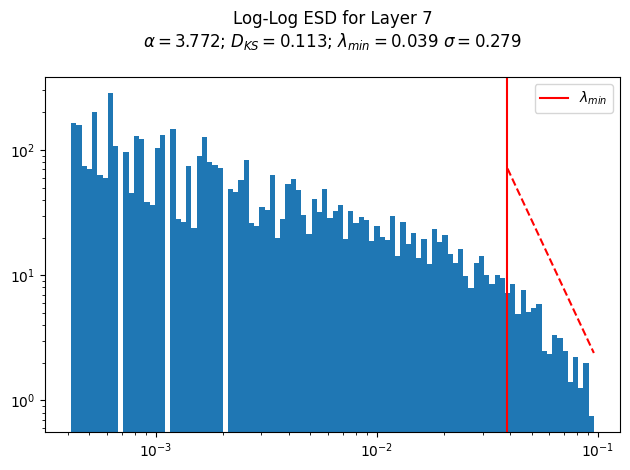

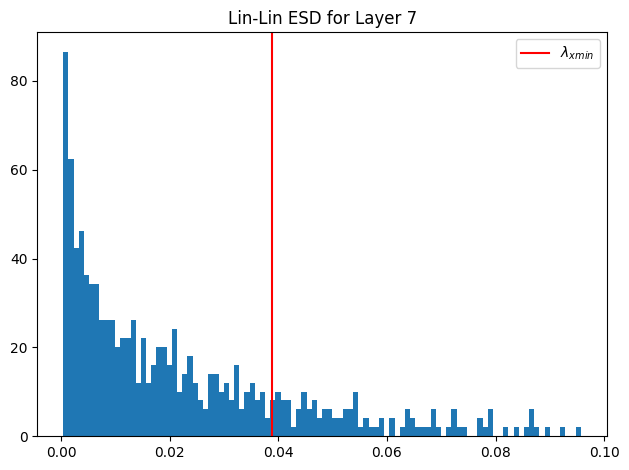

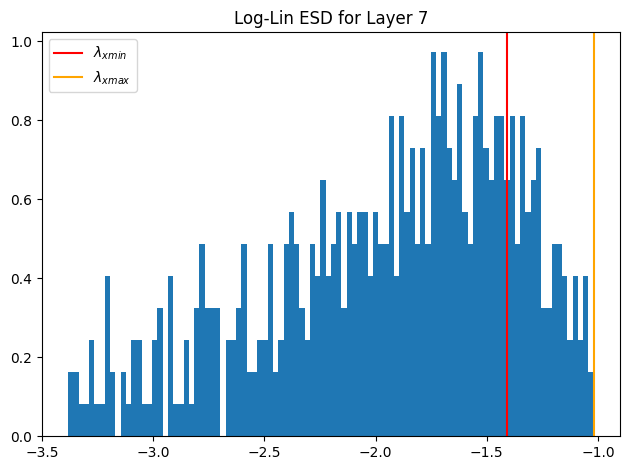

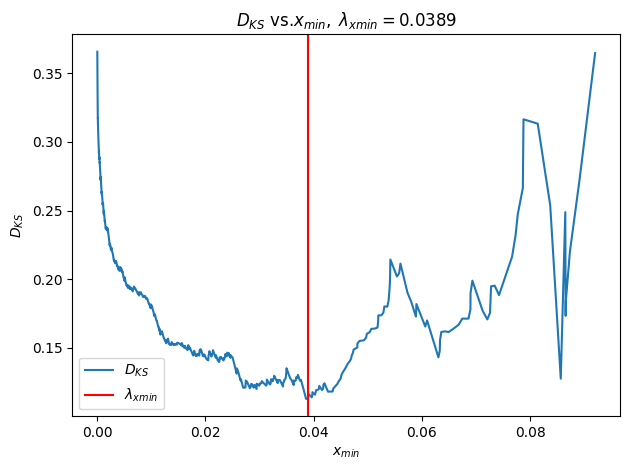

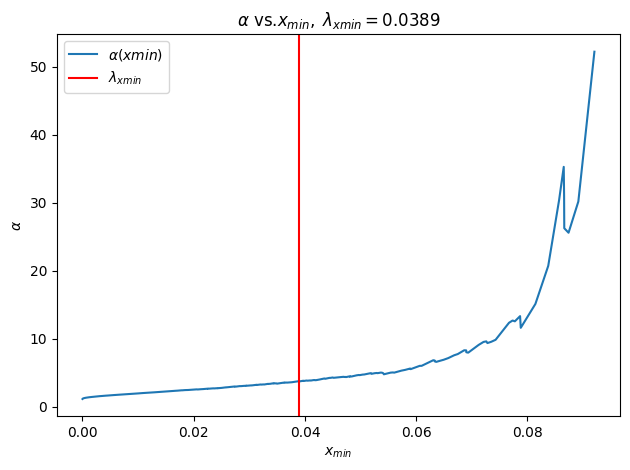

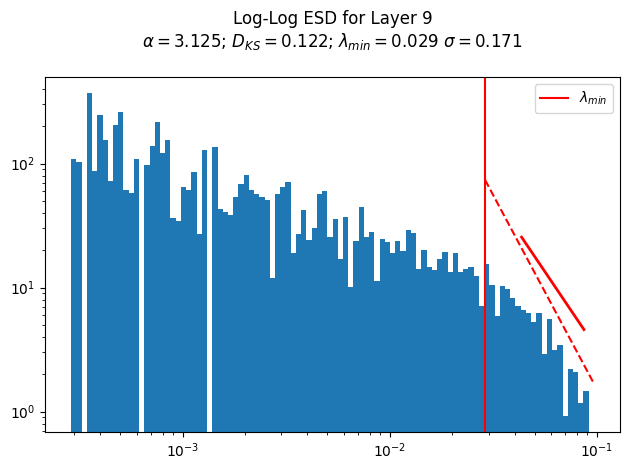

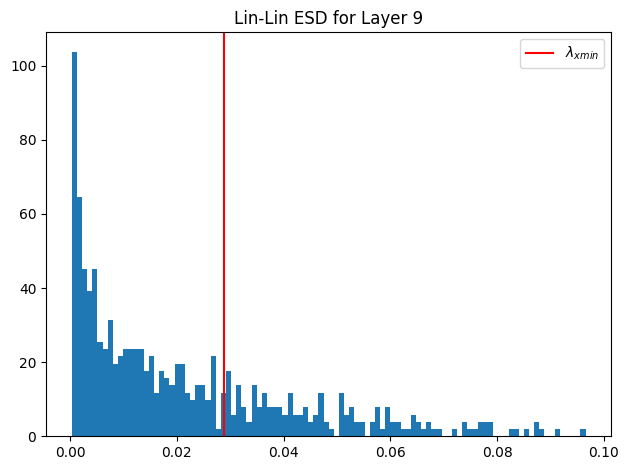

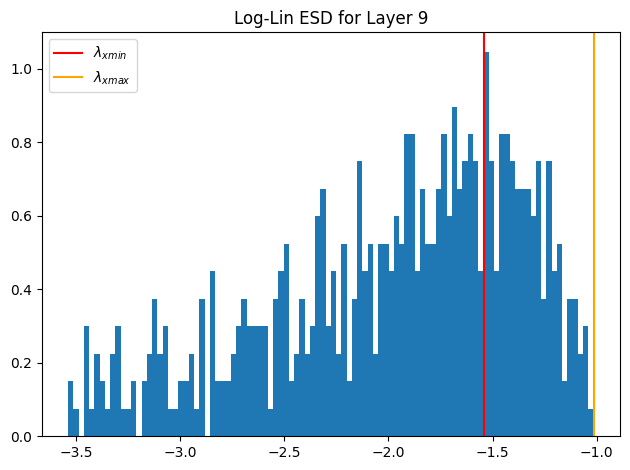

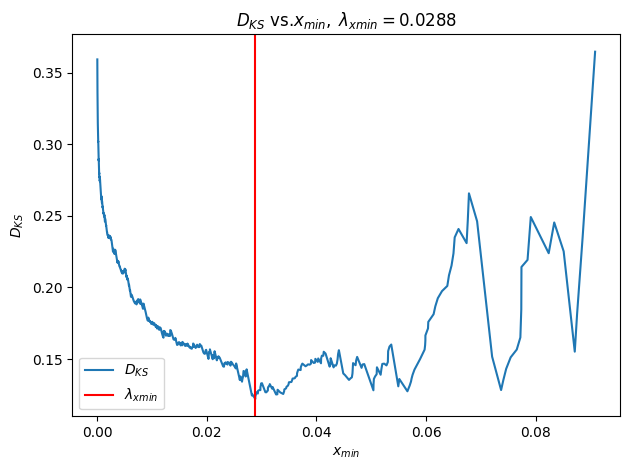

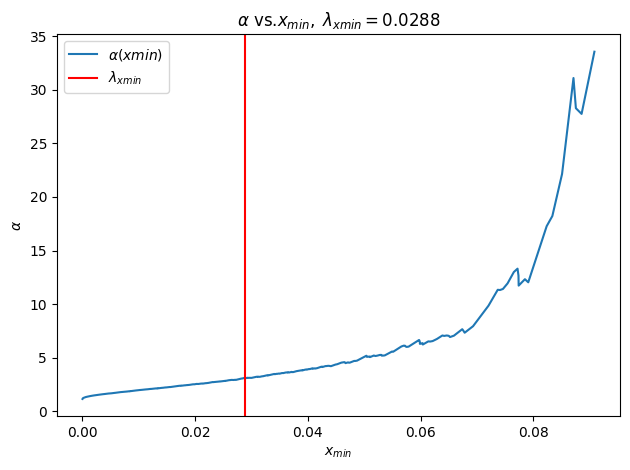

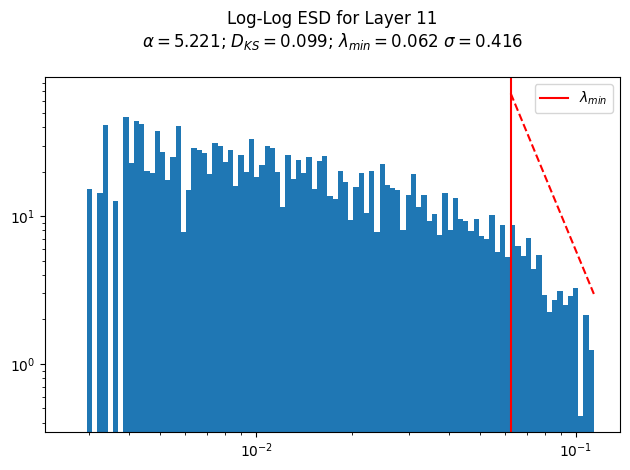

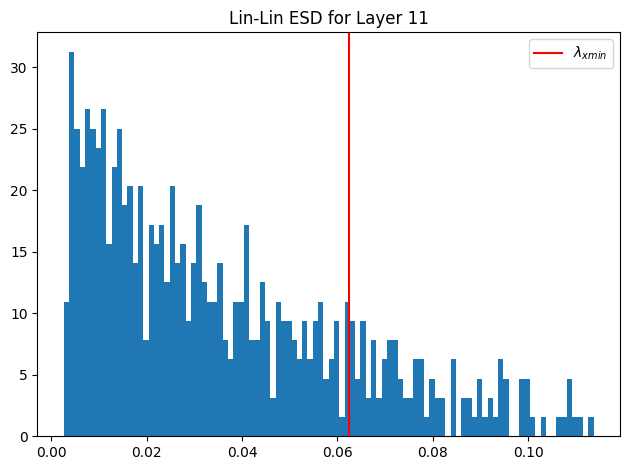

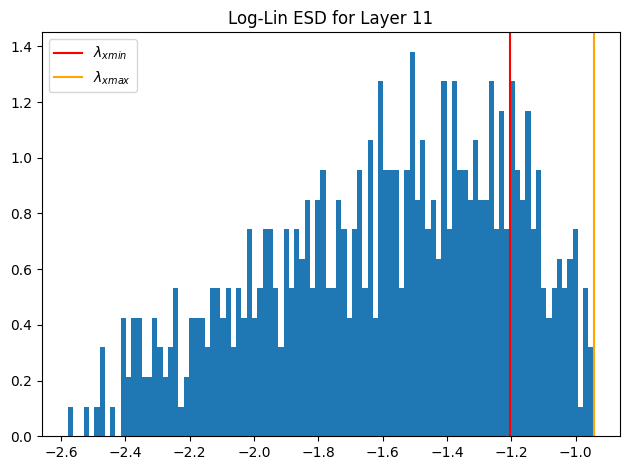

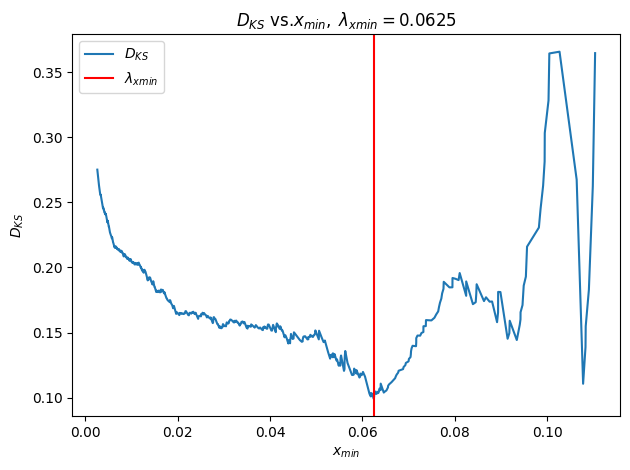

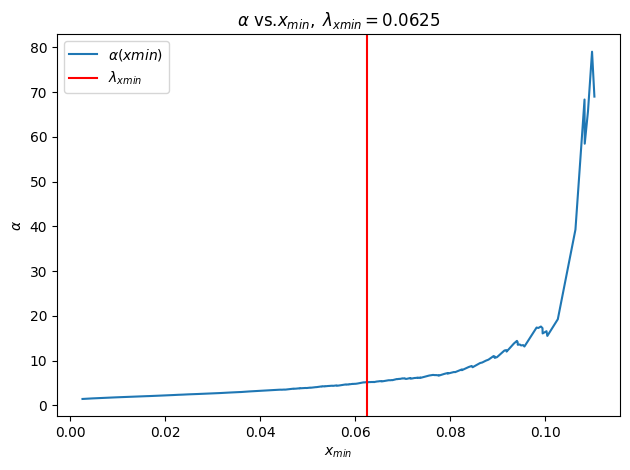

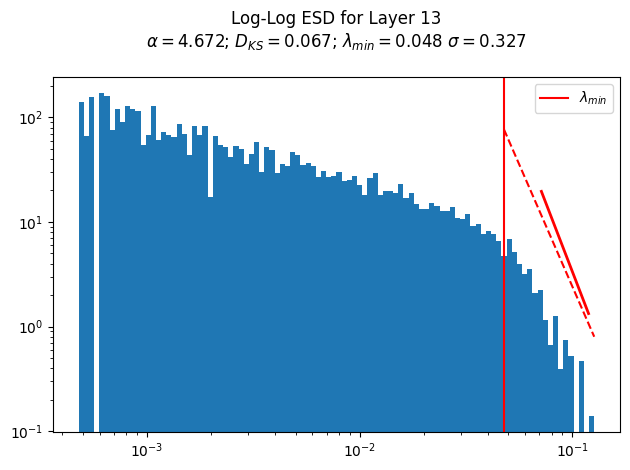

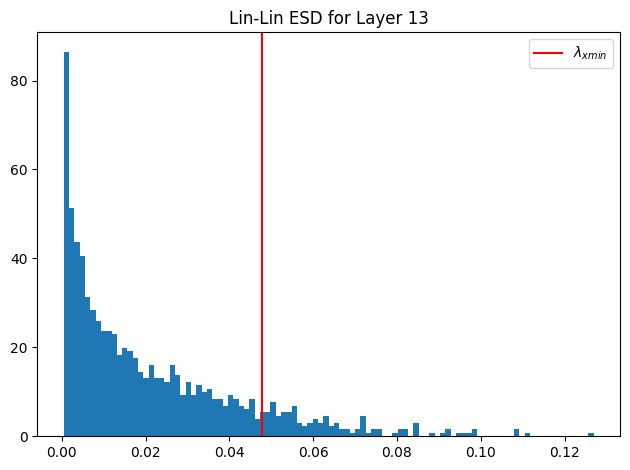

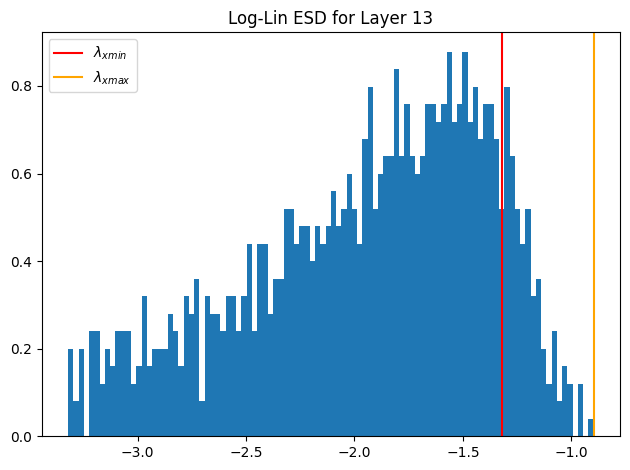

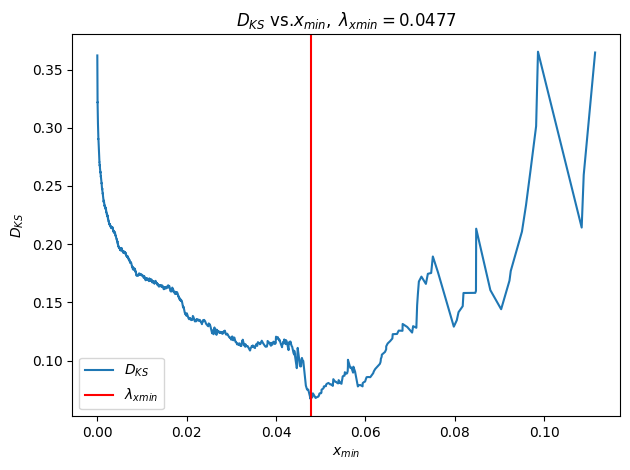

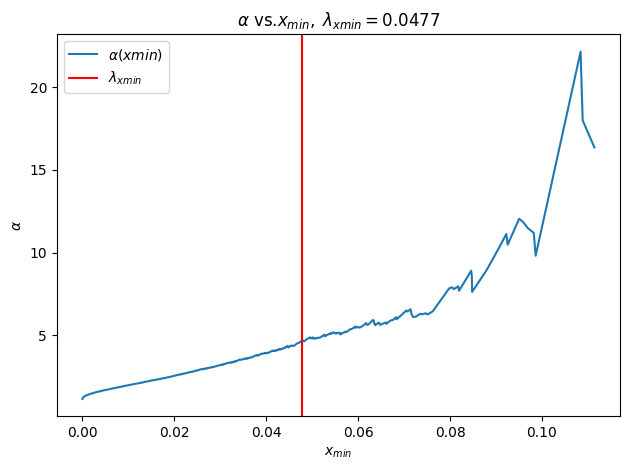

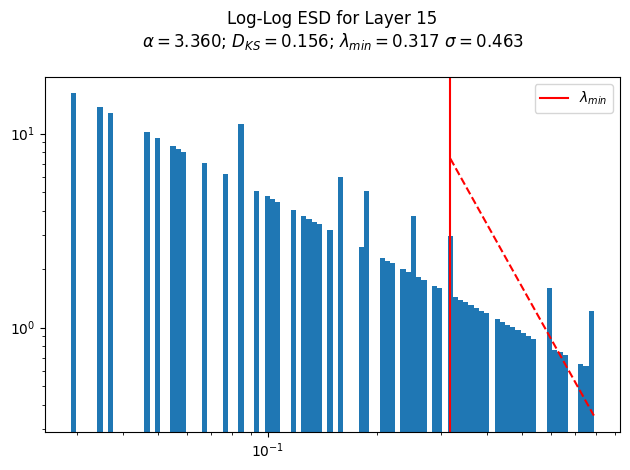

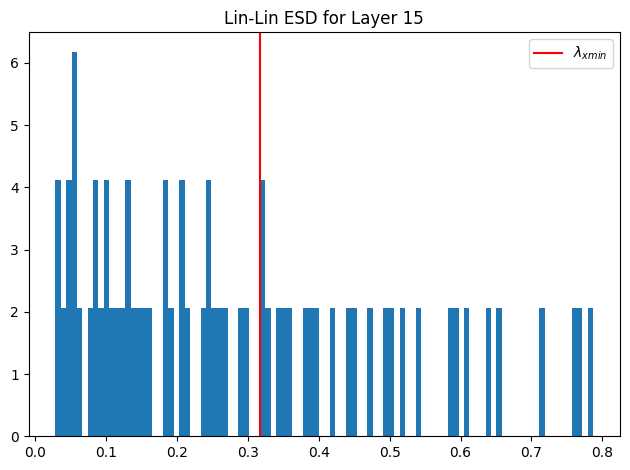

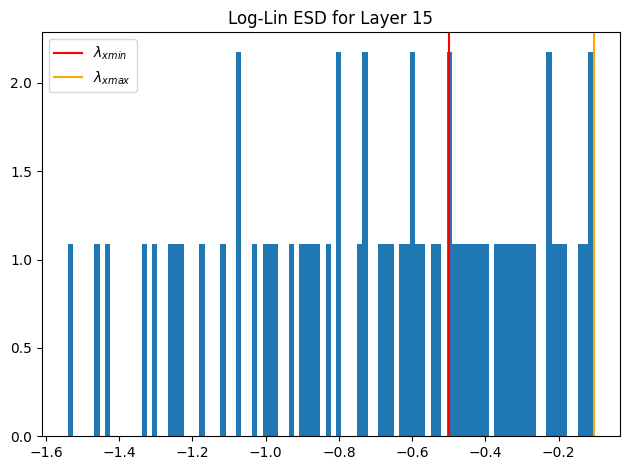

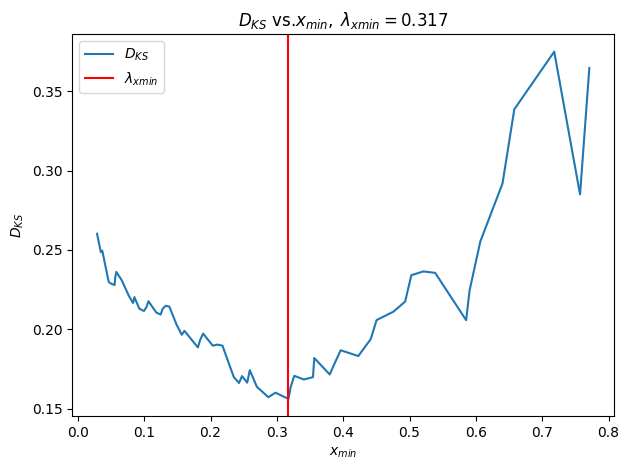

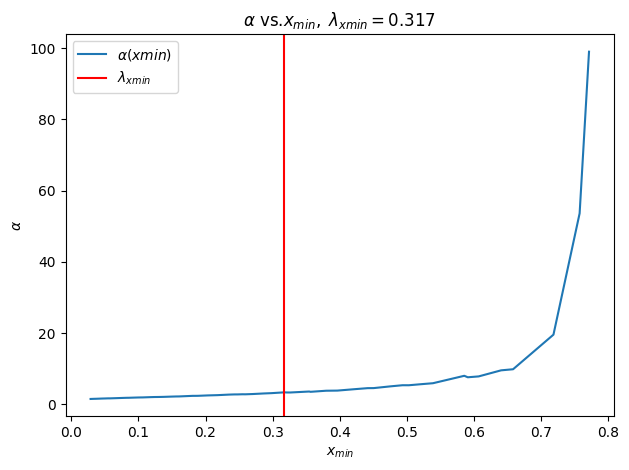

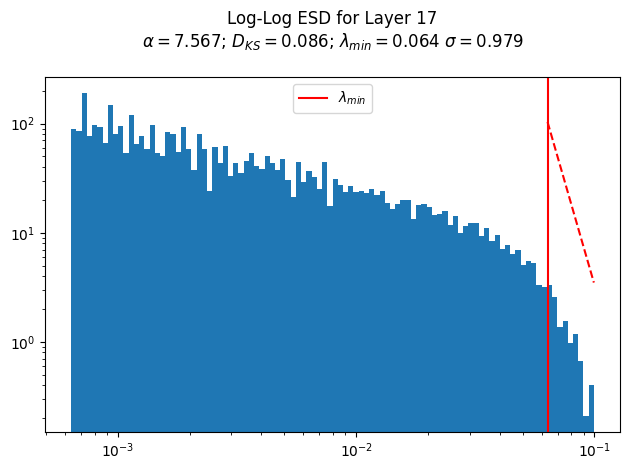

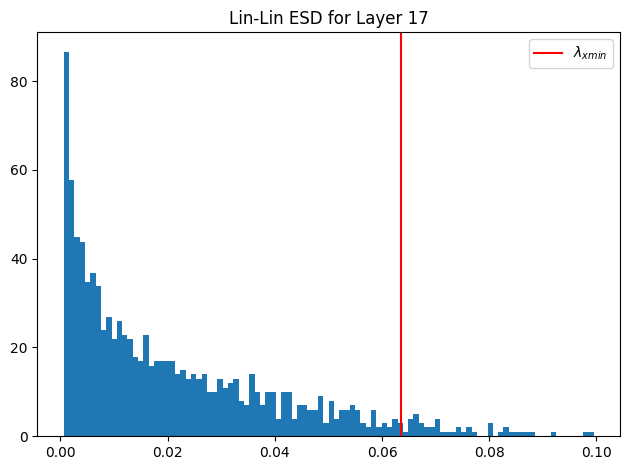

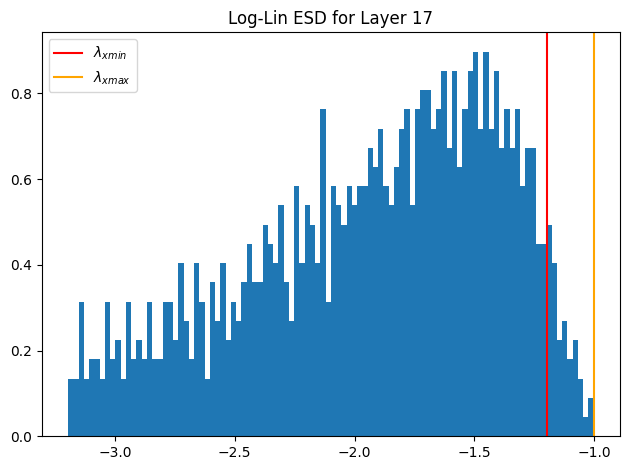

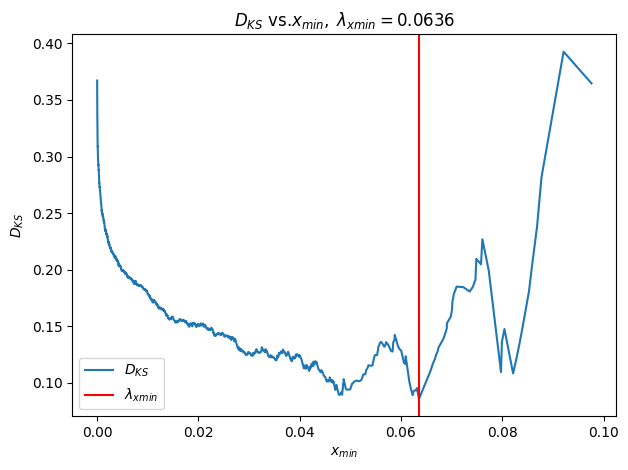

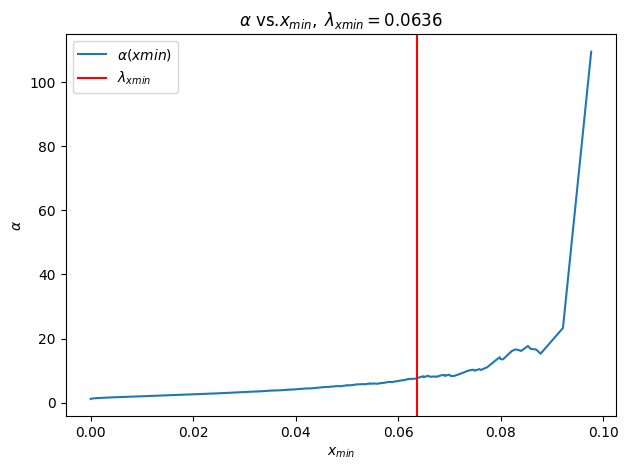

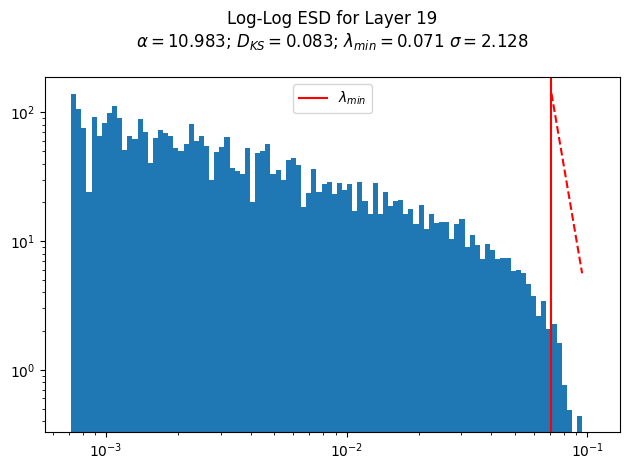

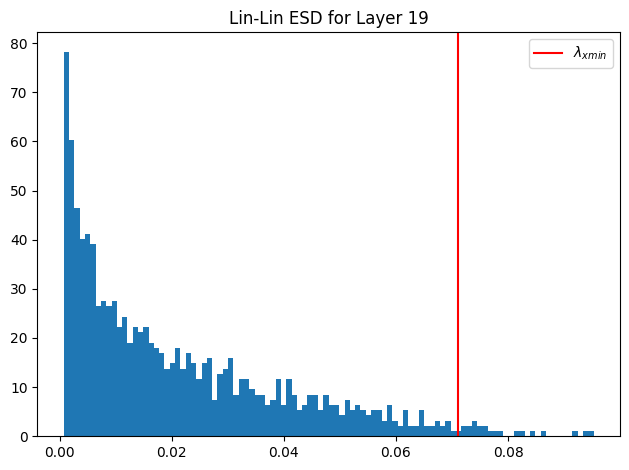

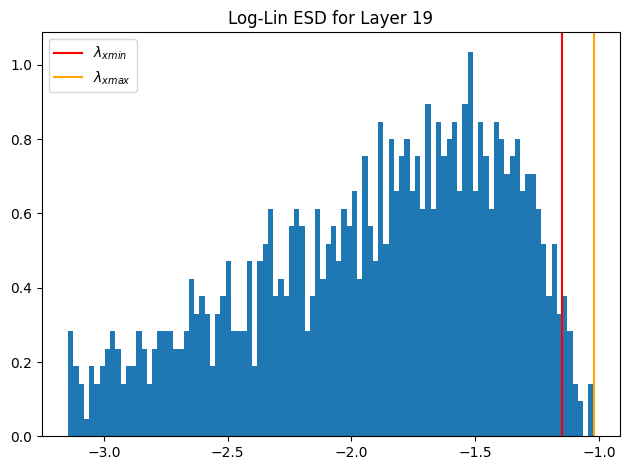

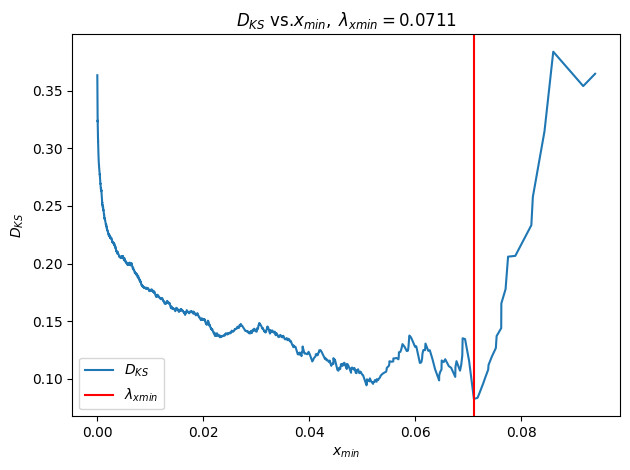

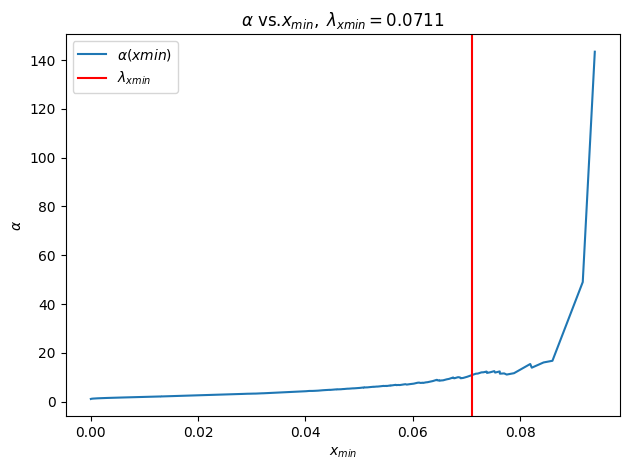

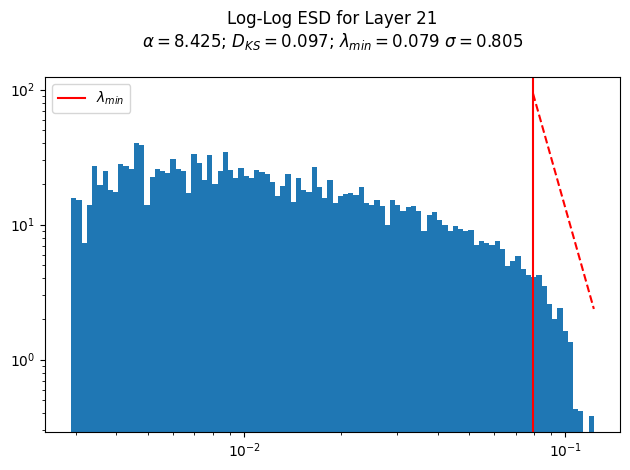

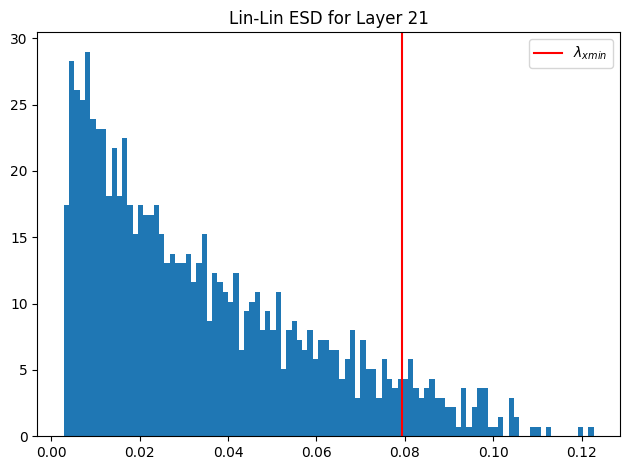

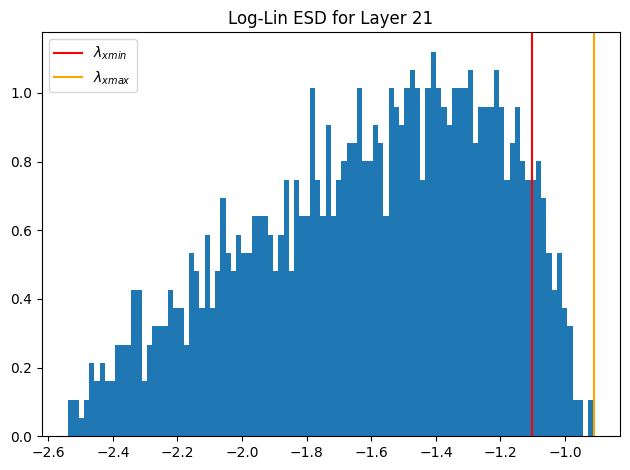

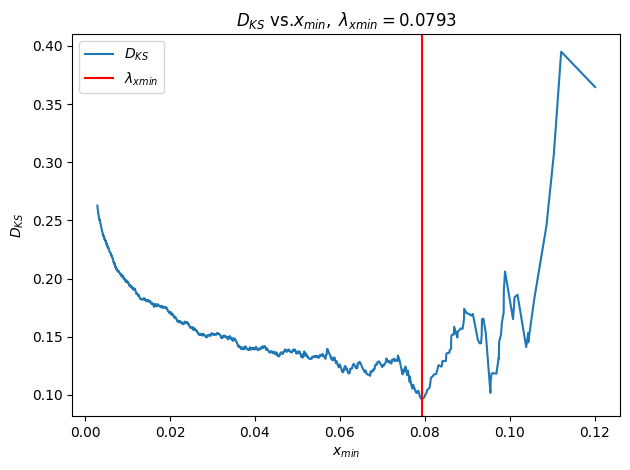

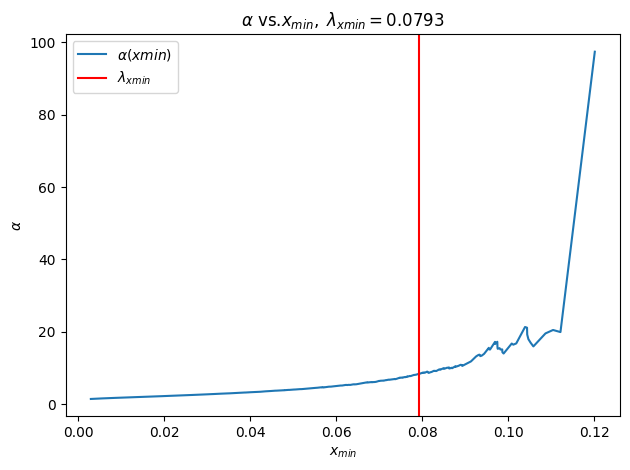

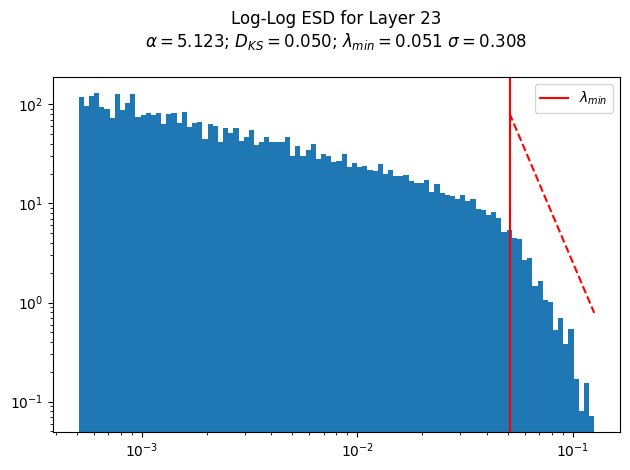

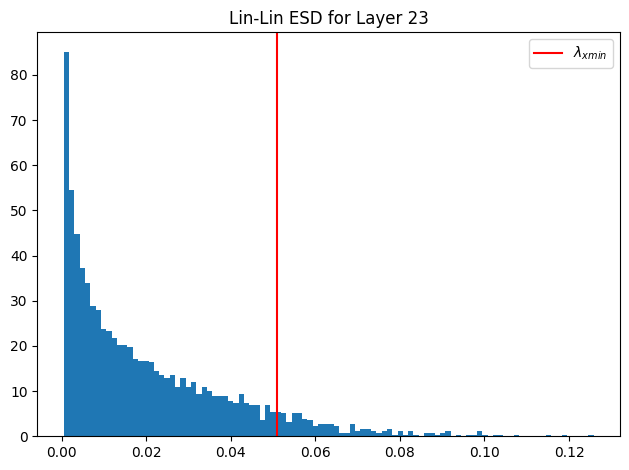

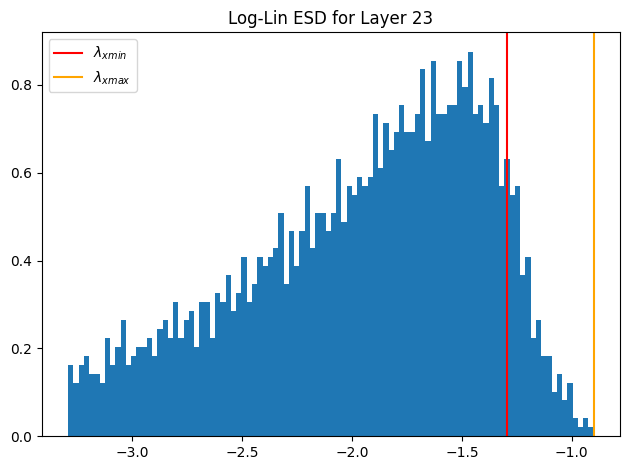

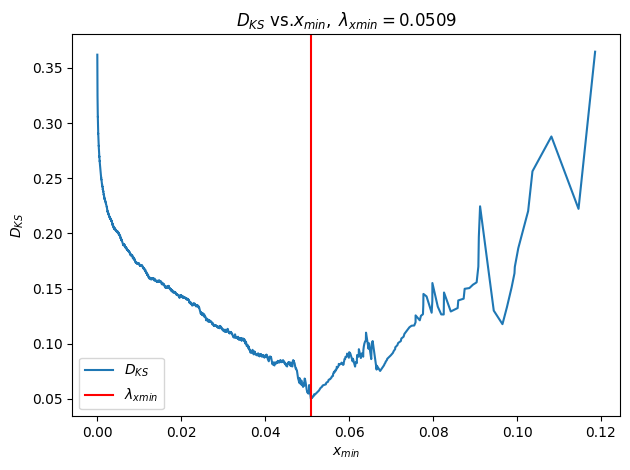

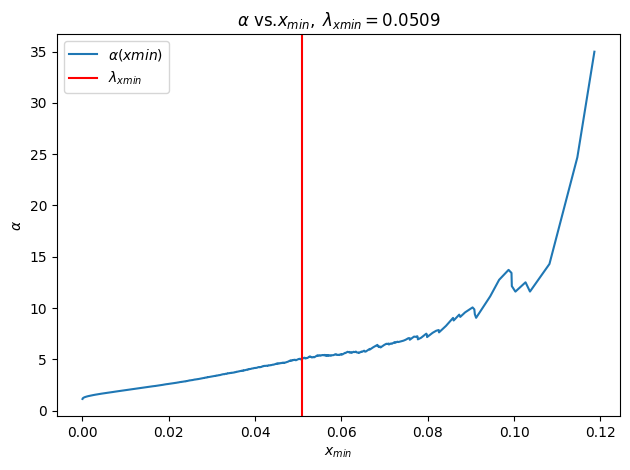

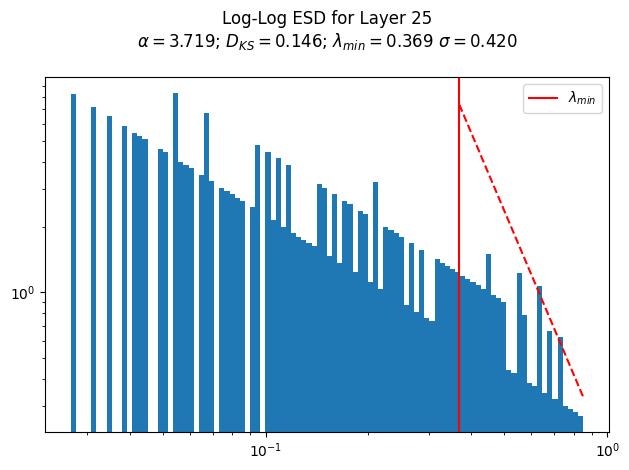

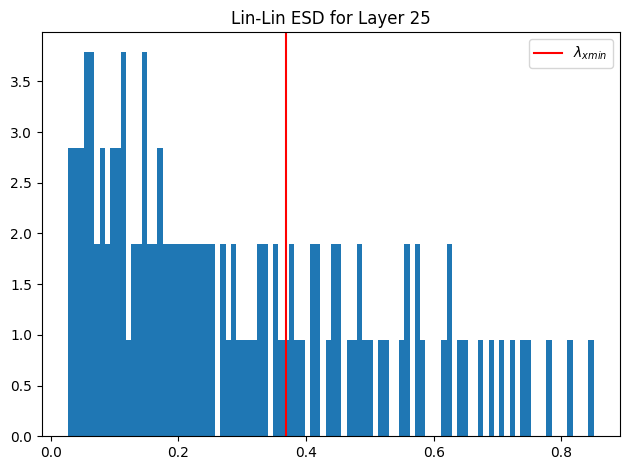

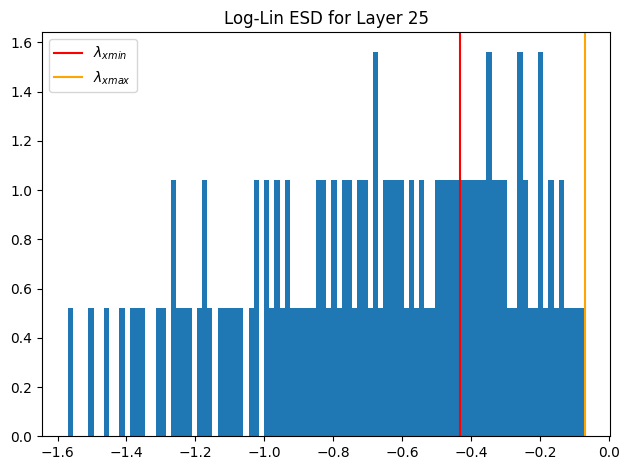

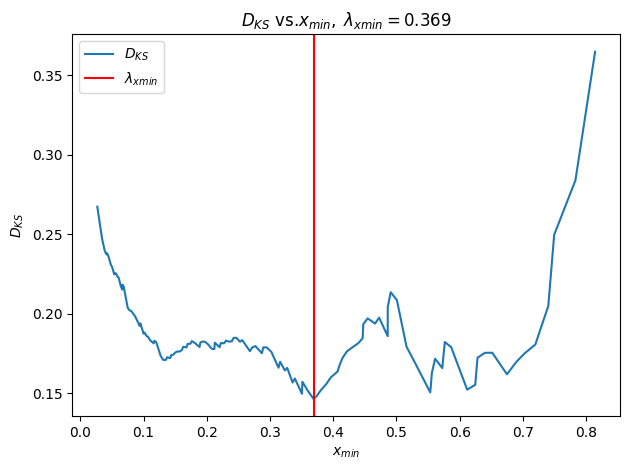

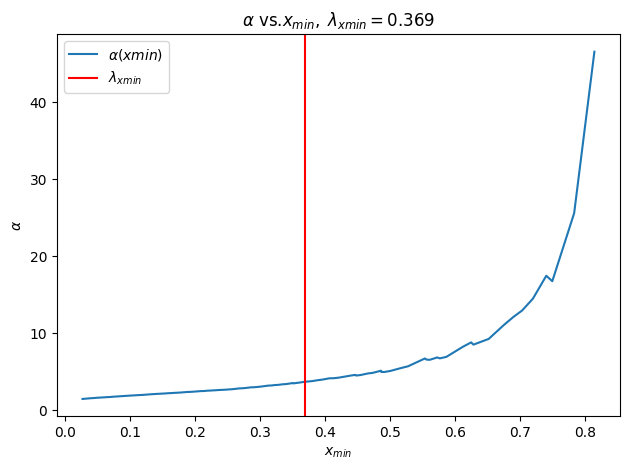

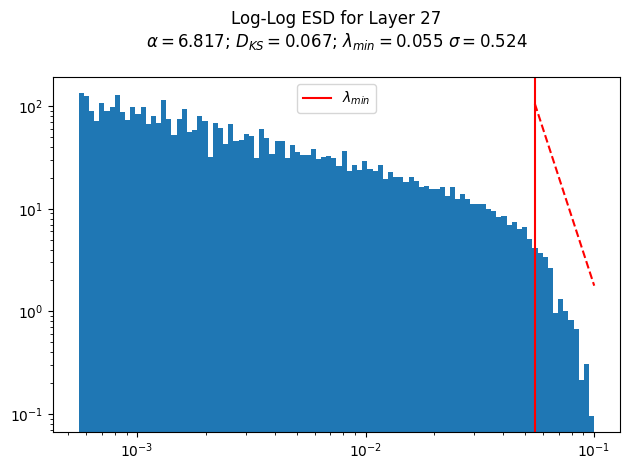

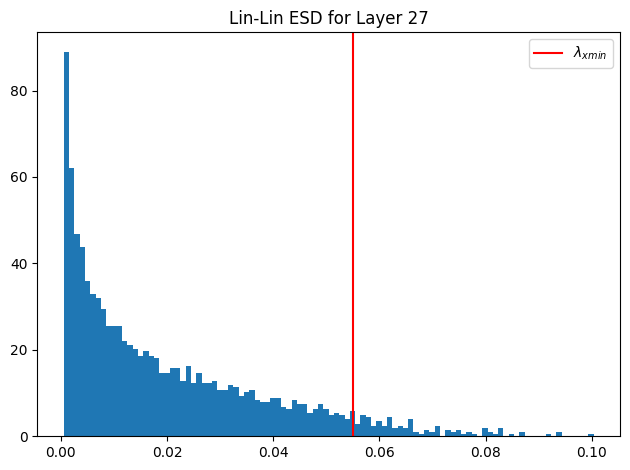

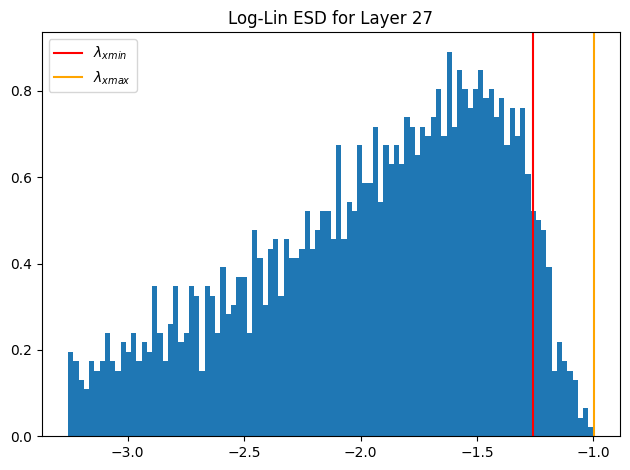

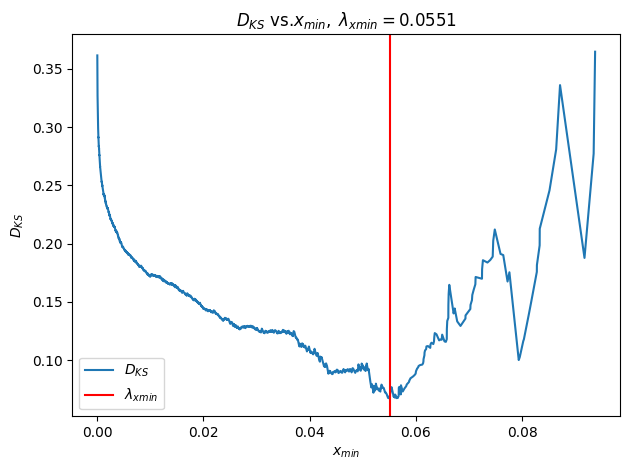

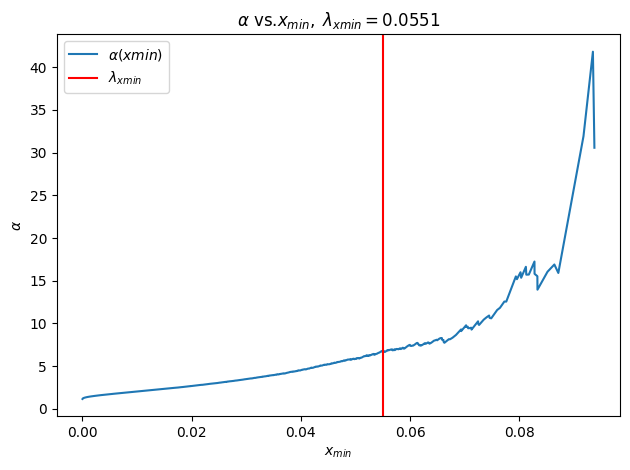

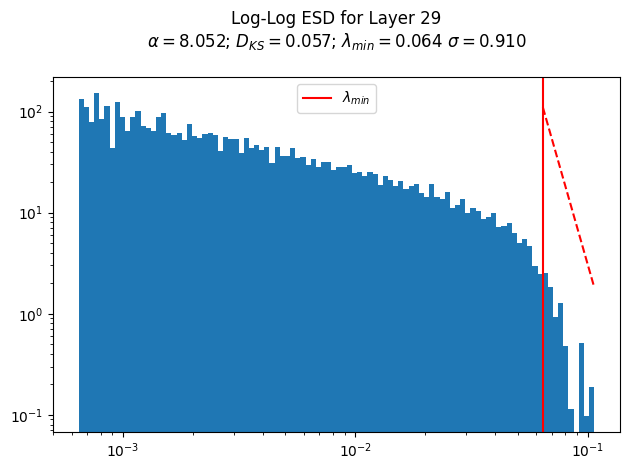

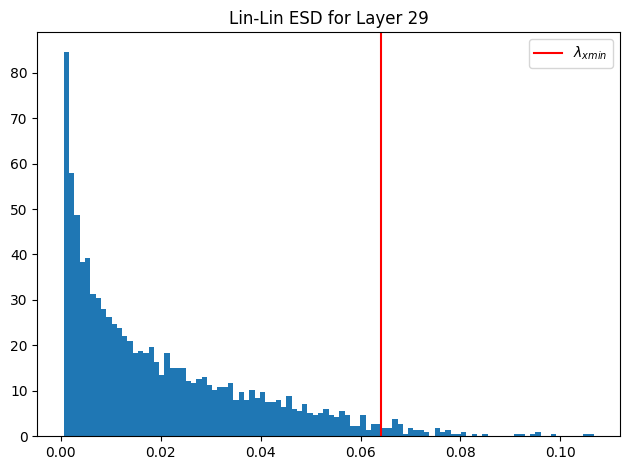

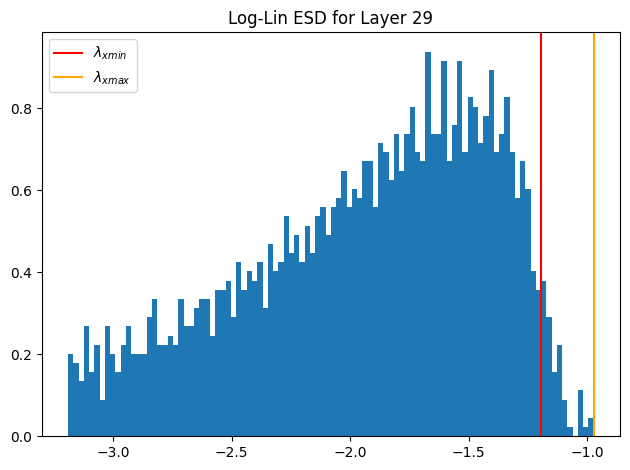

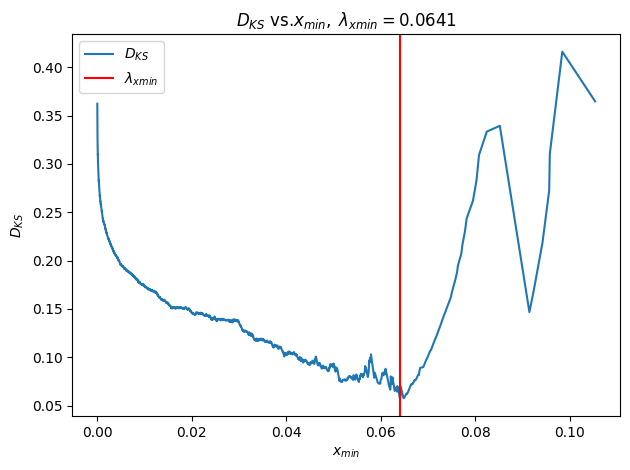

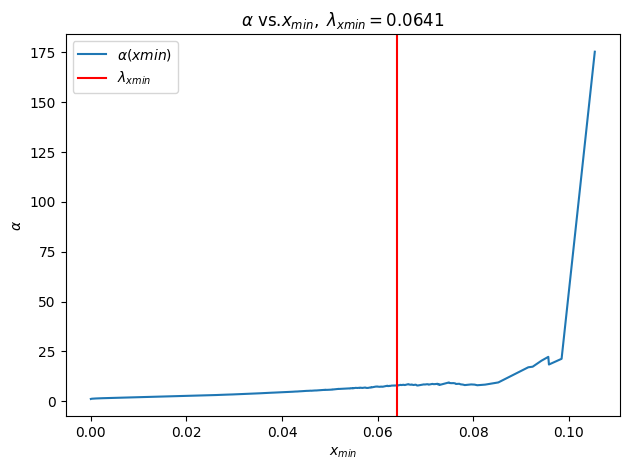

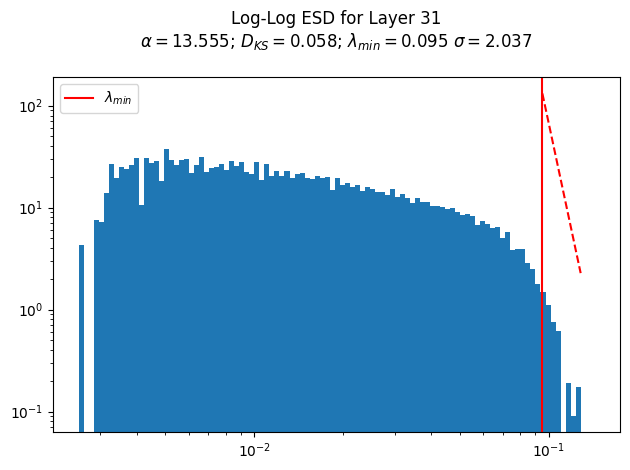

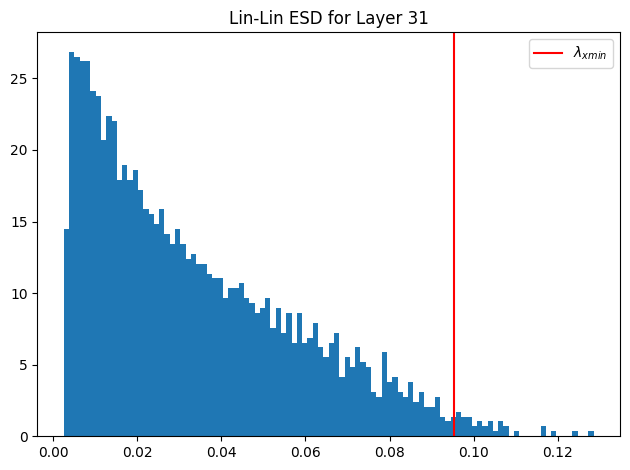

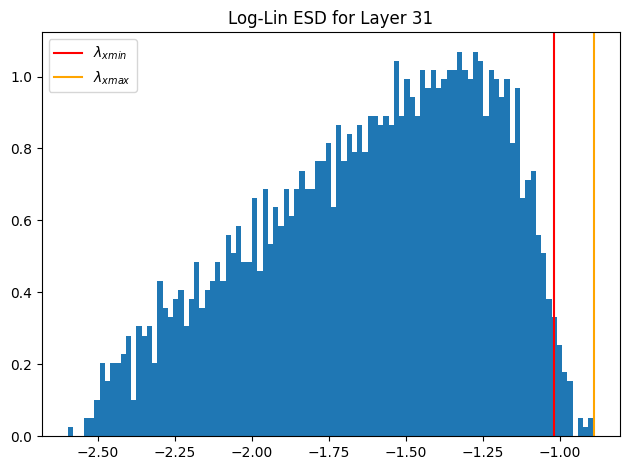

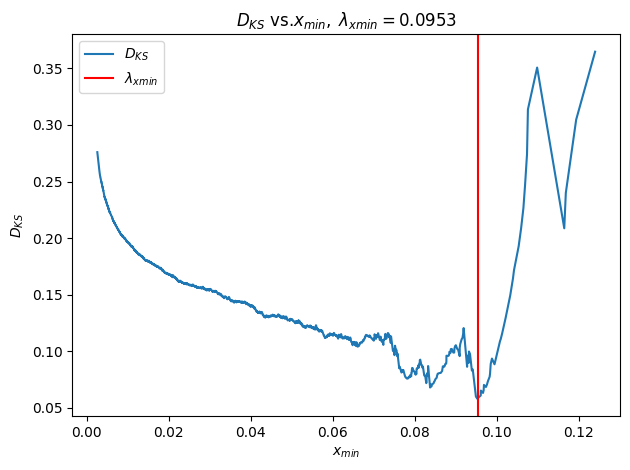

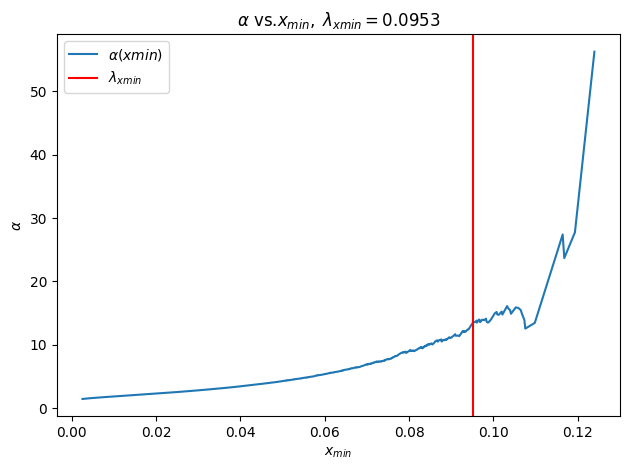

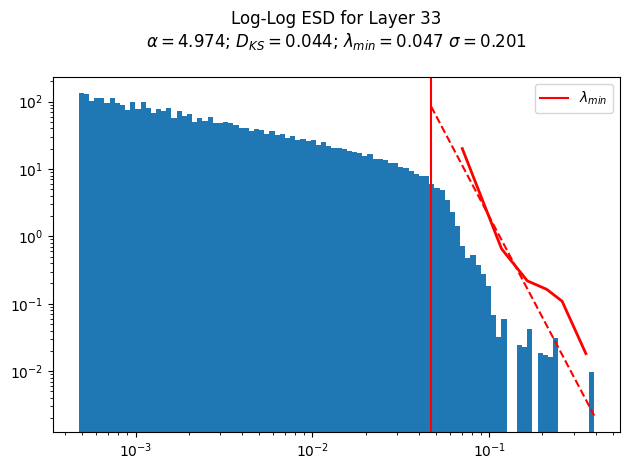

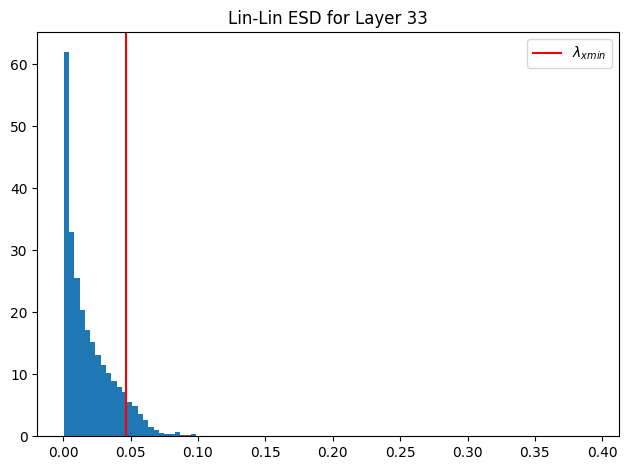

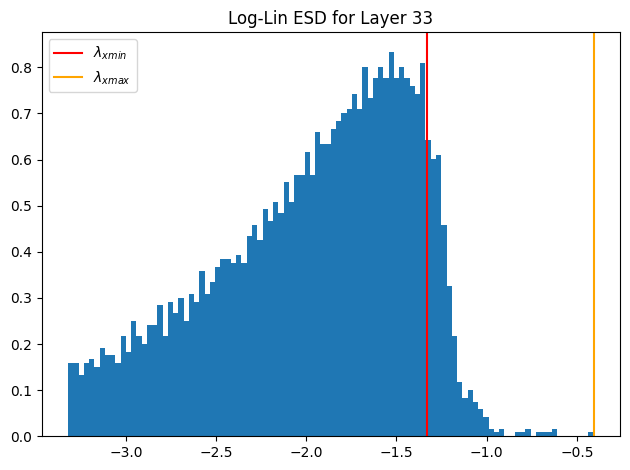

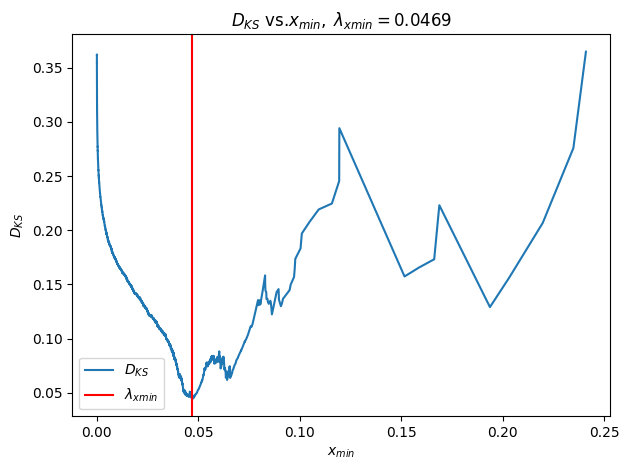

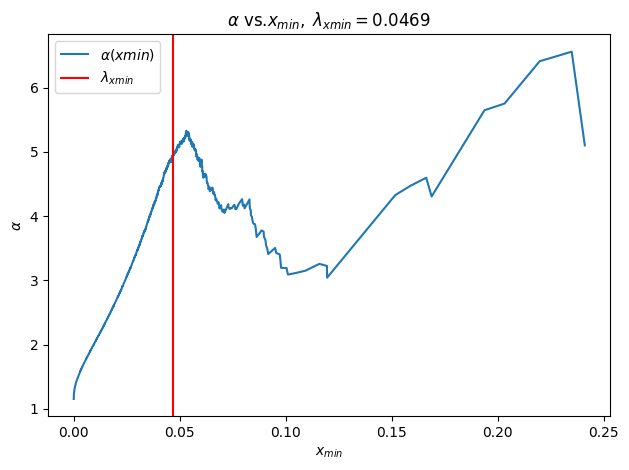

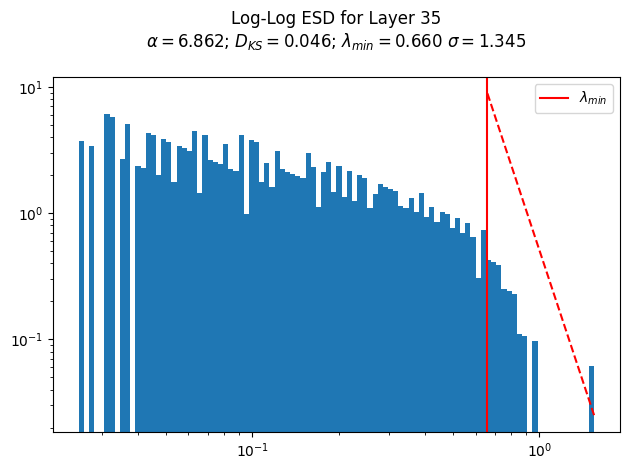

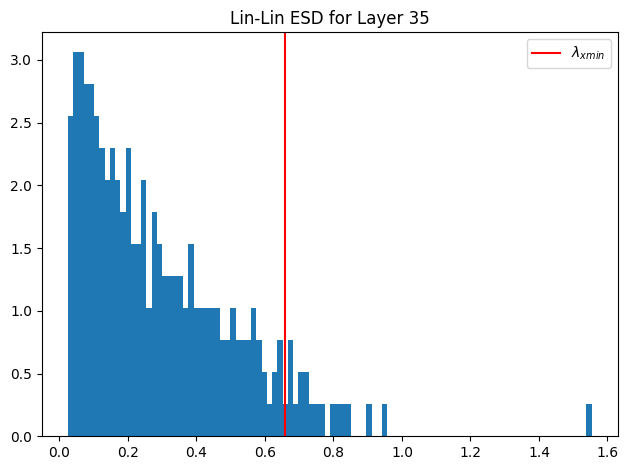

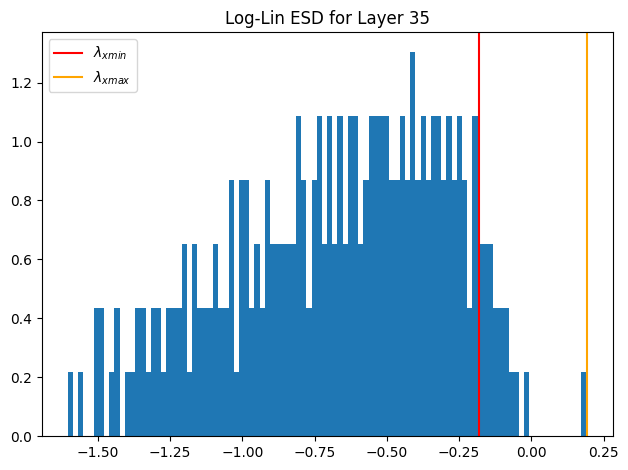

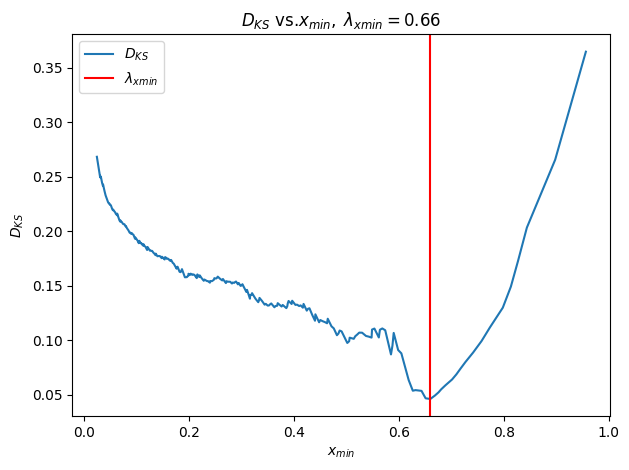

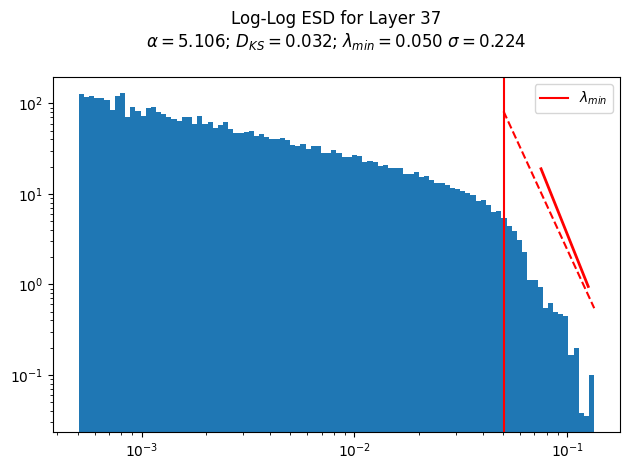

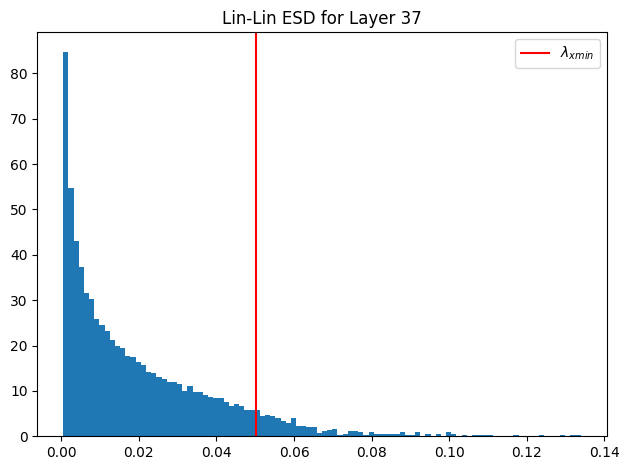

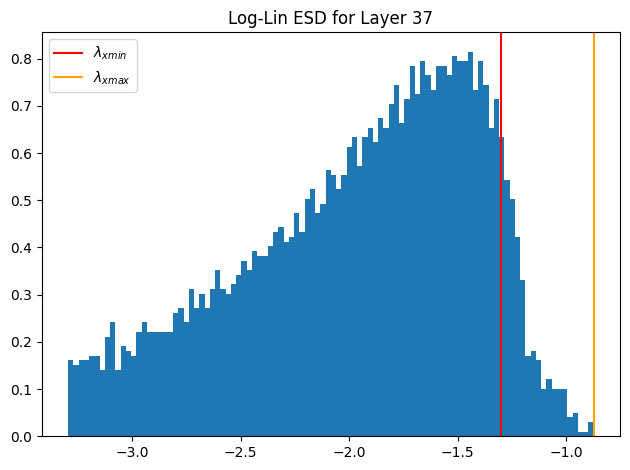

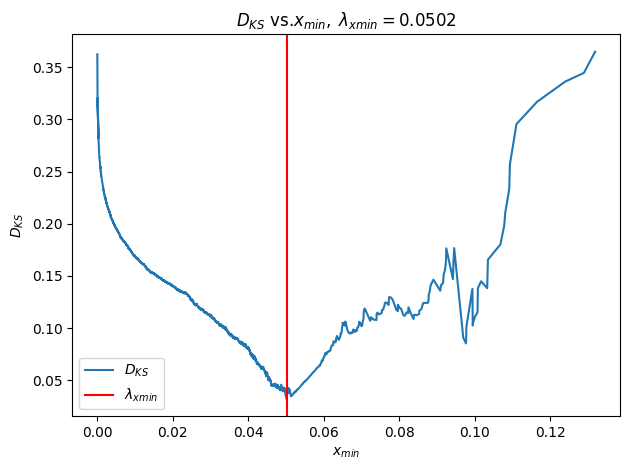

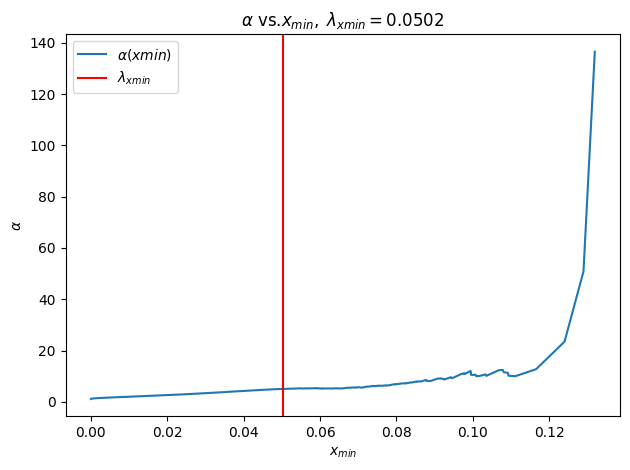

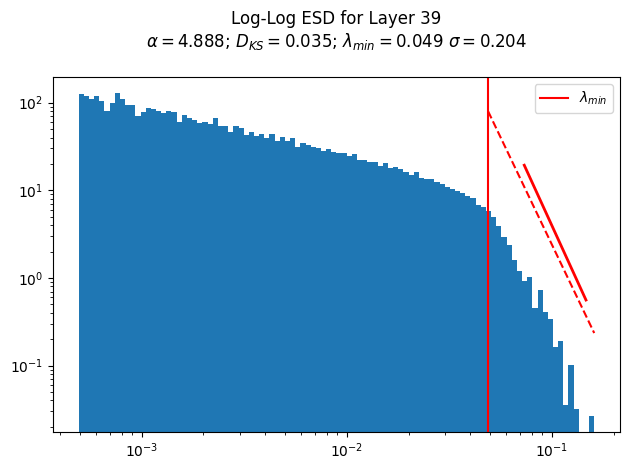

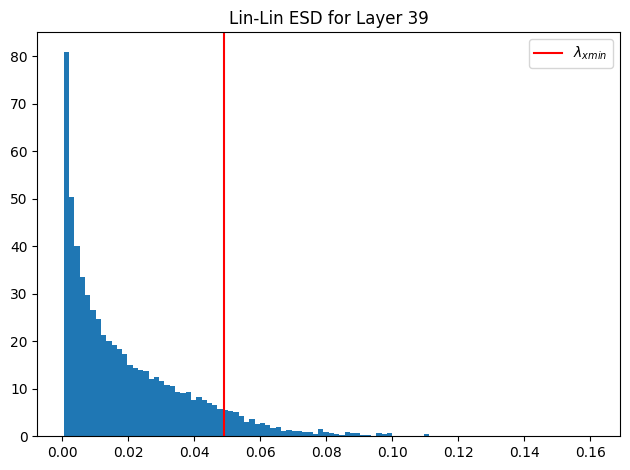

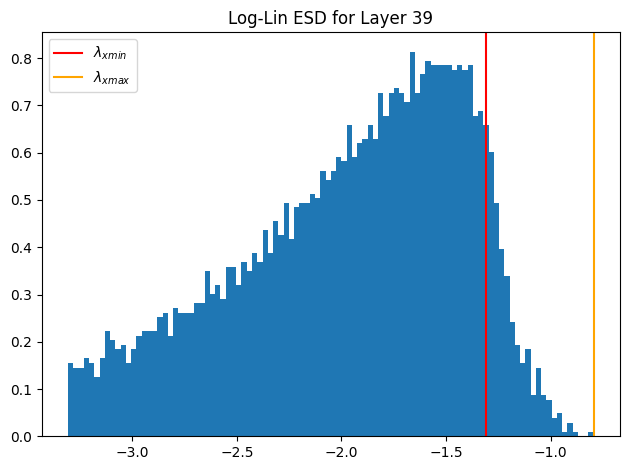

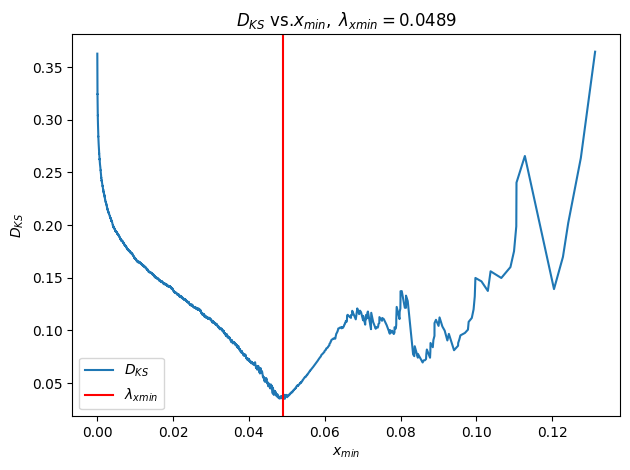

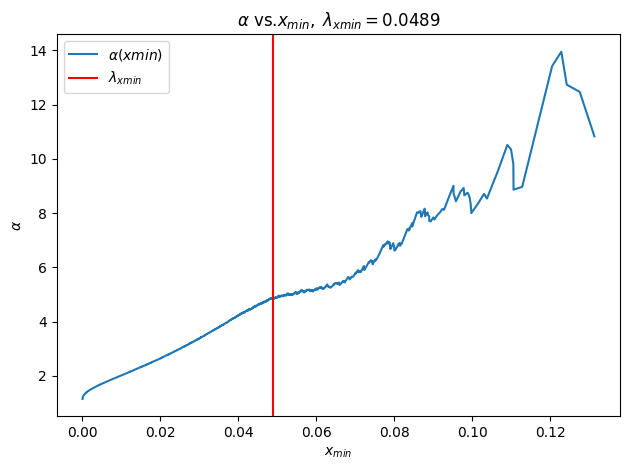

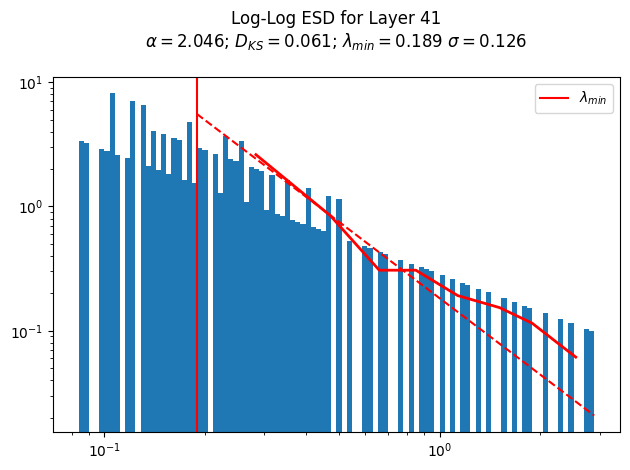

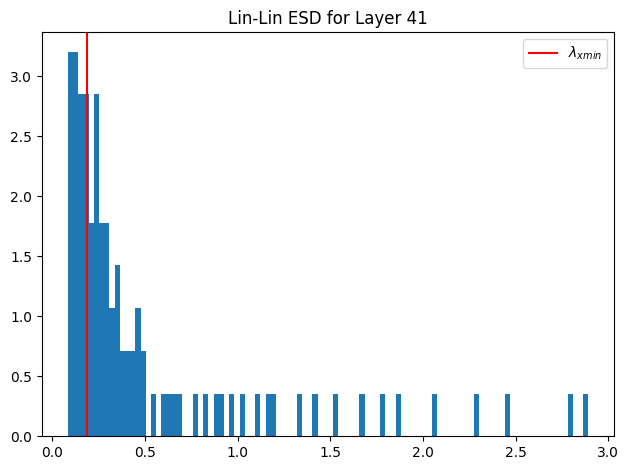

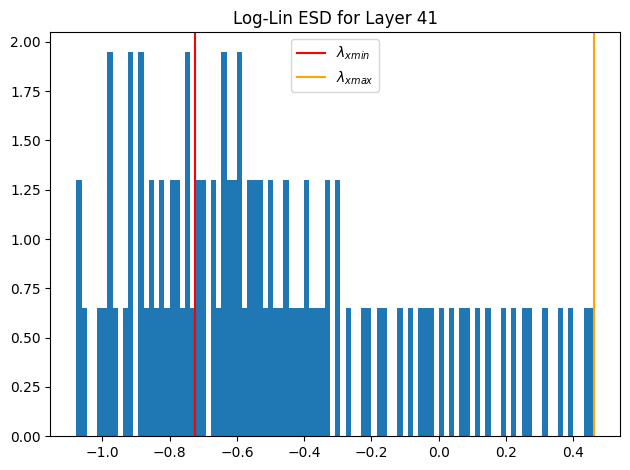

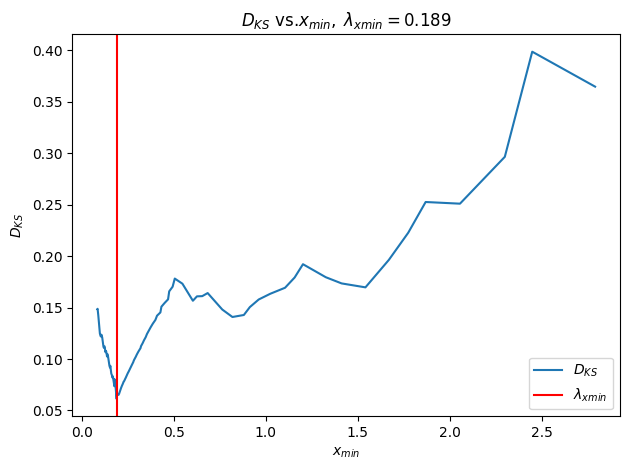

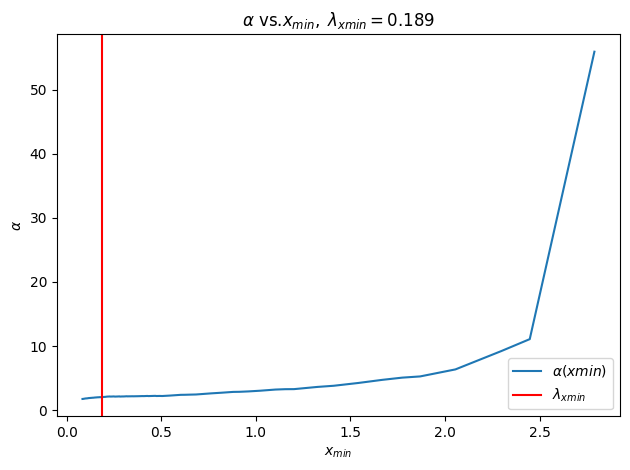

Generated 1 figure(s)
Saved plot 1 to /home/amar/Desktop/DeepFake1M/plots_epoch_2/plot_1.png
Saved all plots to /home/amar/Desktop/DeepFake1M/plots_epoch_2


In [50]:
import os
import torch
import weightwatcher as ww
import matplotlib.pyplot as plt

# Load checkpoint
model_path = "/home/amar/Desktop/DeepFake1M/checkpoints/epoch_2.pth"
checkpoint = torch.load(model_path, map_location=torch.device('cuda'))

# Extract only the model weights
state_dict = checkpoint['model_state_dict']

# Output folder for saving plots
output_dir = "/home/amar/Desktop/DeepFake1M/plots_epoch_2"
os.makedirs(output_dir, exist_ok=True)

# Run WeightWatcher
watcher = ww.WeightWatcher(model=state_dict)
details = watcher.analyze(plot=True)

# Check if any plots were generated
print(f"Generated {len(plt.get_fignums())} figure(s)")

# Save all generated plots
for idx, fig_num in enumerate(plt.get_fignums()):
    try:
        fig = plt.figure(fig_num)
        plot_path = os.path.join(output_dir, f"plot_{idx+1}.png")
        fig.savefig(plot_path)
        print(f"Saved plot {idx+1} to {plot_path}")
    except Exception as e:
        print(f"Error saving plot {idx+1}: {e}")

# Close all to free memory
plt.close('all')

print(f"Saved all plots to {output_dir}")


In [51]:
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image

# Directory where the ESD plots are saved
esd_dir = "plots/esd"
animation_dir = "plots/animations"
os.makedirs(animation_dir, exist_ok=True)

# Gather all ESD files
esd_files = glob.glob(os.path.join(esd_dir, "*.png"))

# Group by layer name
layer_to_files = {}
for f in esd_files:
    base = os.path.basename(f)
    parts = base.split('_epoch')
    layer_name = parts[0]
    if layer_name not in layer_to_files:
        layer_to_files[layer_name] = []
    layer_to_files[layer_name].append((int(parts[1].split('.')[0]), f))  # (epoch_num, path)

# Sort files by epoch number for each layer
for layer in layer_to_files:
    layer_to_files[layer] = sorted(layer_to_files[layer], key=lambda x: x[0])

# Create an animation for each layer
for layer_name, files in layer_to_files.items():
    fig, ax = plt.subplots()
    img = plt.imshow(Image.open(files[0][1]))
    plt.axis('off')
    plt.title(f"Layer: {layer_name}")

    def update(frame_idx):
        epoch, file_path = files[frame_idx]
        img.set_data(Image.open(file_path))
        ax.set_title(f"{layer_name} - Epoch {epoch}")
        return img,

    ani = FuncAnimation(fig, update, frames=len(files), interval=500, blit=True)

    output_path = os.path.join(animation_dir, f"{layer_name}.gif")
    ani.save(output_path, writer='pillow')
    plt.close(fig)

print(f"✅ Animations saved to {animation_dir}")


✅ Animations saved to plots/animations


In [52]:
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image

def create_histogram_animations(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all histogram images in the directory
    hist_files = glob.glob(os.path.join(input_dir, "*.png"))

    # Group files by layer name (without epoch part)
    layer_to_files = {}
    for f in hist_files:
        base = os.path.basename(f)
        parts = base.split('_epoch')
        layer_name = parts[0]
        epoch_number = int(parts[1].split('.')[0])
        if layer_name not in layer_to_files:
            layer_to_files[layer_name] = []
        layer_to_files[layer_name].append((epoch_number, f))

    # Sort files for each layer by epoch
    for layer in layer_to_files:
        layer_to_files[layer] = sorted(layer_to_files[layer], key=lambda x: x[0])

    # Create animations
    for layer_name, files in layer_to_files.items():
        fig, ax = plt.subplots()
        img = plt.imshow(Image.open(files[0][1]))
        plt.axis('off')
        plt.title(f"Layer: {layer_name}")

        def update(frame_idx):
            epoch, file_path = files[frame_idx]
            img.set_data(Image.open(file_path))
            ax.set_title(f"{layer_name} - Epoch {epoch}")
            return img,

        ani = FuncAnimation(fig, update, frames=len(files), interval=500, blit=True)

        output_path = os.path.join(output_dir, f"{layer_name}.gif")
        ani.save(output_path, writer='pillow')
        plt.close(fig)

    print(f"✅ Animations created in {output_dir}")

# ===== Run for Weights and Biases =====
create_histogram_animations("plots/weights", "plots/animations/weights")
create_histogram_animations("plots/biases", "plots/animtions/biases")


✅ Animations created in plots/animations/weights
✅ Animations created in plots/animations/biases


Processing epoch_1.pth...


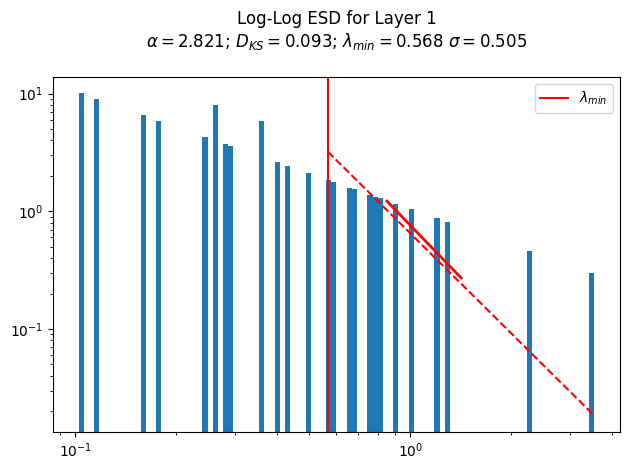

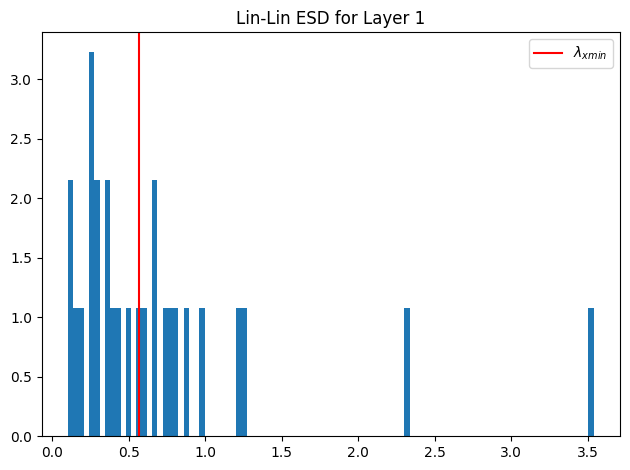

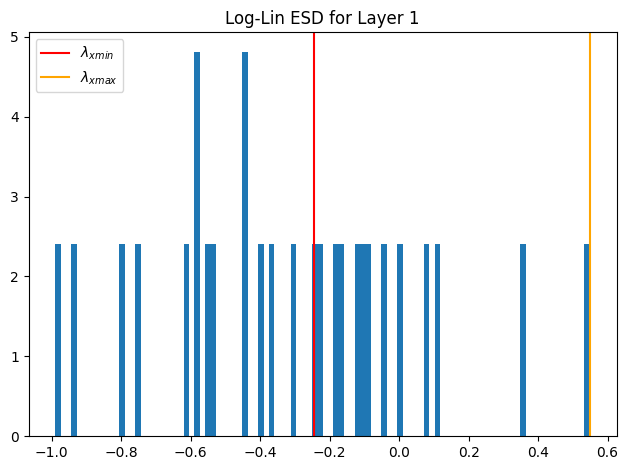

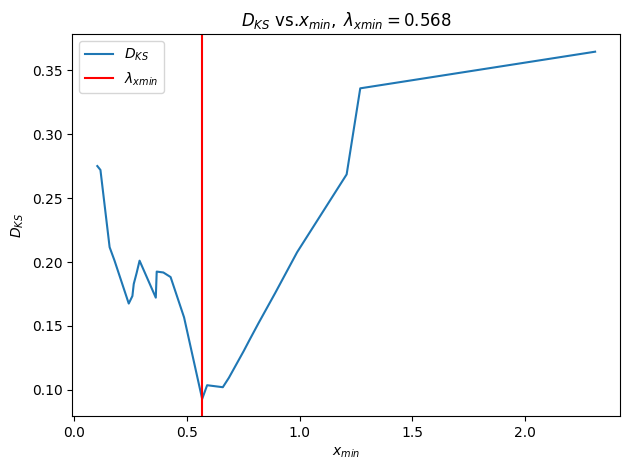

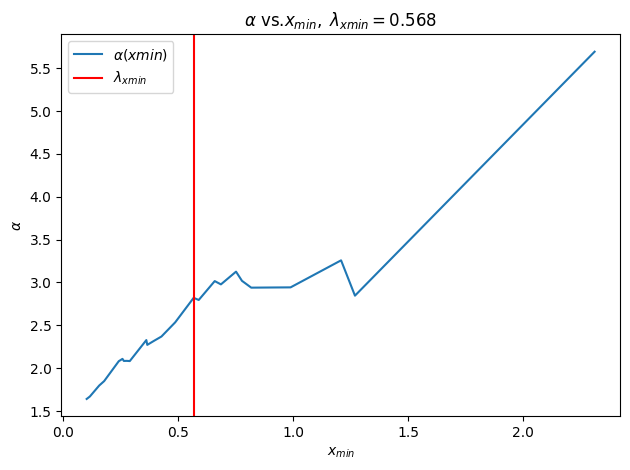

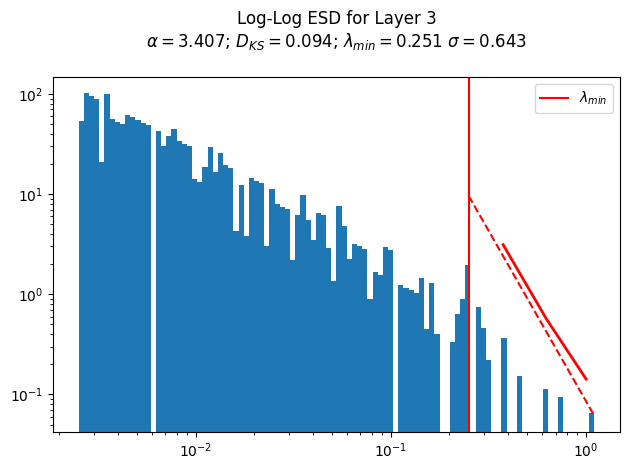

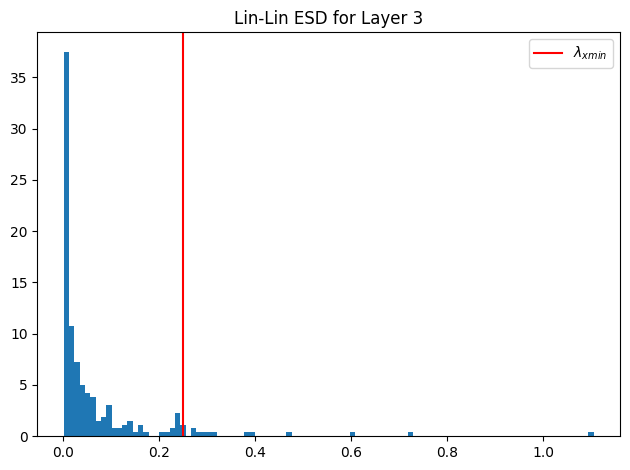

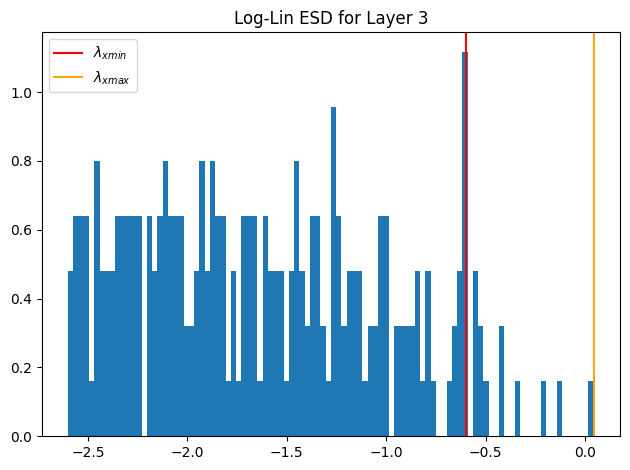

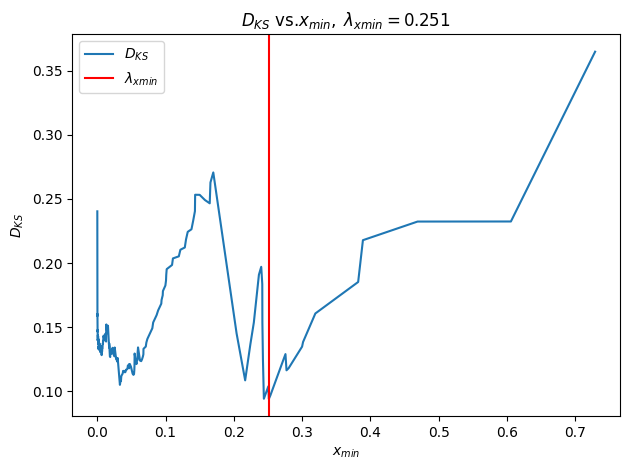

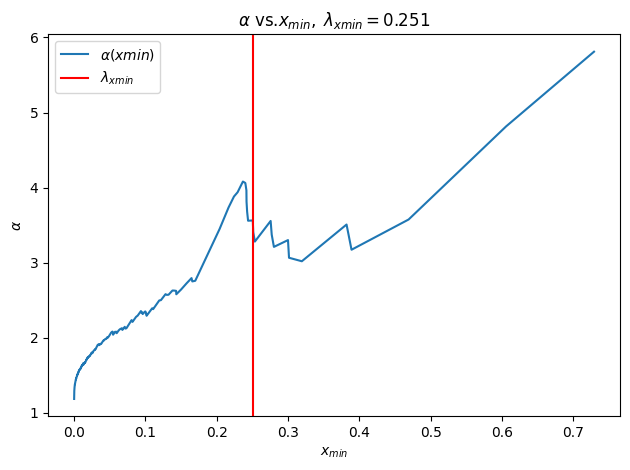

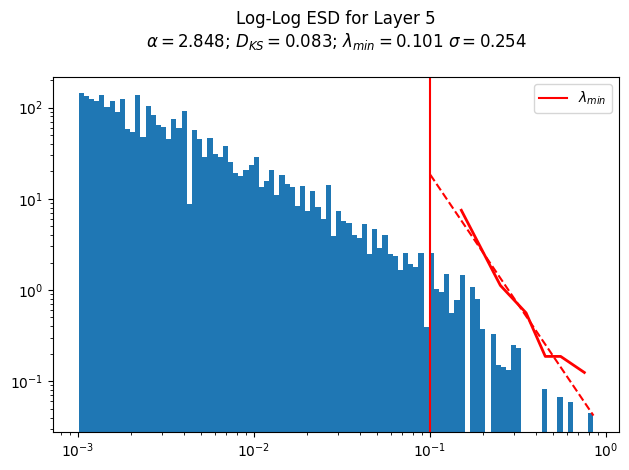

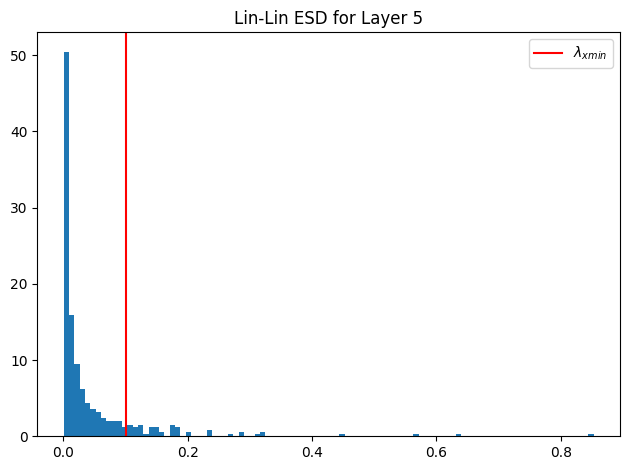

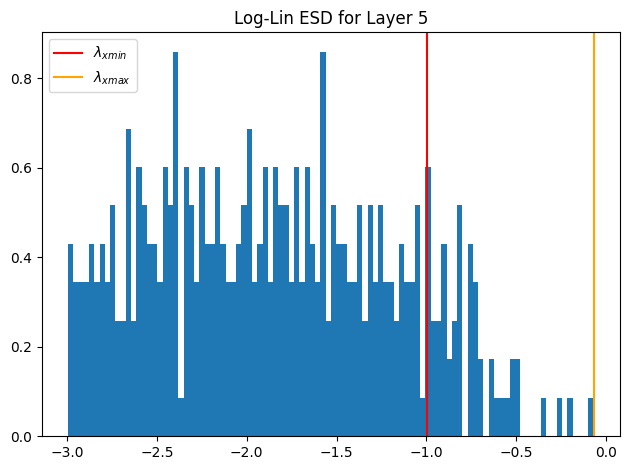

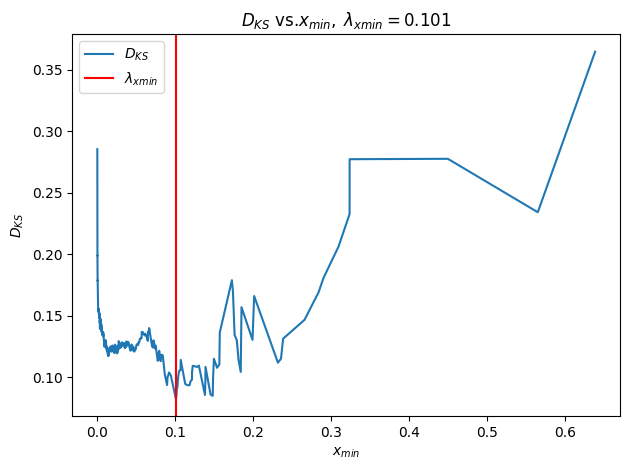

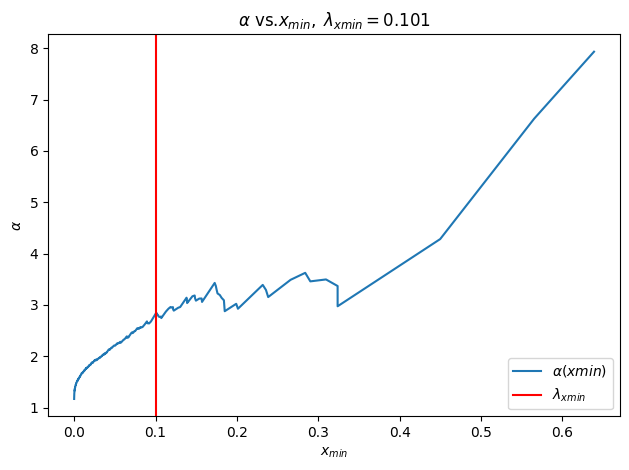

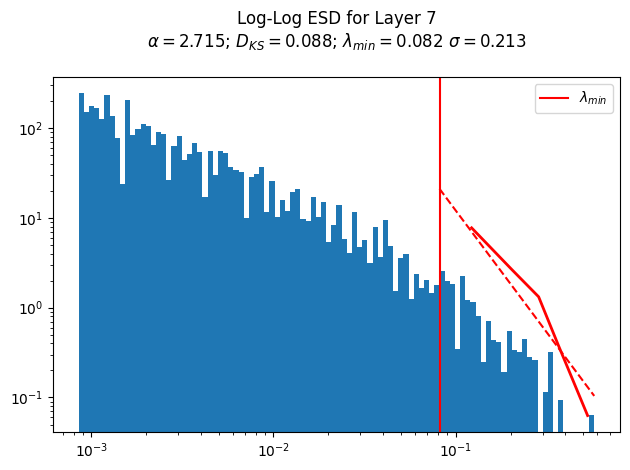

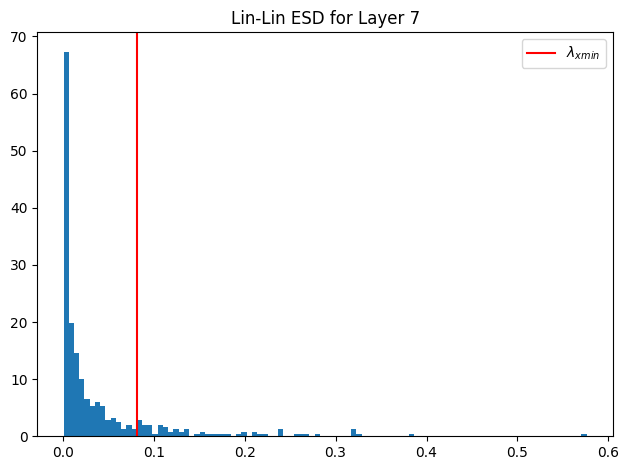

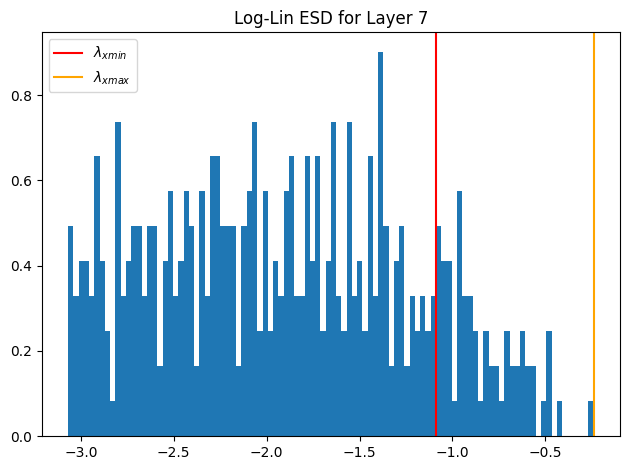

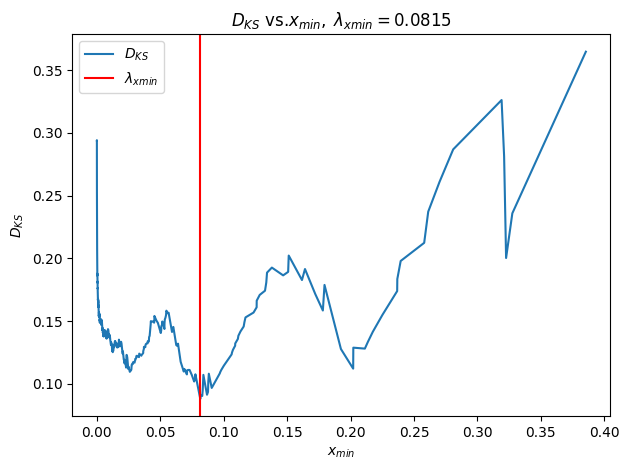

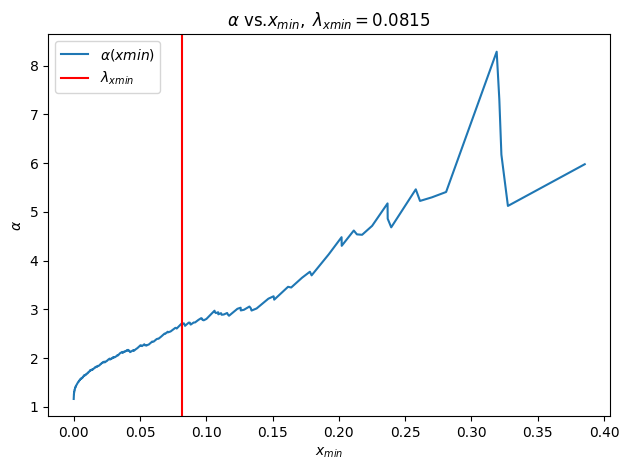

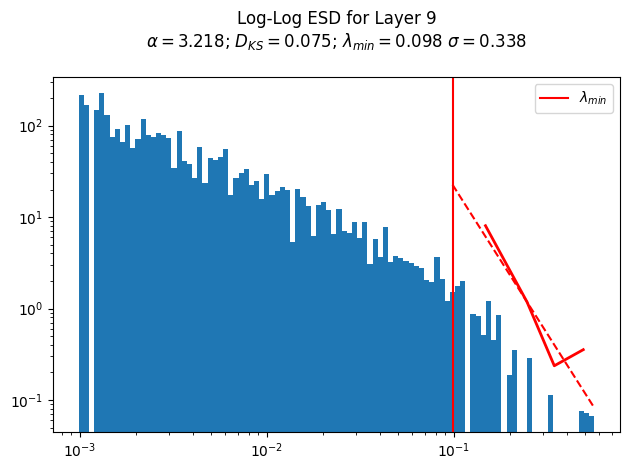

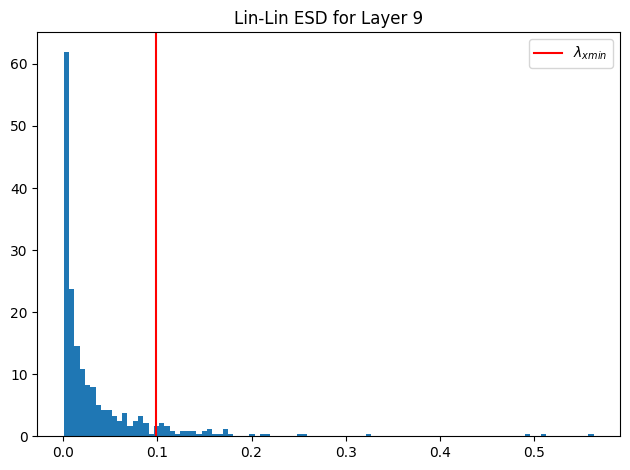

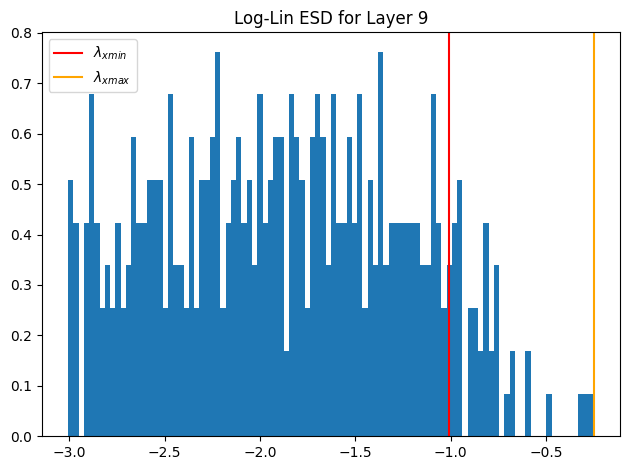

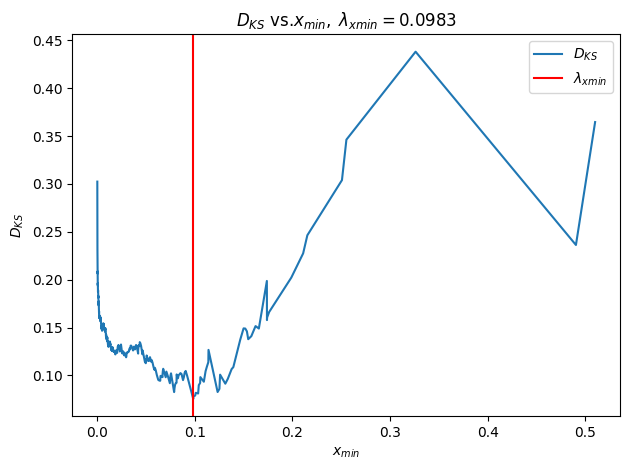

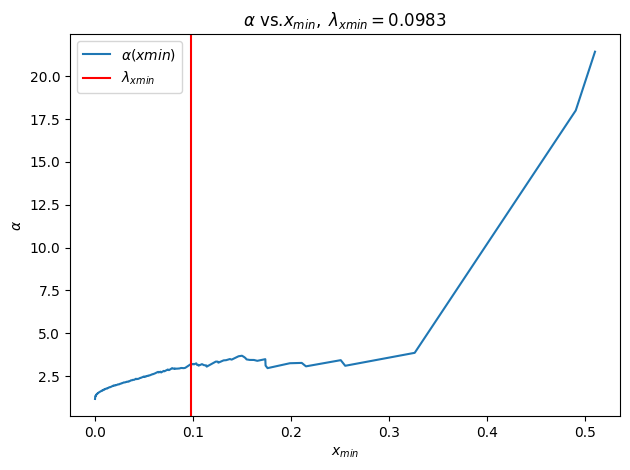

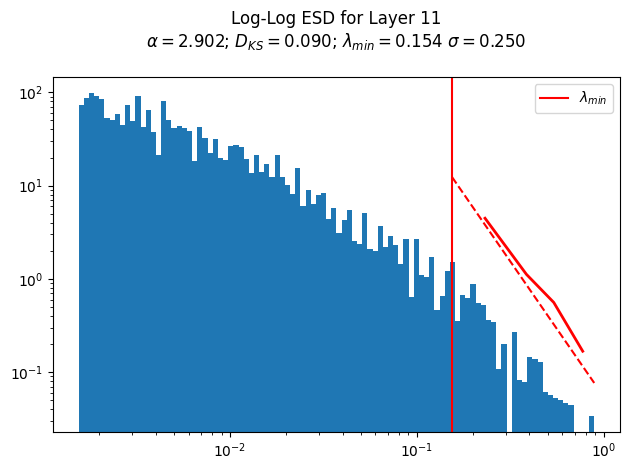

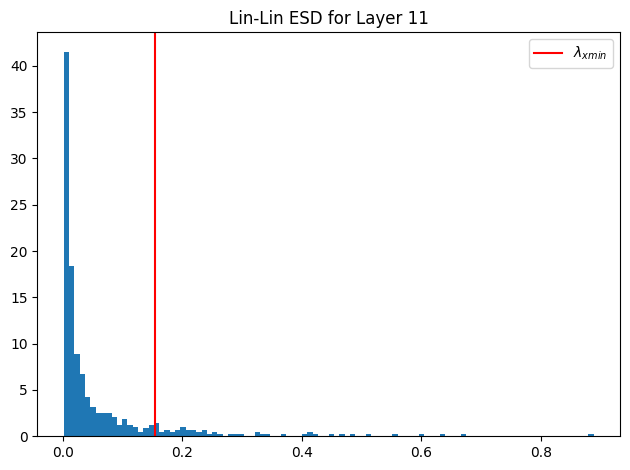

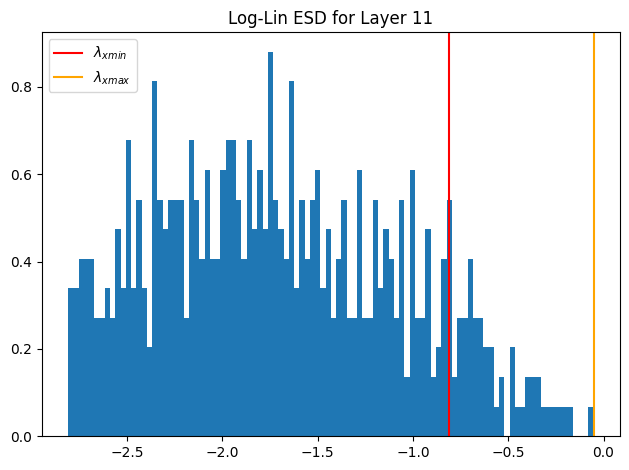

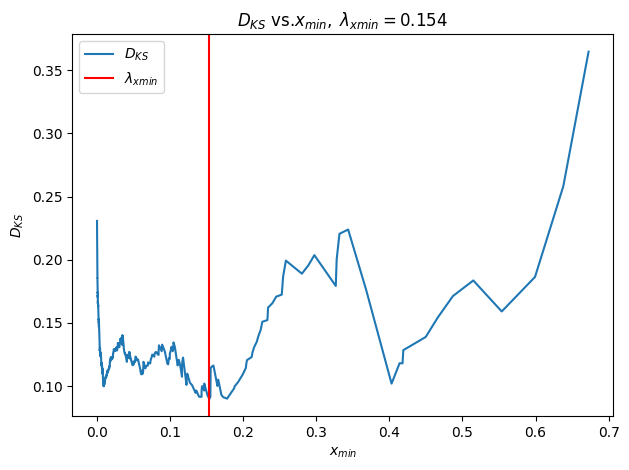

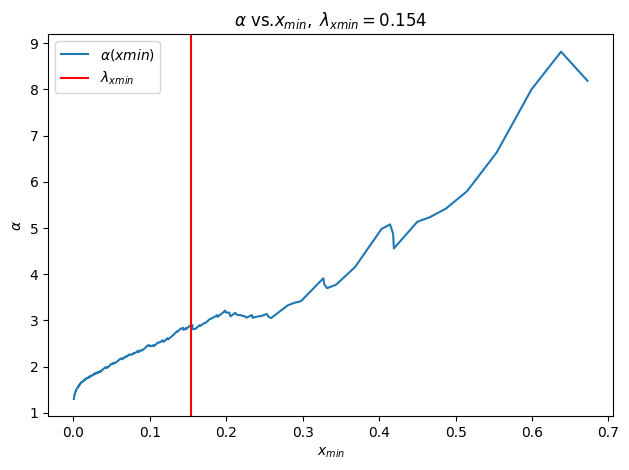

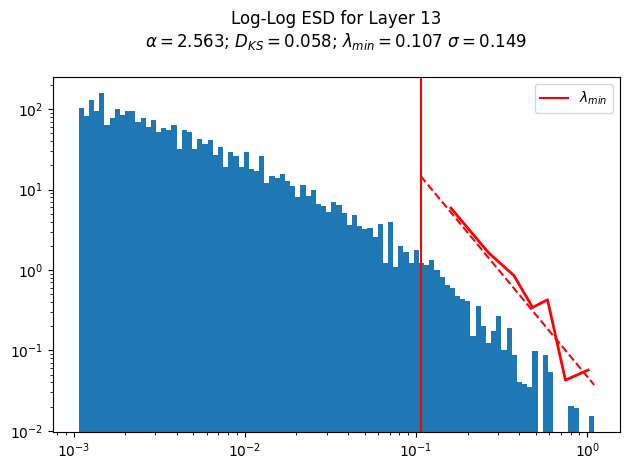

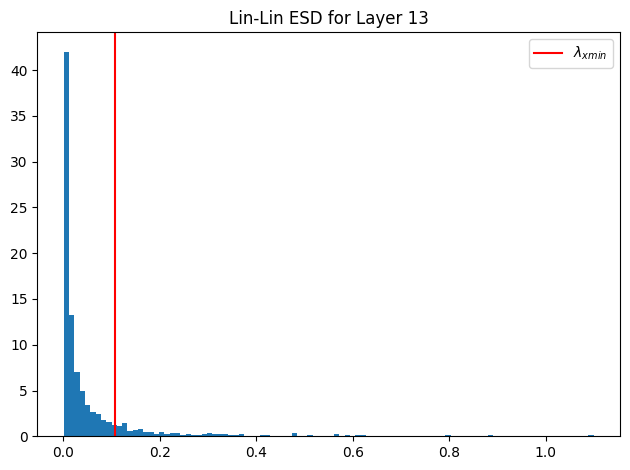

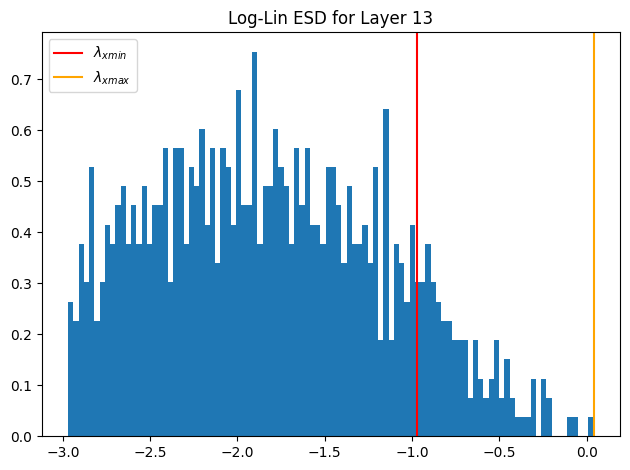

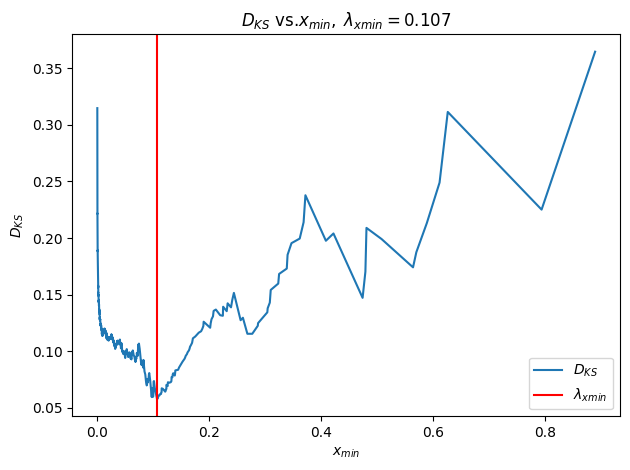

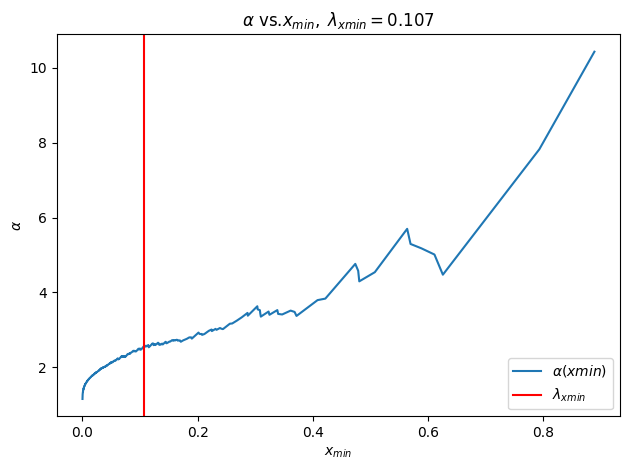

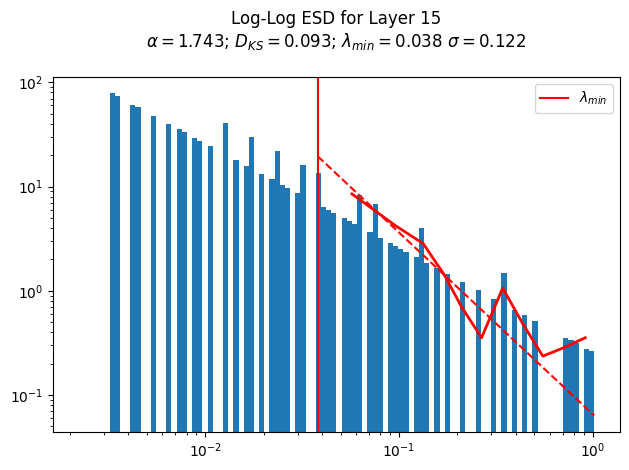

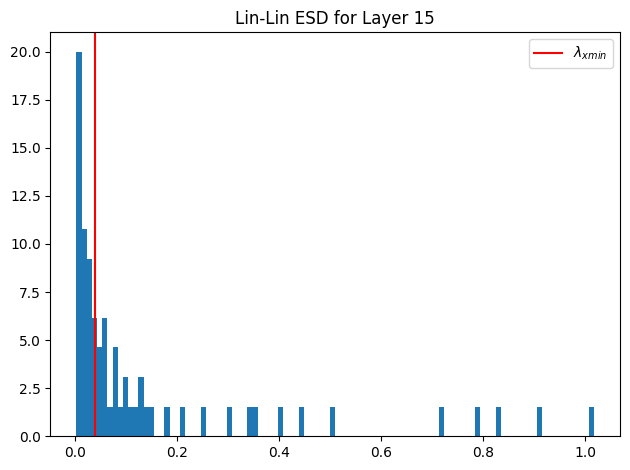

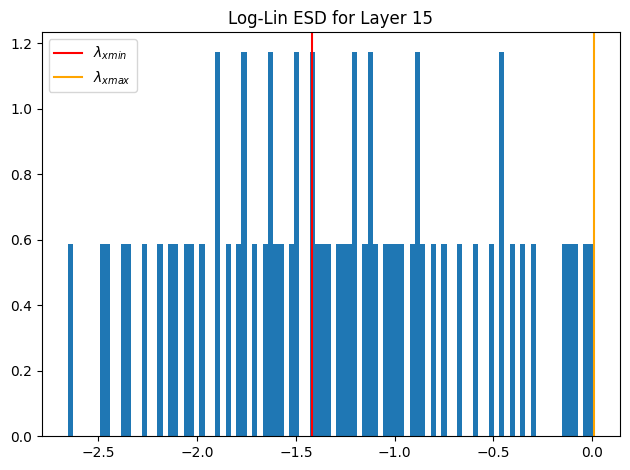

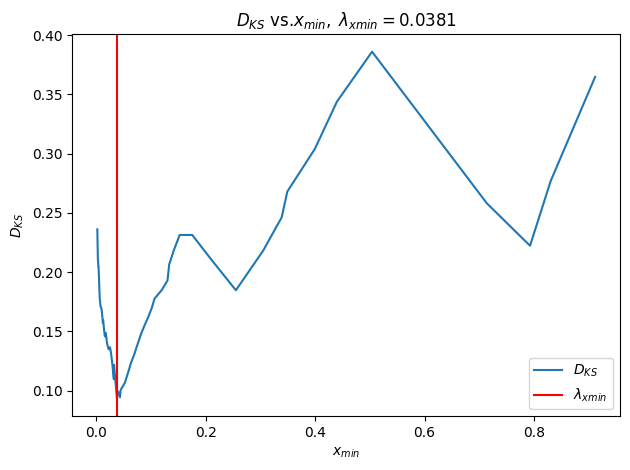

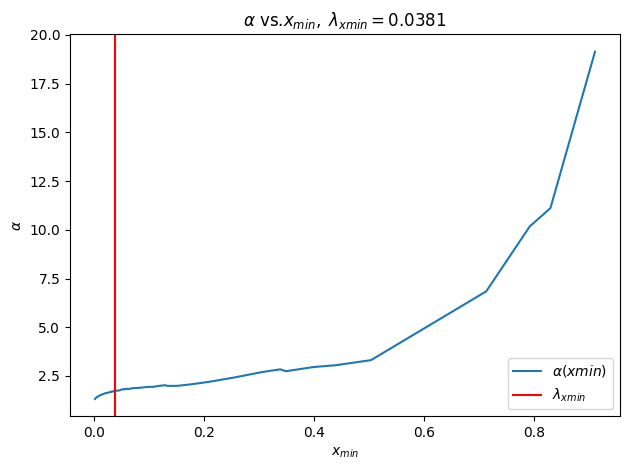

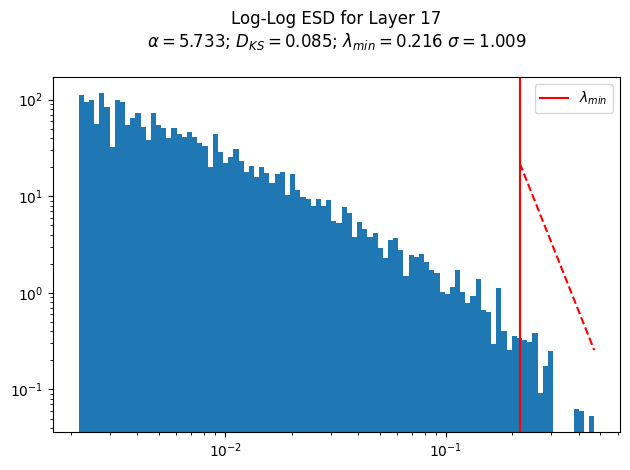

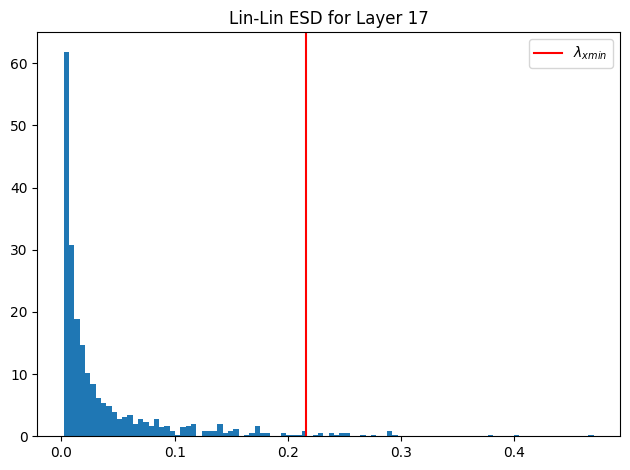

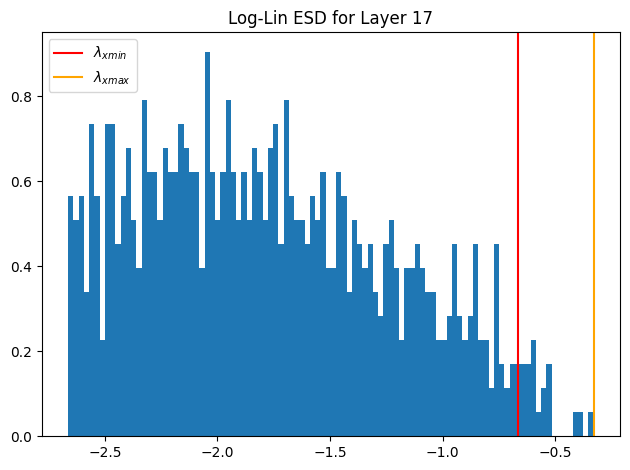

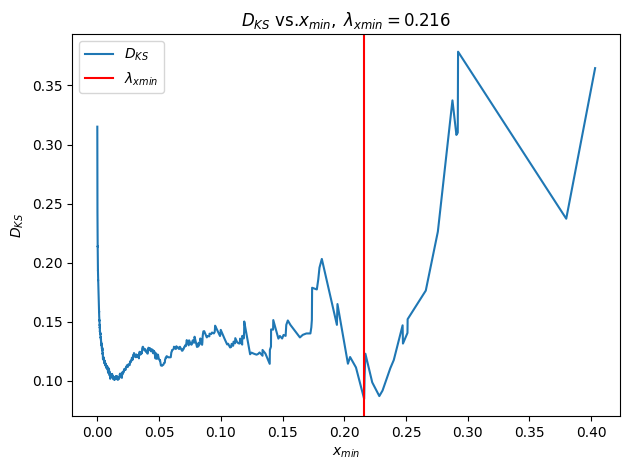

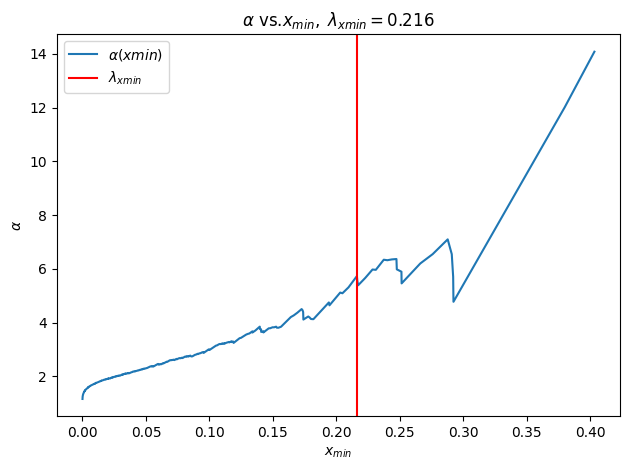

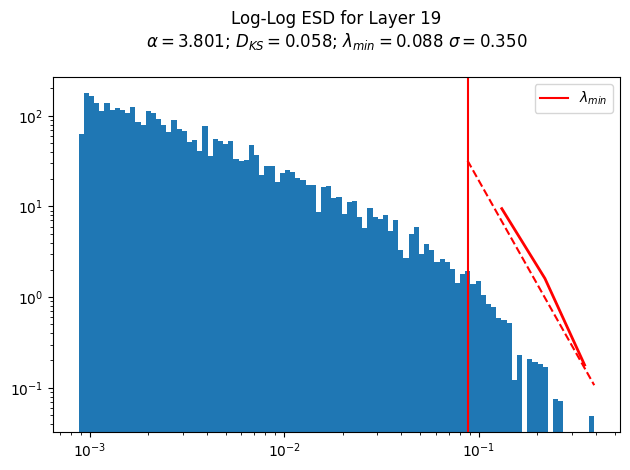

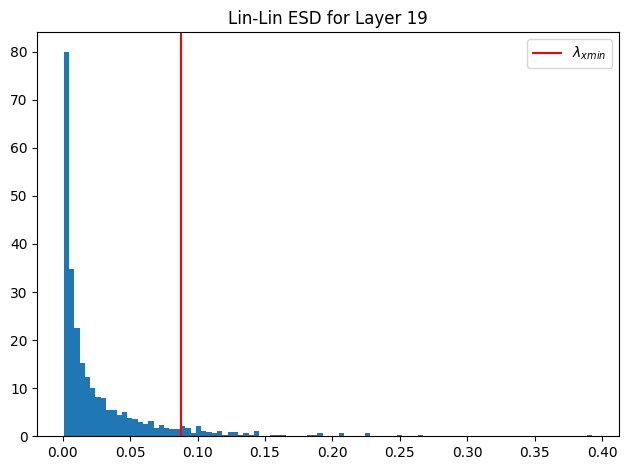

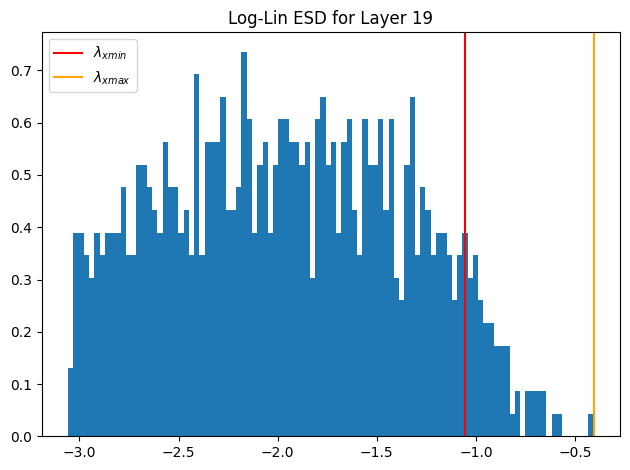

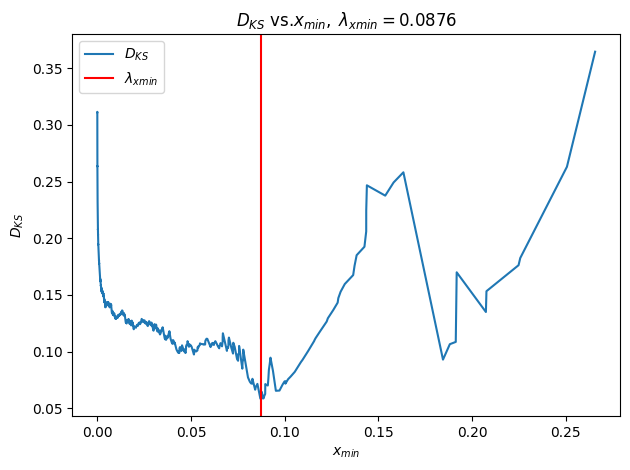

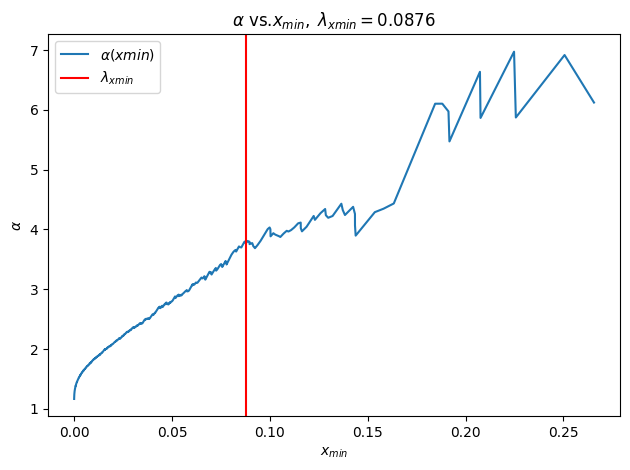

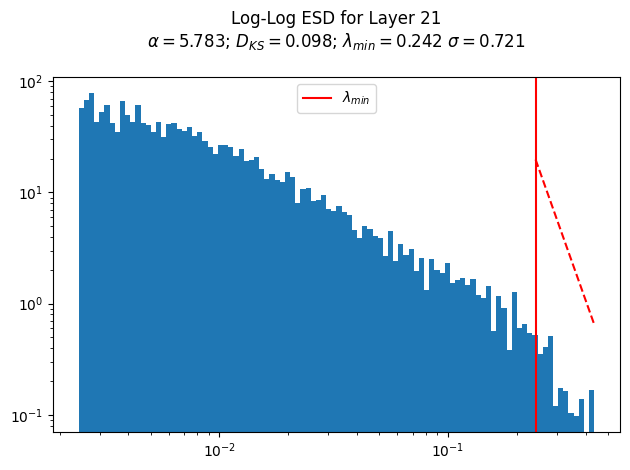

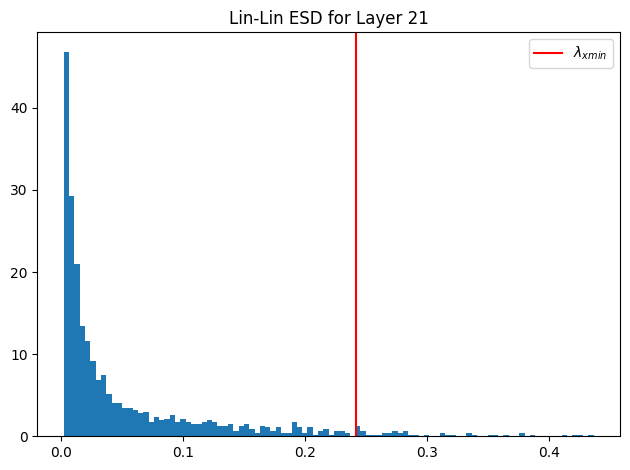

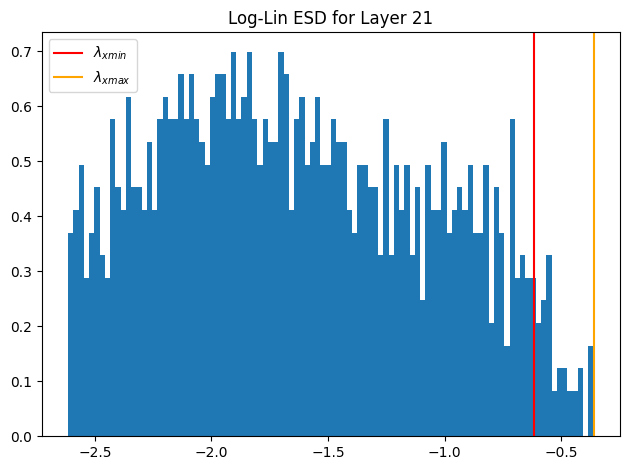

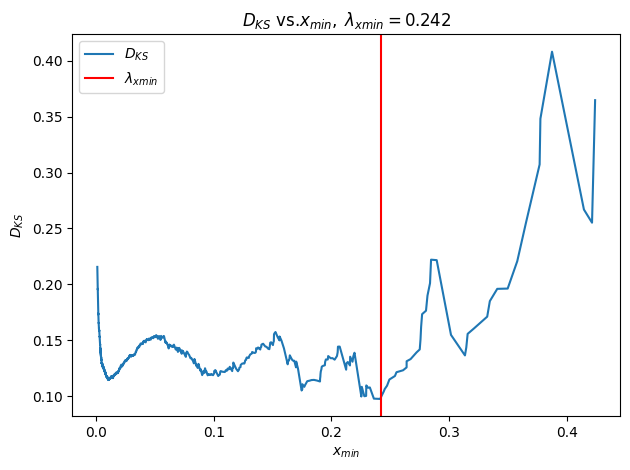

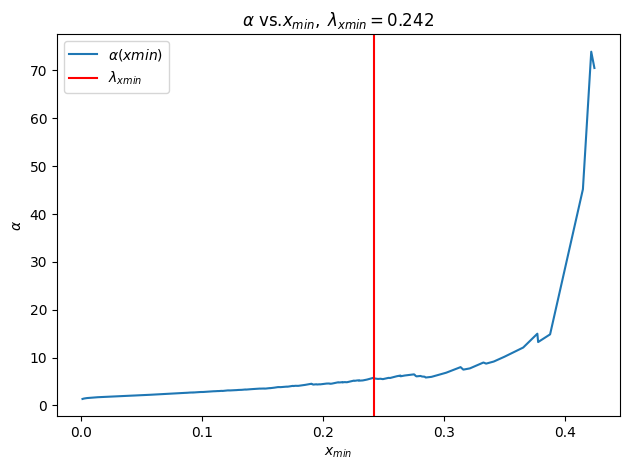

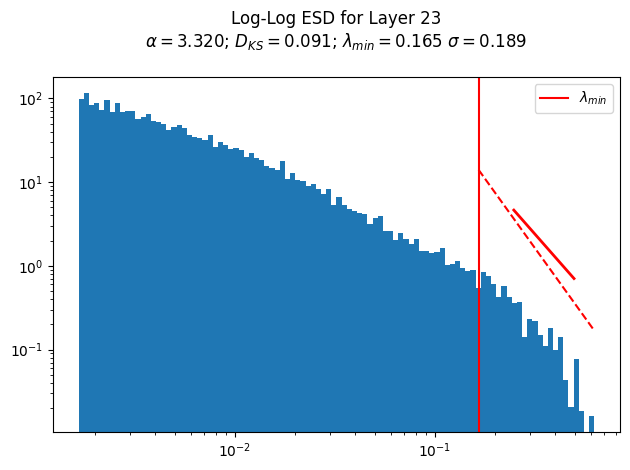

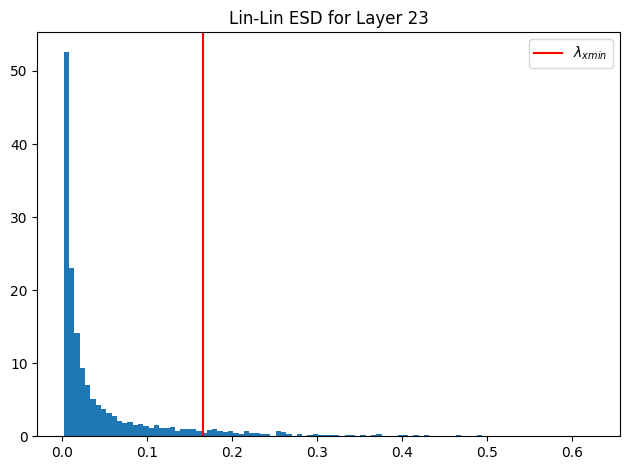

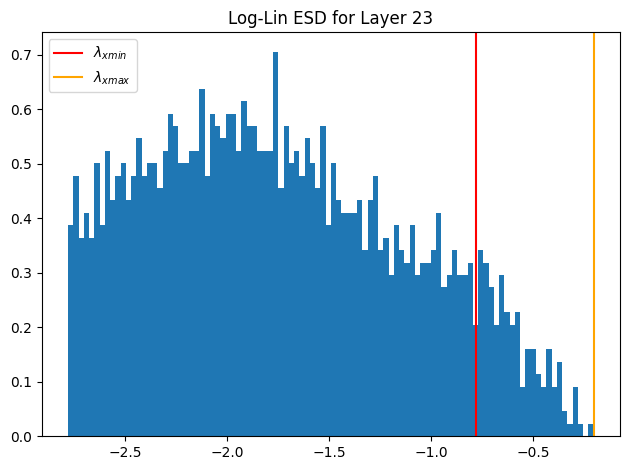

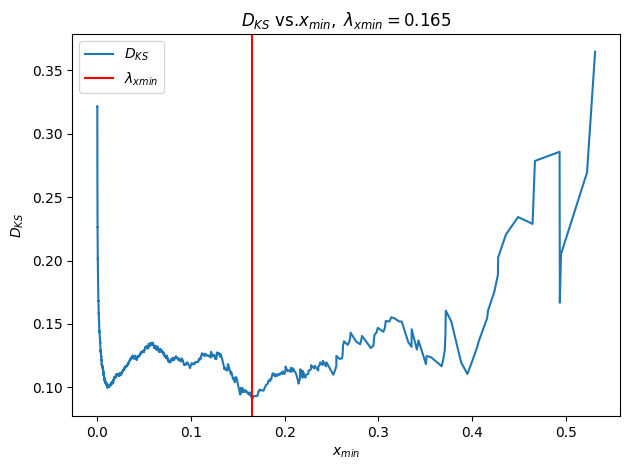

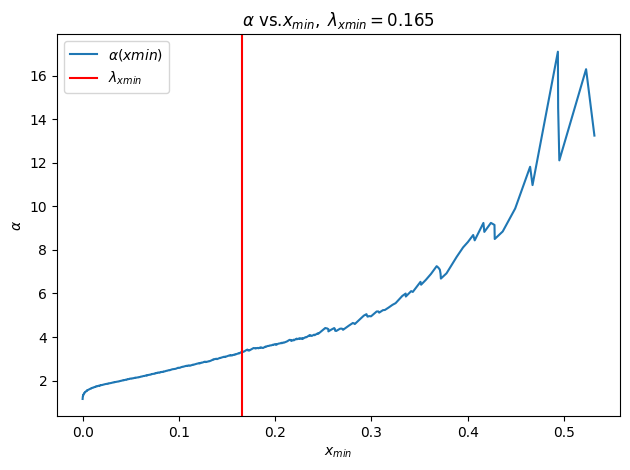

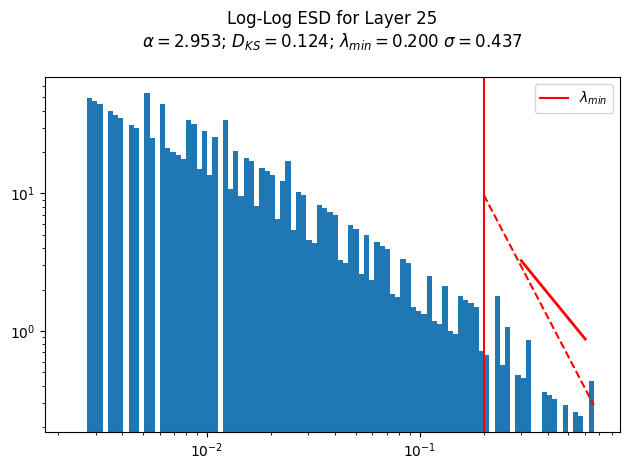

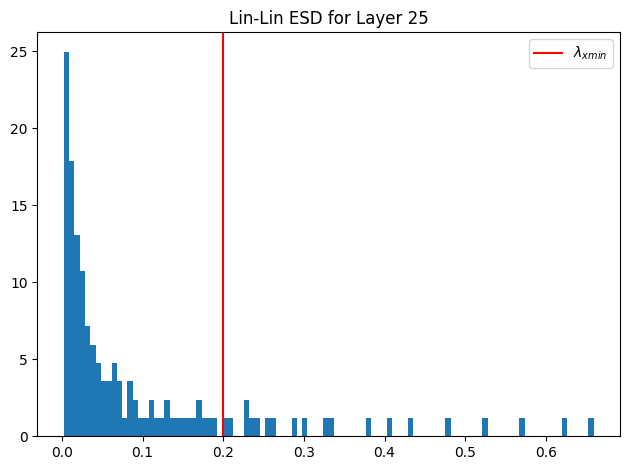

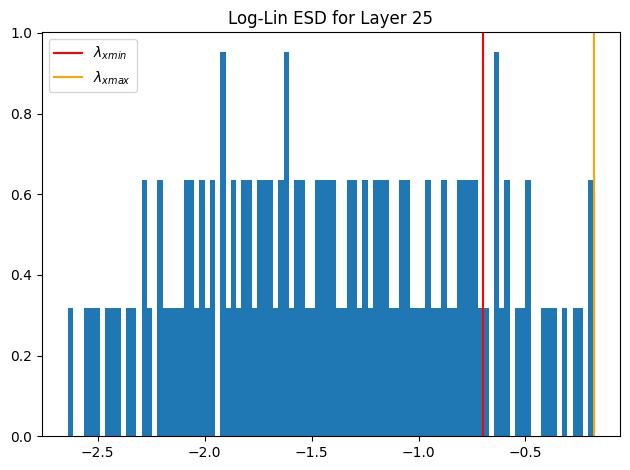

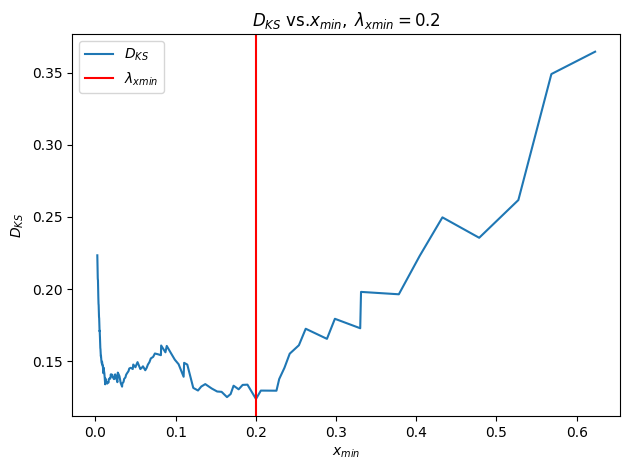

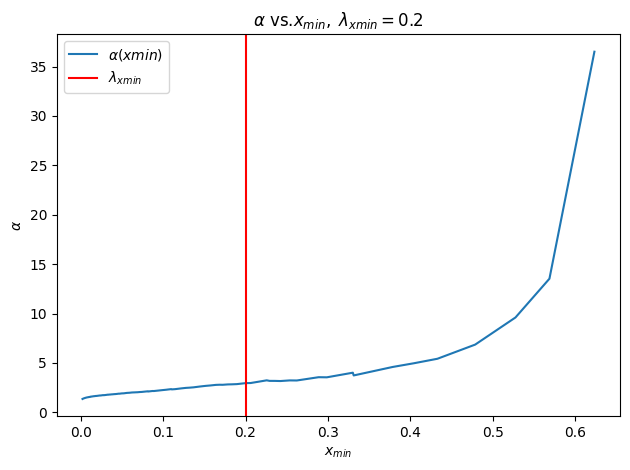

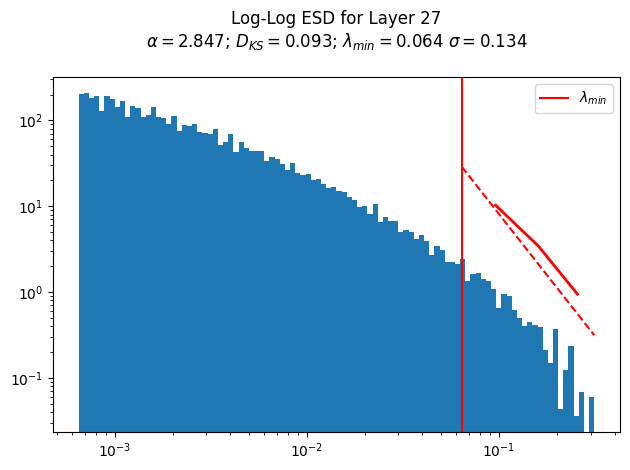

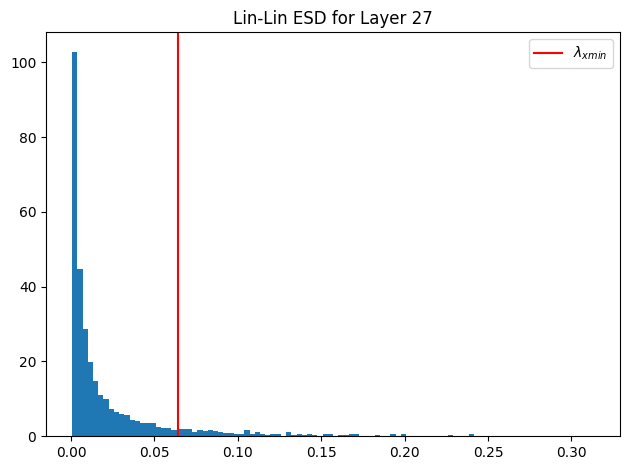

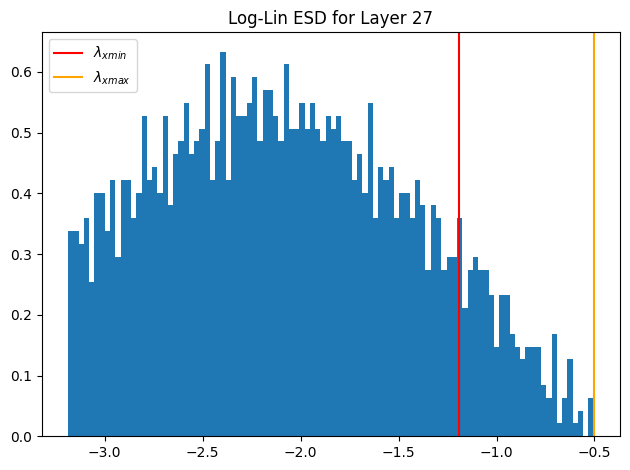

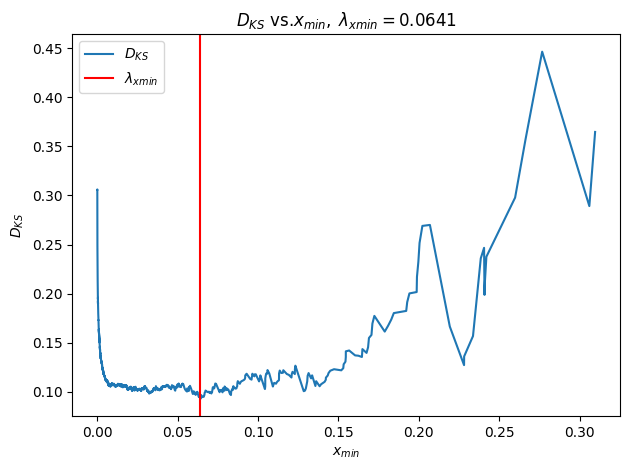

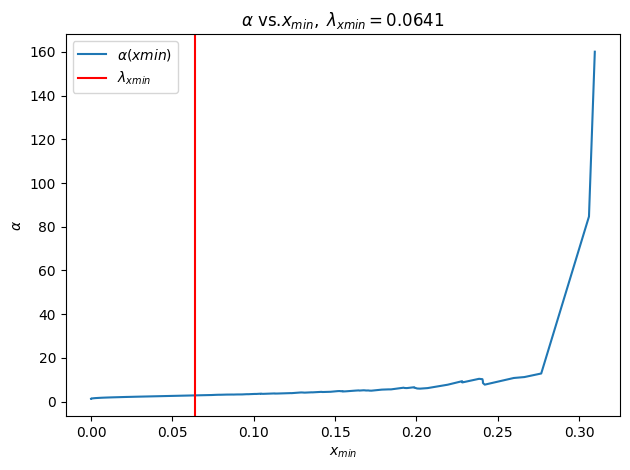

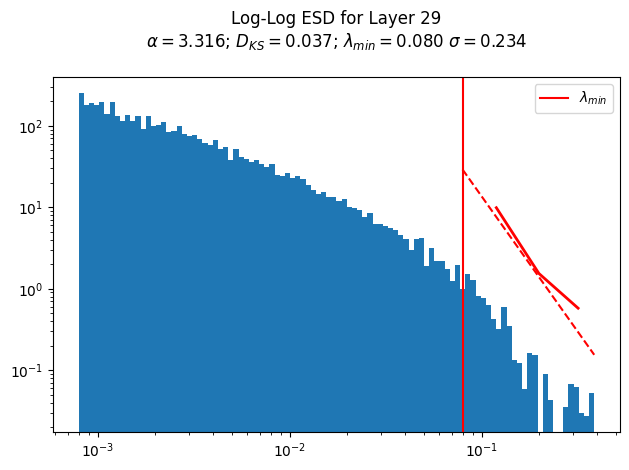

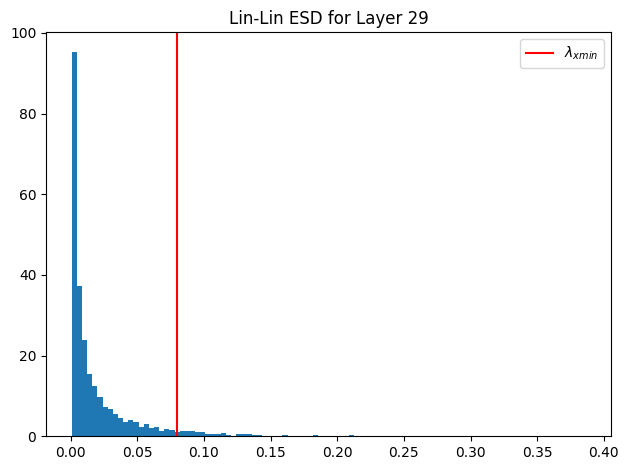

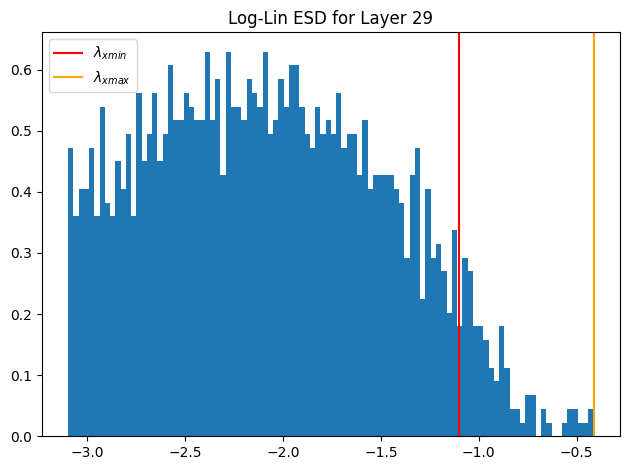

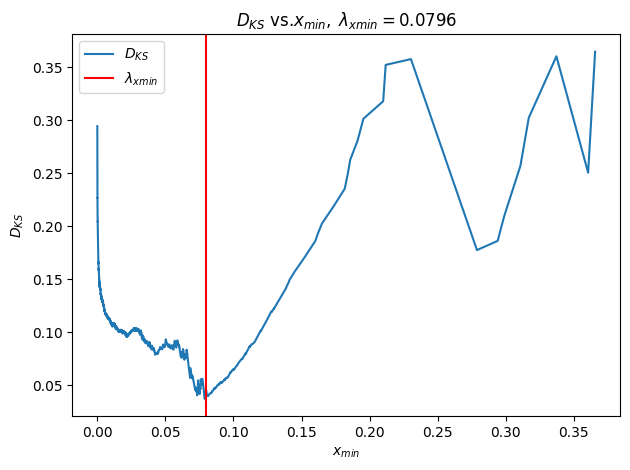

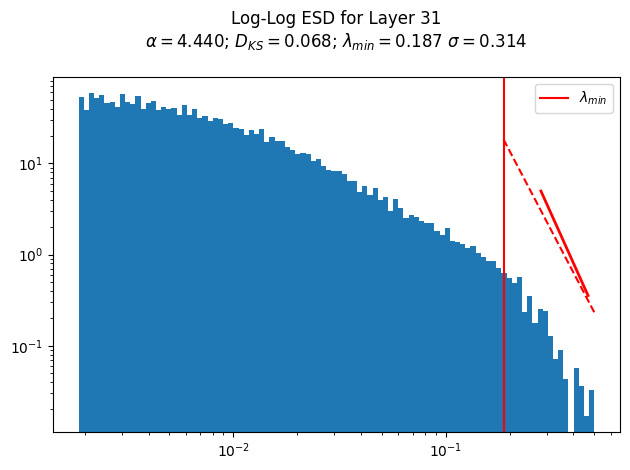

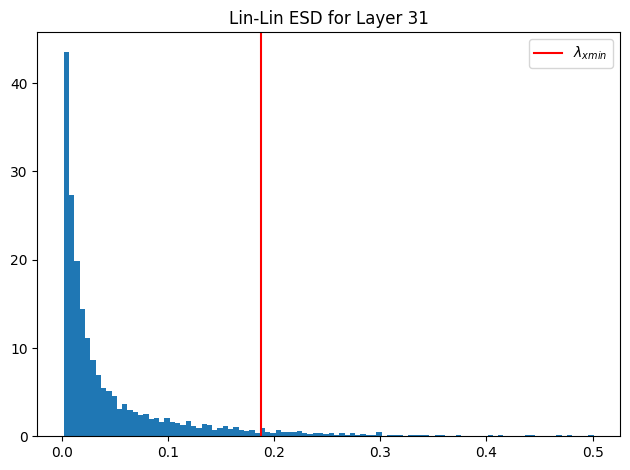

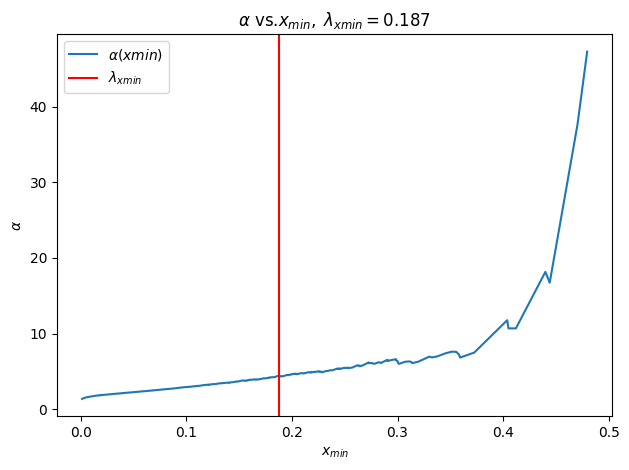

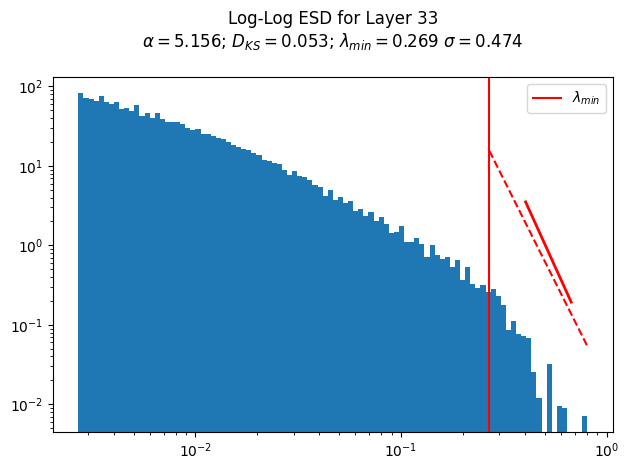

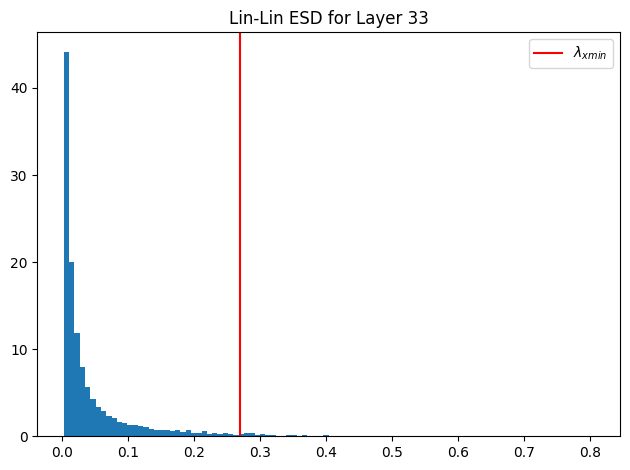

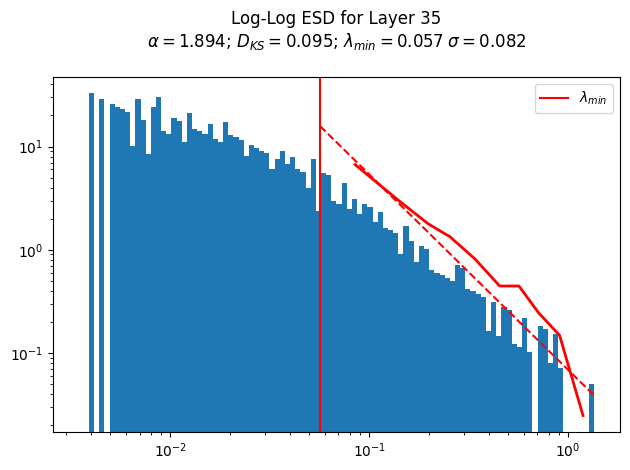

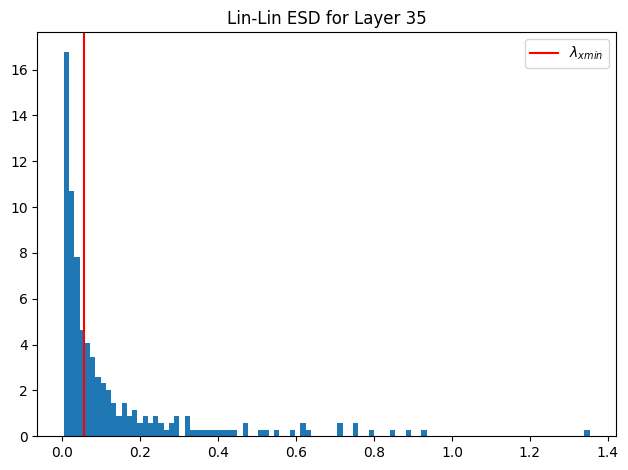

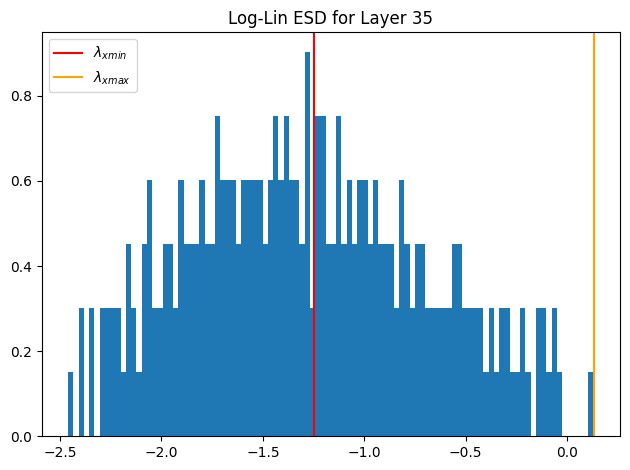

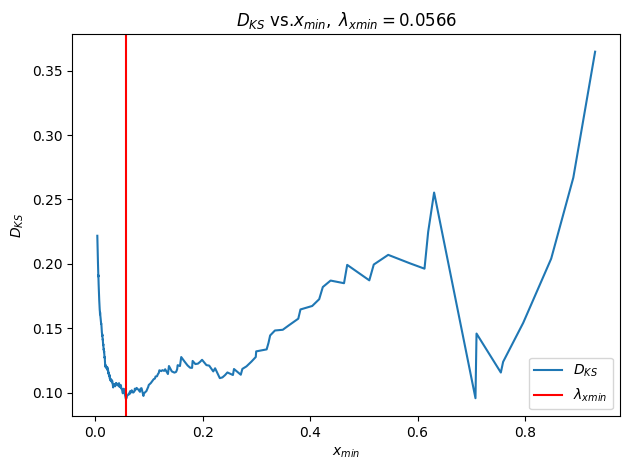

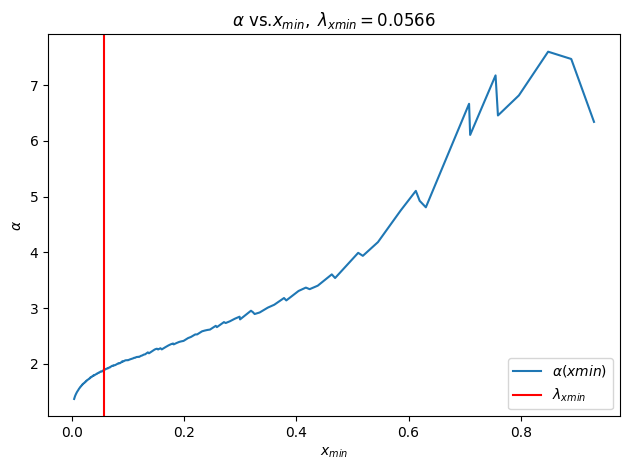

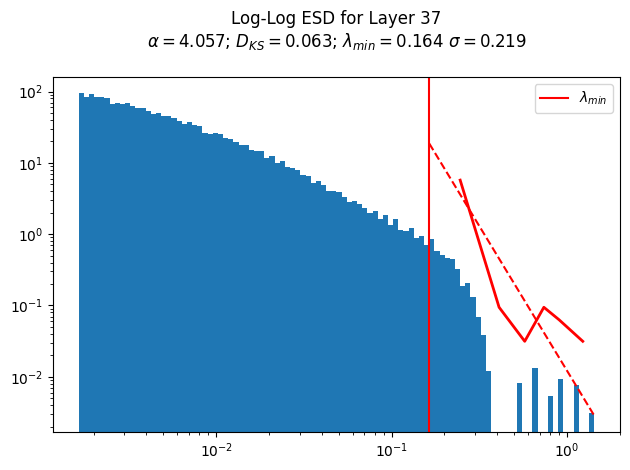

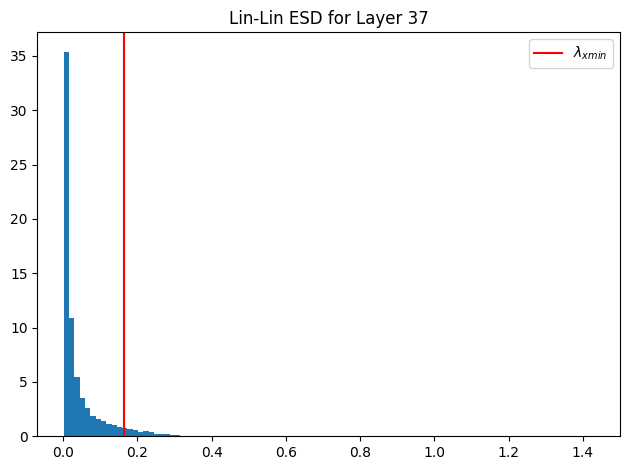

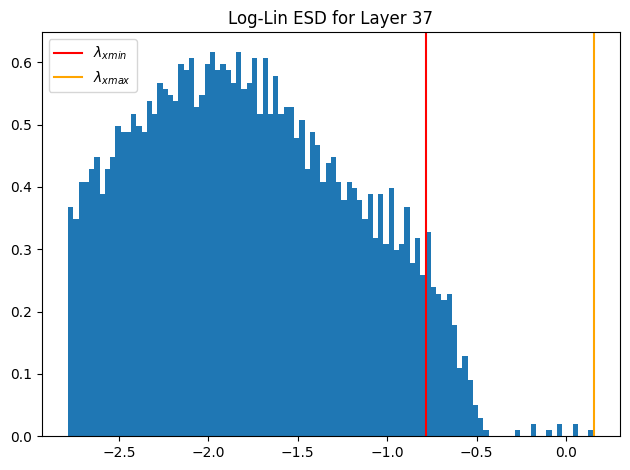

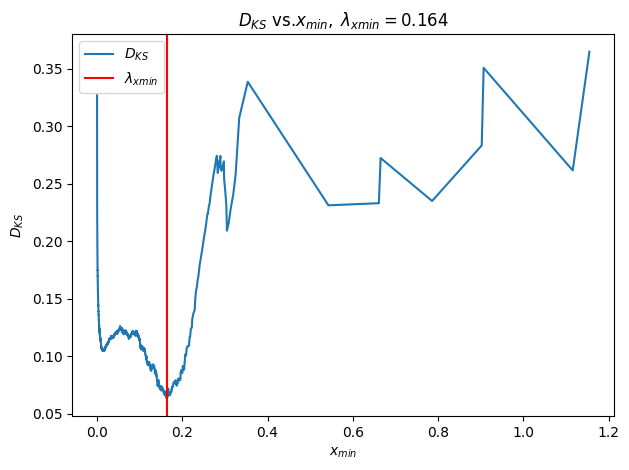

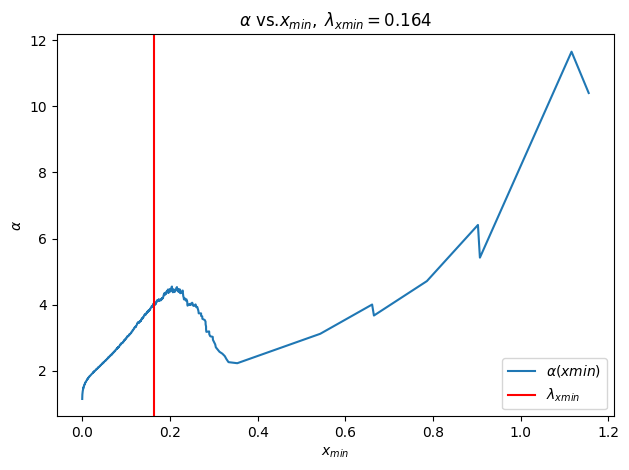

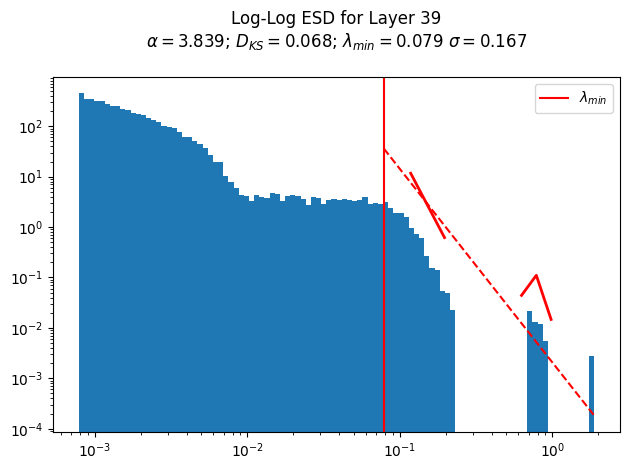

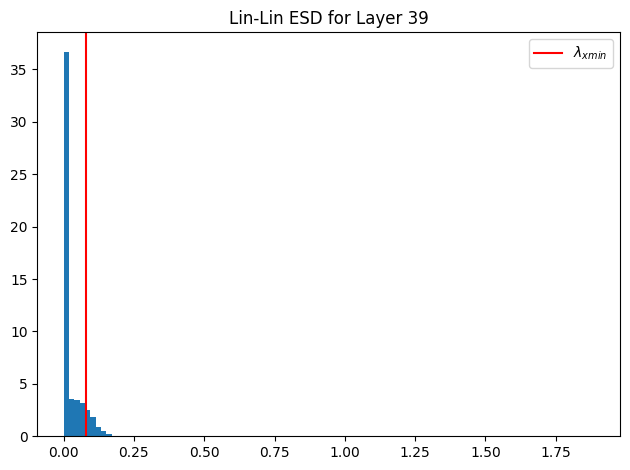

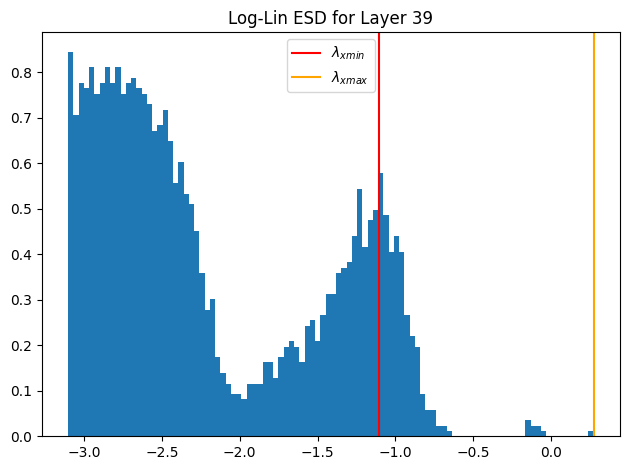

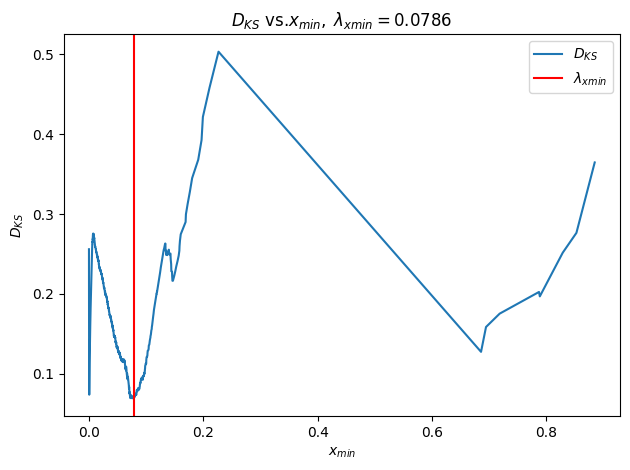

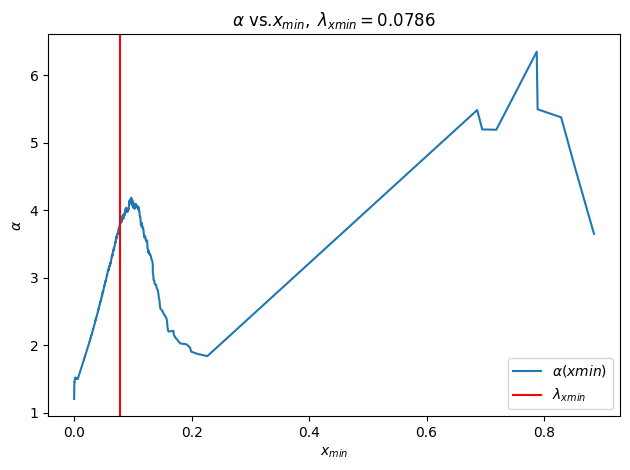

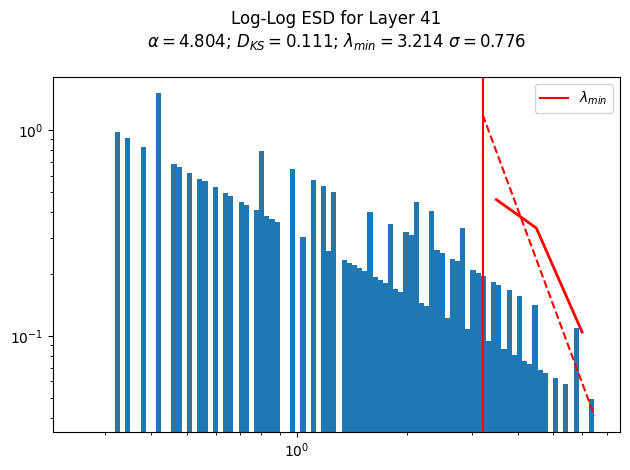

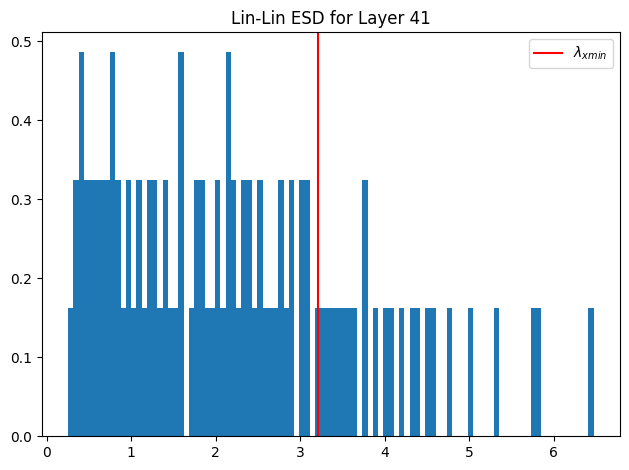

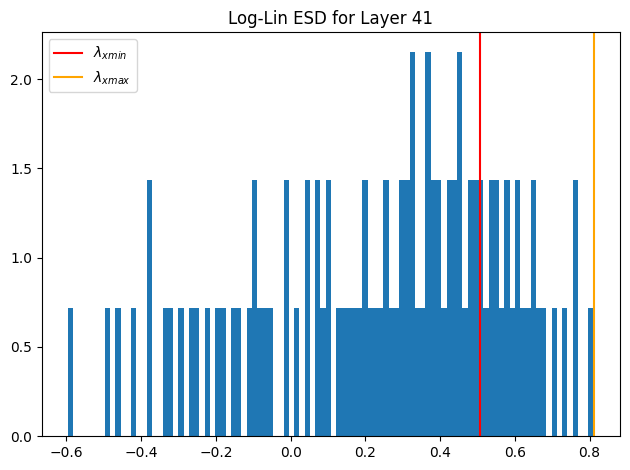

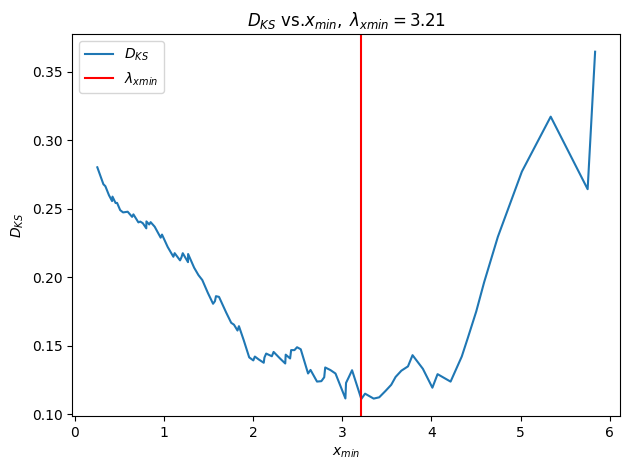

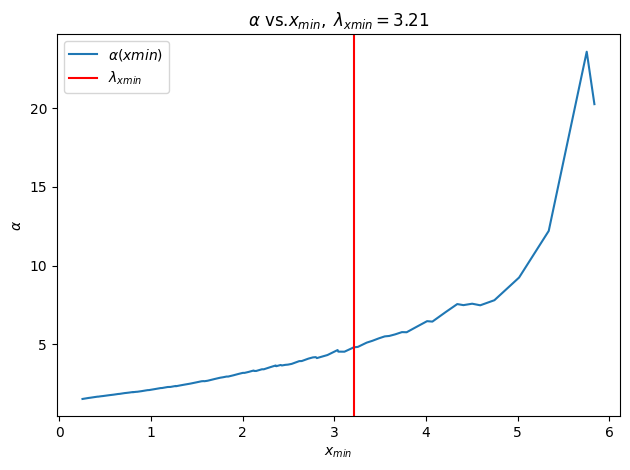

✅ Saved 1 plots in /home/amar/Desktop/DeepFake1M/plots1/epoch_1


In [115]:
import os
import torch
import weightwatcher as ww
import matplotlib.pyplot as plt

# === PATHS ===
checkpoint_path = "/home/amar/Desktop/DeepFake1M/checkpoints/epoch_49.pth"
output_folder = "/home/amar/Desktop/DeepFake1M/plots1/epoch_1"
os.makedirs(output_folder, exist_ok=True)

print("Processing epoch_1.pth...")

try:
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
    state_dict = checkpoint['model_state_dict']

    # Init WeightWatcher with state_dict
    watcher = ww.WeightWatcher(model=state_dict)

    # Run analysis with plotting
    _ = watcher.analyze(plot=True)

    # Save plots
    for idx, fig_num in enumerate(plt.get_fignums()):
        fig = plt.figure(fig_num)
        plot_path = os.path.join(output_folder, f"plot_{idx+1}.png")
        fig.savefig(plot_path)

    plt.close('all')
    print(f"✅ Saved {idx+1} plots in {output_folder}")

except Exception as e:
    print(f"❌ Error processing checkpoint: {e}")


In [1]:
import os
import shutil

# Base directory containing all epoch folders
base_dir = "/home/amar/Desktop/DeepFake1M/esd_ww"

# Number of epoch folders (adjust if needed)
total_epochs = 49

for epoch_num in range(1, total_epochs + 1):
    epoch_folder = f"ww-img_epoch{epoch_num}"
    source_path = os.path.join(base_dir, epoch_folder)
    dest_path = os.path.join(base_dir, f"{epoch_folder}_esd_only")

    # Create destination folder if it doesn't exist
    os.makedirs(dest_path, exist_ok=True)

    # Process files in each epoch folder
    for filename in os.listdir(source_path):
        # Match pattern: ends with .esd.png and nothing after ".esd"
        if filename.endswith(".esd.png") and not any(char.isdigit() for char in filename.split(".esd")[1]):
            full_src = os.path.join(source_path, filename)
            full_dst = os.path.join(dest_path, filename)
            shutil.move(full_src, full_dst)
            print(f"Moved: {filename} → {dest_path}")

print("✅ All .esd.png files moved to respective folders.")


Moved: ww.layer11.esd.png → /home/amar/Desktop/DeepFake1M/esd_ww/ww-img_epoch1_esd_only
Moved: ww.layer9.esd.png → /home/amar/Desktop/DeepFake1M/esd_ww/ww-img_epoch1_esd_only
Moved: ww.layer35.esd.png → /home/amar/Desktop/DeepFake1M/esd_ww/ww-img_epoch1_esd_only
Moved: ww.layer7.esd.png → /home/amar/Desktop/DeepFake1M/esd_ww/ww-img_epoch1_esd_only
Moved: ww.layer3.esd.png → /home/amar/Desktop/DeepFake1M/esd_ww/ww-img_epoch1_esd_only
Moved: ww.layer5.esd.png → /home/amar/Desktop/DeepFake1M/esd_ww/ww-img_epoch1_esd_only
Moved: ww.layer17.esd.png → /home/amar/Desktop/DeepFake1M/esd_ww/ww-img_epoch1_esd_only
Moved: ww.layer41.esd.png → /home/amar/Desktop/DeepFake1M/esd_ww/ww-img_epoch1_esd_only
Moved: ww.layer1.esd.png → /home/amar/Desktop/DeepFake1M/esd_ww/ww-img_epoch1_esd_only
Moved: ww.layer27.esd.png → /home/amar/Desktop/DeepFake1M/esd_ww/ww-img_epoch1_esd_only
Moved: ww.layer37.esd.png → /home/amar/Desktop/DeepFake1M/esd_ww/ww-img_epoch1_esd_only
Moved: ww.layer33.esd.png → /home/ama

In [3]:
import os
import imageio
from PIL import Image

# Config
base_dir = "/home/amar/Desktop/DeepFake1M/esd_ww"
epochs = 49
layers = list(range(1, 42, 2))  # layer1,3,...,41
output_dir = os.path.join(base_dir, "layer_animations")
os.makedirs(output_dir, exist_ok=True)

for layer in layers:
    images = []
    for epoch in range(1, epochs + 1):
        folder = f"ww-img_epoch{epoch}_esd_only"
        img_path = os.path.join(base_dir, folder, f"ww.layer{layer}.esd.png")
        
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            images.append(img)
        else:
            print(f"❌ Missing: {img_path}")

    if images:
        gif_path = os.path.join(output_dir, f"layer{layer}_evolution.gif")
        images[0].save(
            gif_path,
            save_all=True,
            append_images=images[1:],
            duration=500,  # ms between frames
            loop=0
        )
        print(f"✅ Saved animation: {gif_path}")
    else:
        print(f"⚠️ No images found for layer{layer}")


✅ Saved animation: /home/amar/Desktop/DeepFake1M/esd_ww/layer_animations/layer1_evolution.gif
✅ Saved animation: /home/amar/Desktop/DeepFake1M/esd_ww/layer_animations/layer3_evolution.gif
✅ Saved animation: /home/amar/Desktop/DeepFake1M/esd_ww/layer_animations/layer5_evolution.gif
✅ Saved animation: /home/amar/Desktop/DeepFake1M/esd_ww/layer_animations/layer7_evolution.gif
✅ Saved animation: /home/amar/Desktop/DeepFake1M/esd_ww/layer_animations/layer9_evolution.gif
✅ Saved animation: /home/amar/Desktop/DeepFake1M/esd_ww/layer_animations/layer11_evolution.gif
✅ Saved animation: /home/amar/Desktop/DeepFake1M/esd_ww/layer_animations/layer13_evolution.gif
✅ Saved animation: /home/amar/Desktop/DeepFake1M/esd_ww/layer_animations/layer15_evolution.gif
✅ Saved animation: /home/amar/Desktop/DeepFake1M/esd_ww/layer_animations/layer17_evolution.gif
✅ Saved animation: /home/amar/Desktop/DeepFake1M/esd_ww/layer_animations/layer19_evolution.gif
✅ Saved animation: /home/amar/Desktop/DeepFake1M/esd_ww

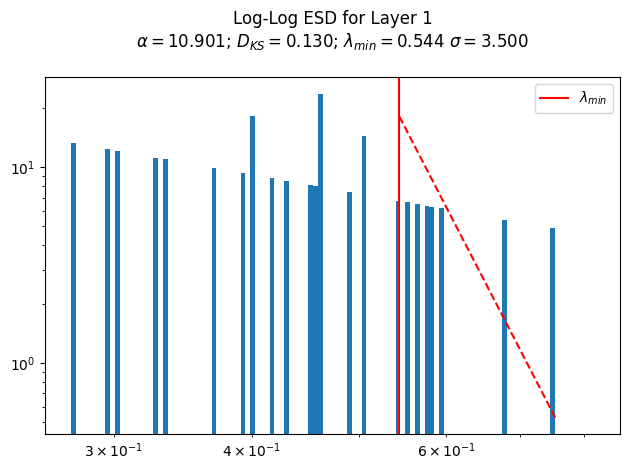

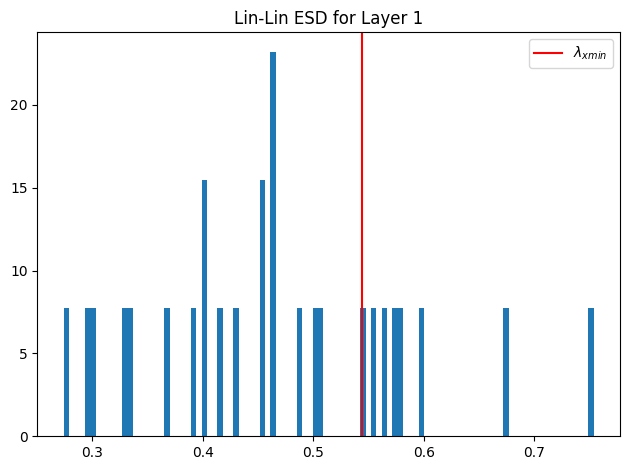

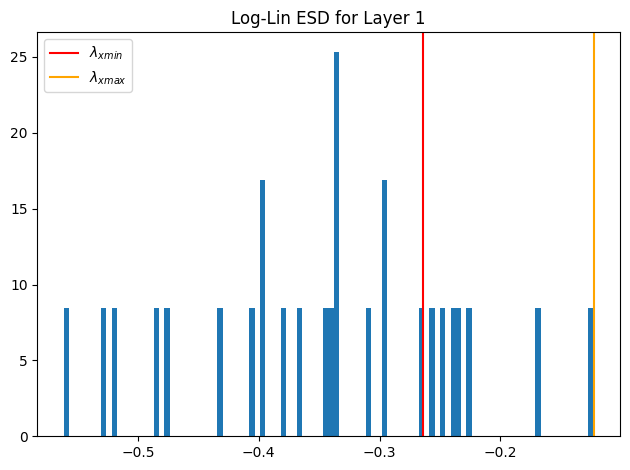

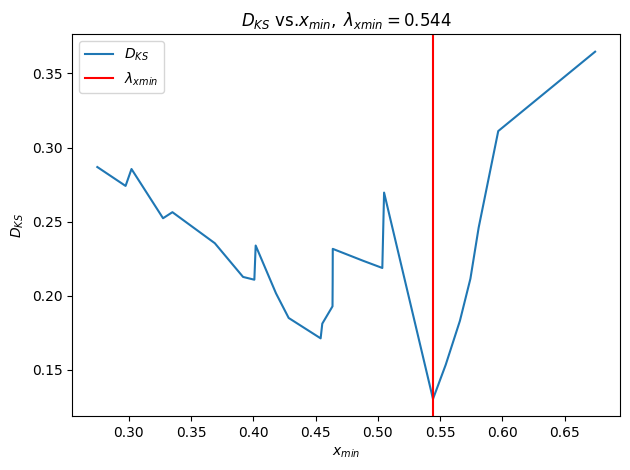

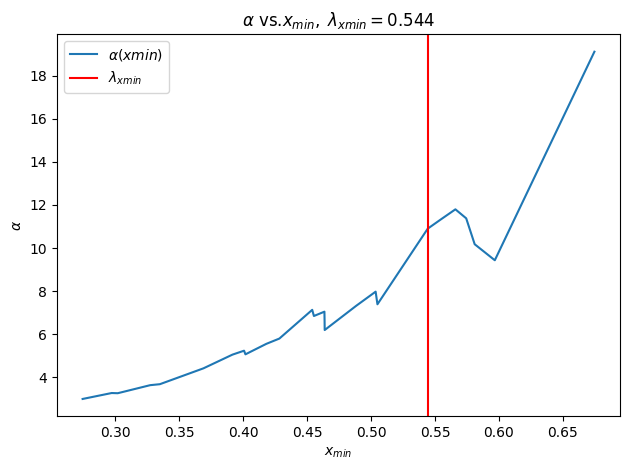

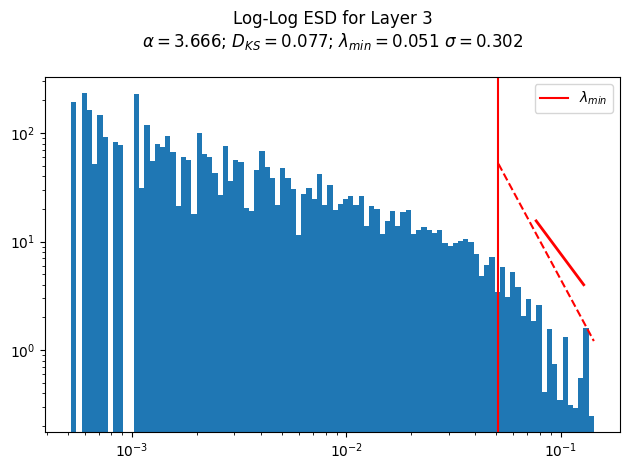

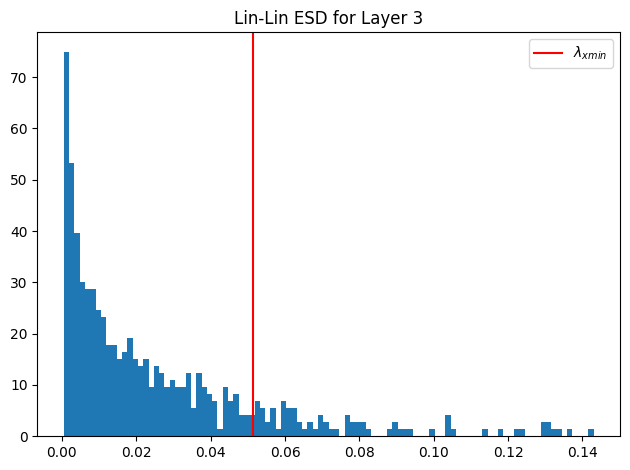

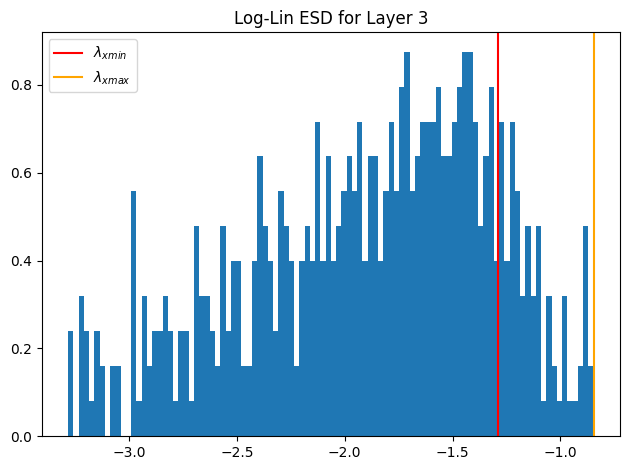

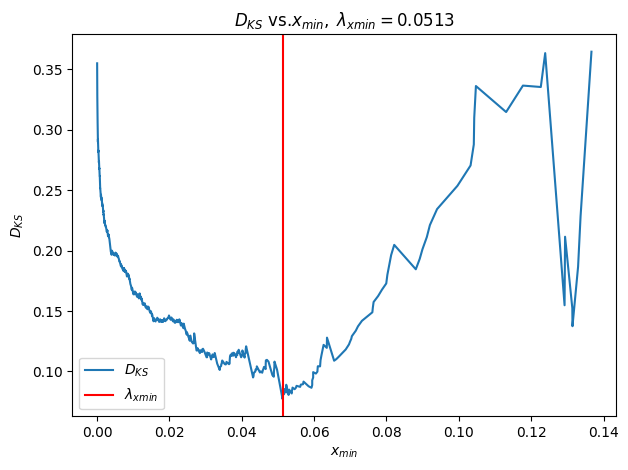

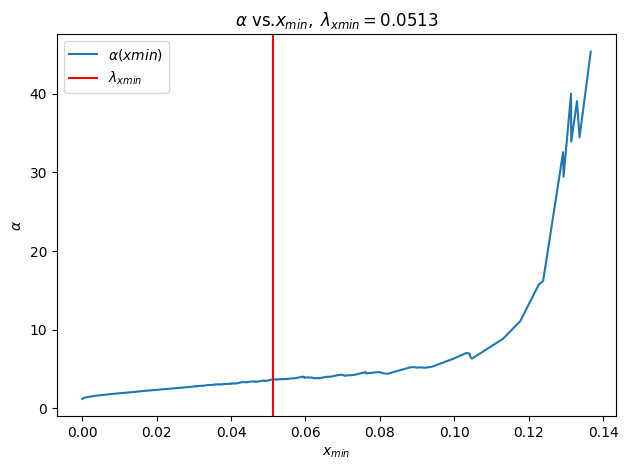

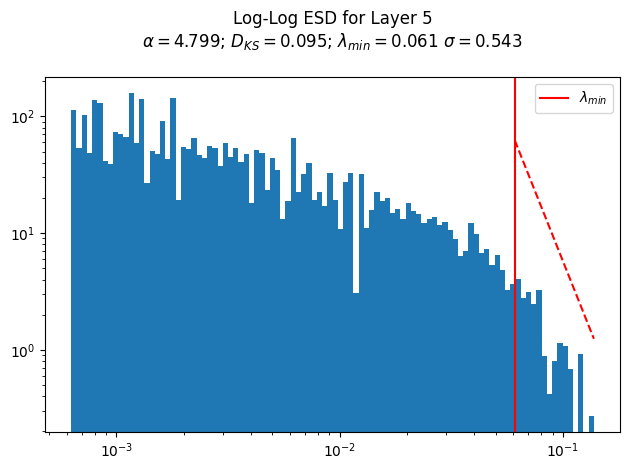

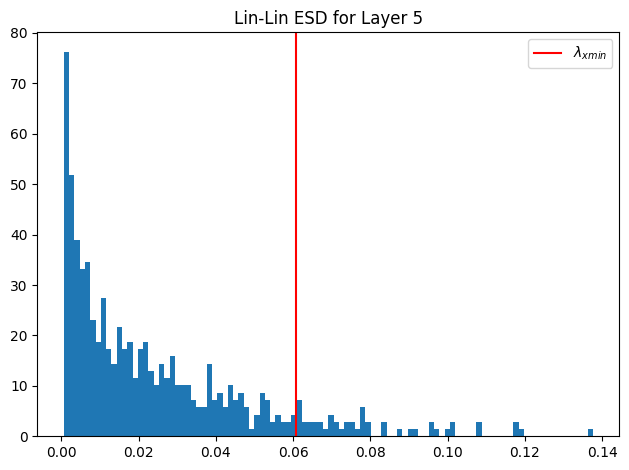

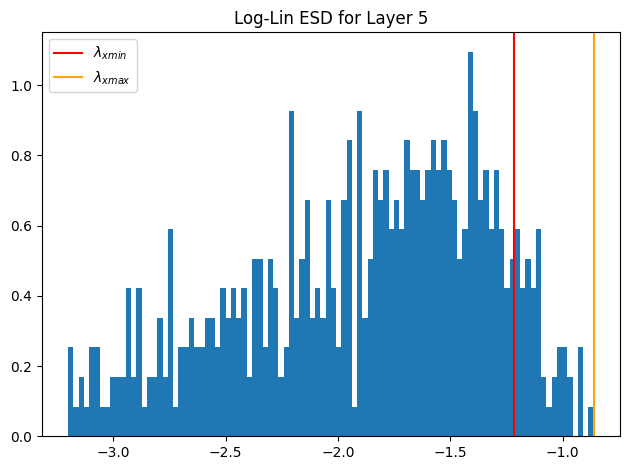

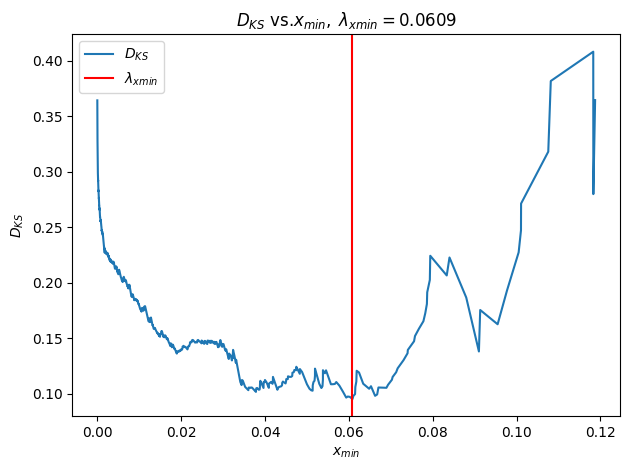

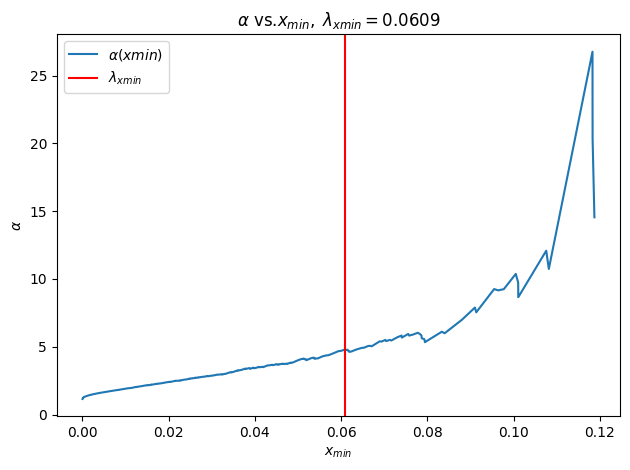

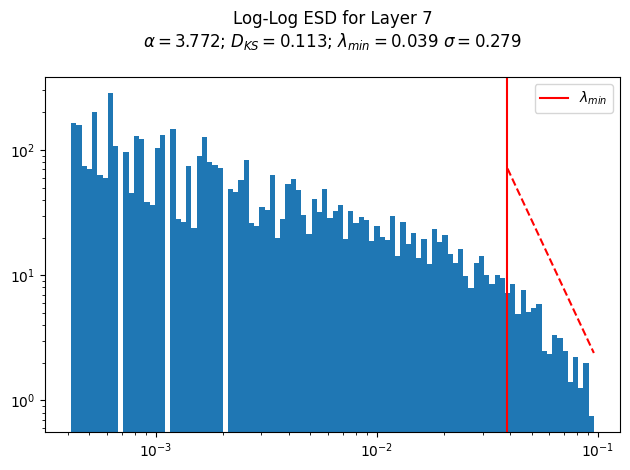

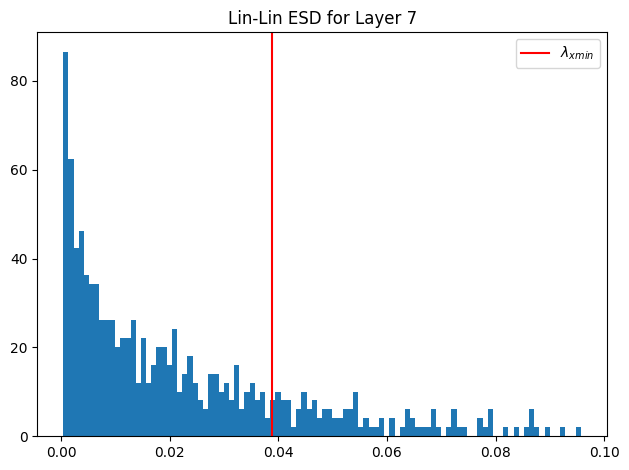

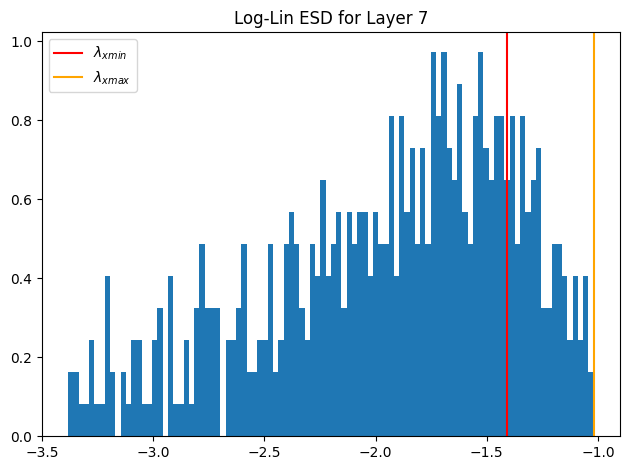

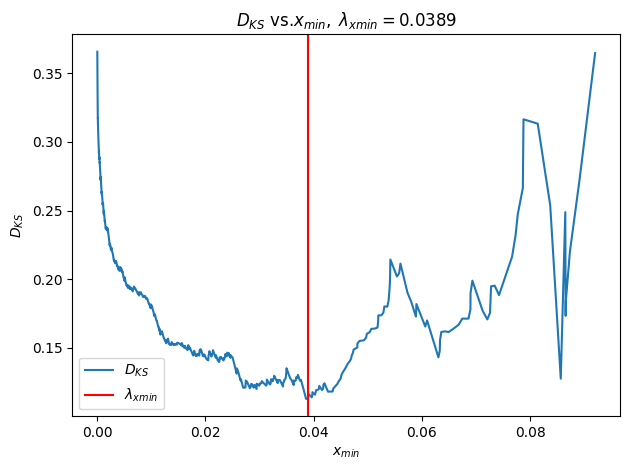

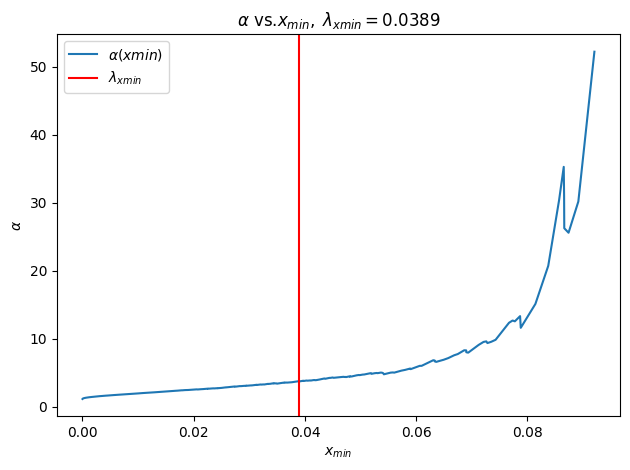

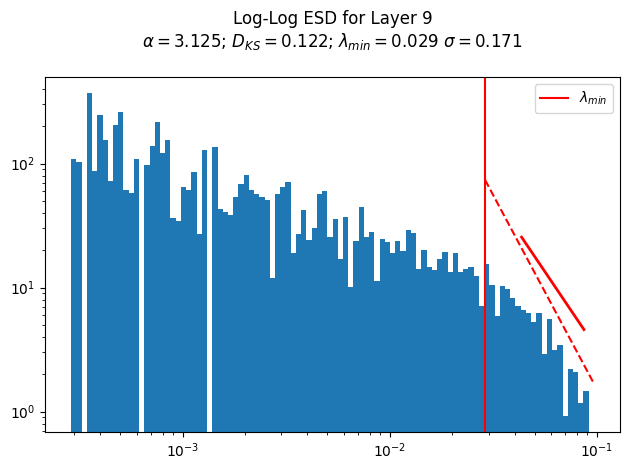

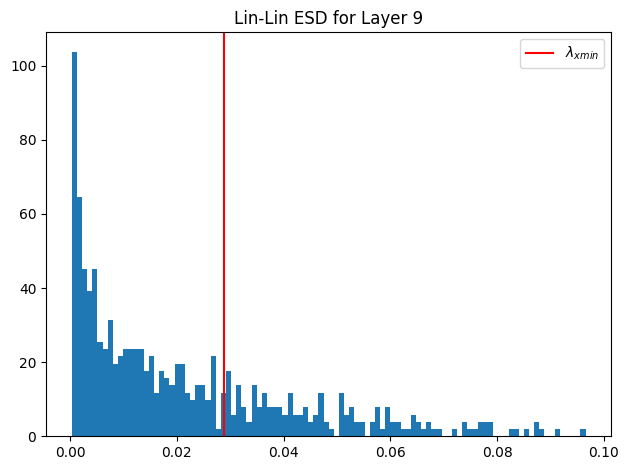

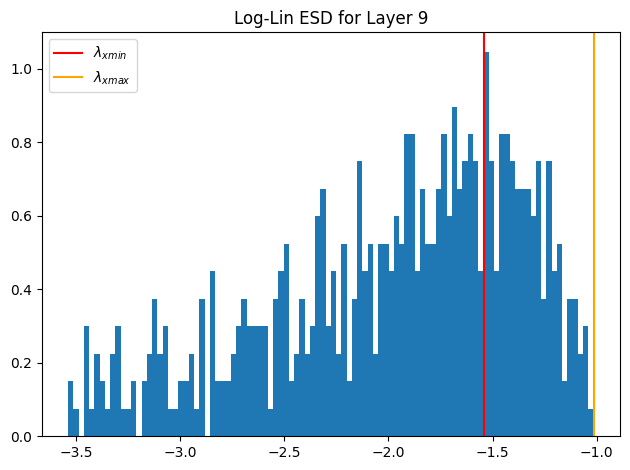

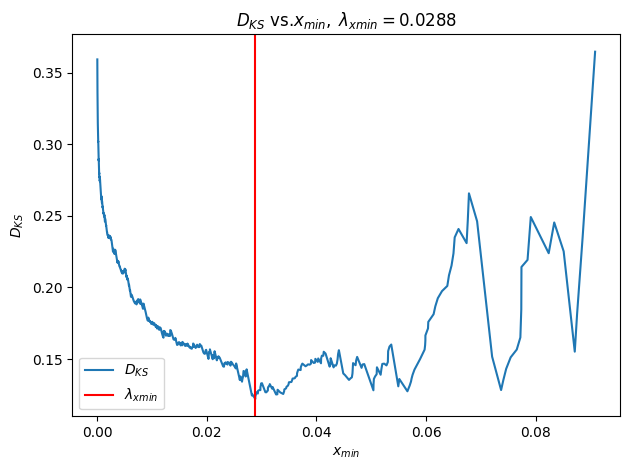

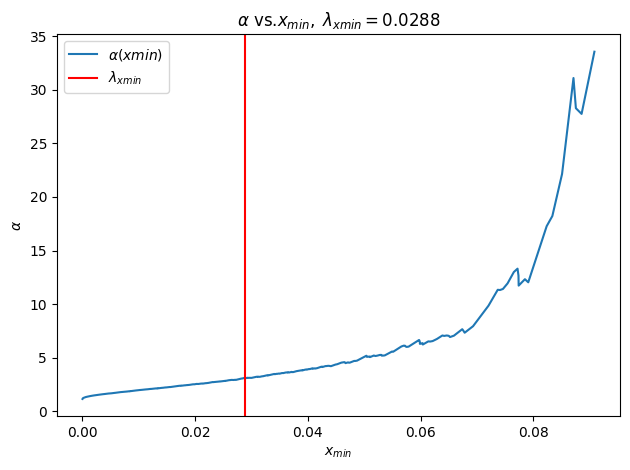

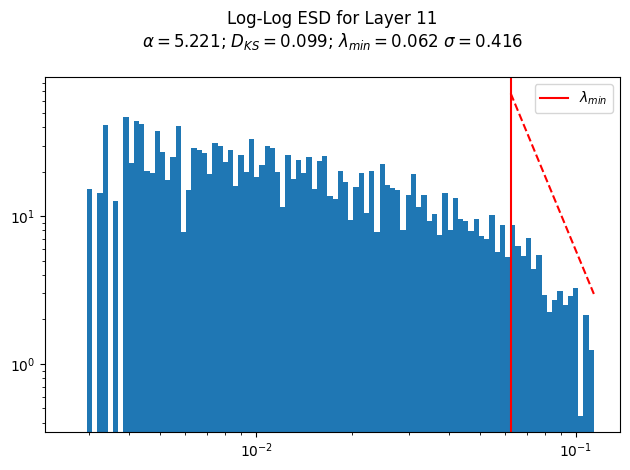

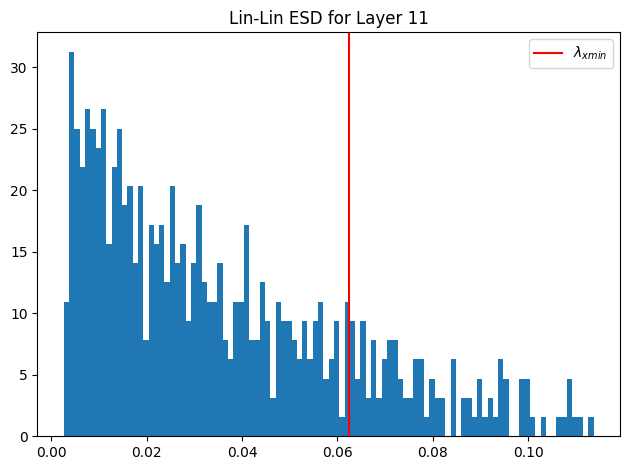

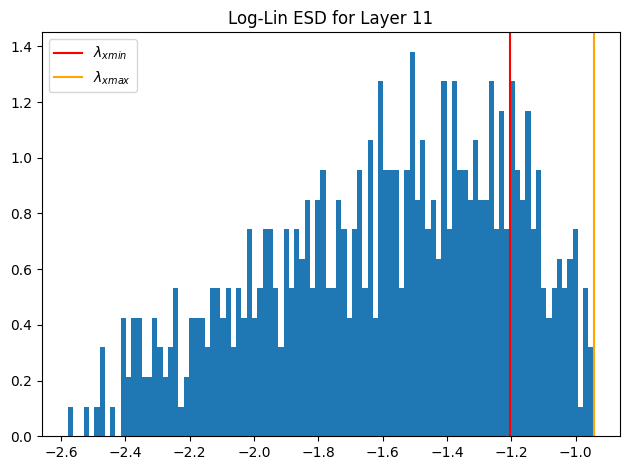

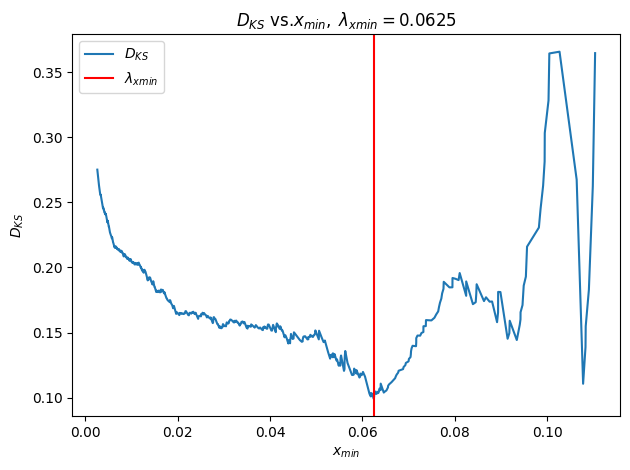

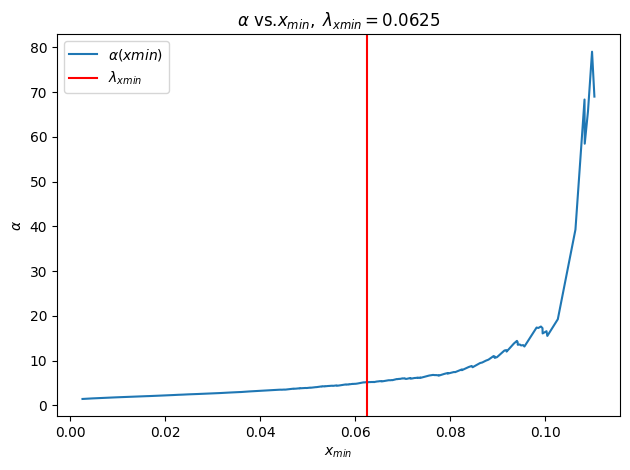

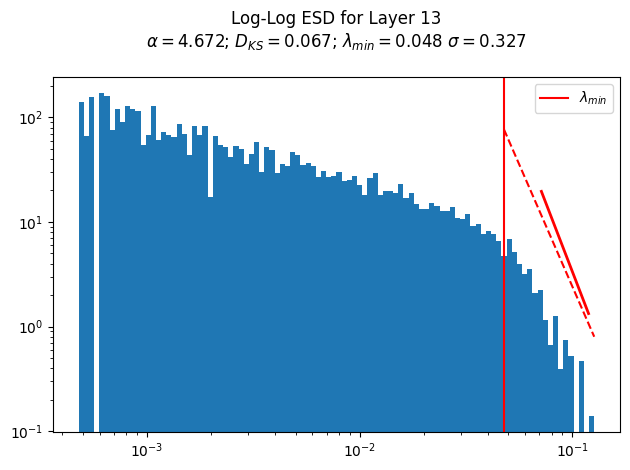

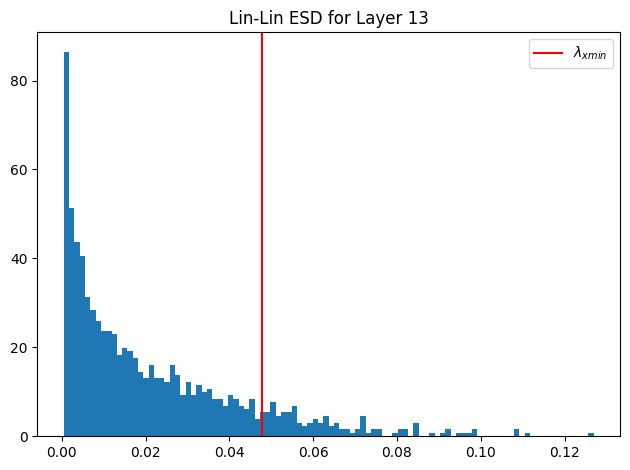

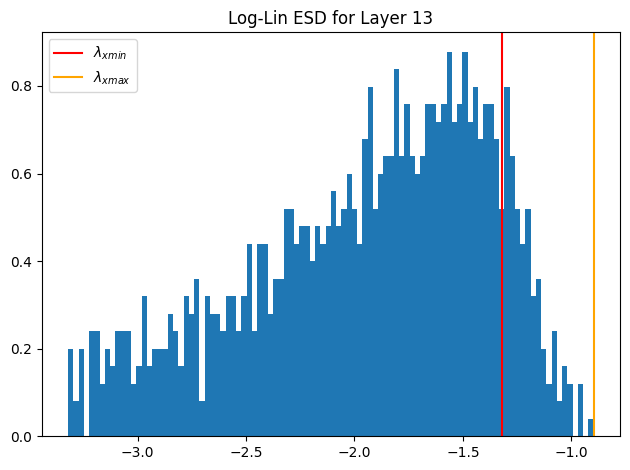

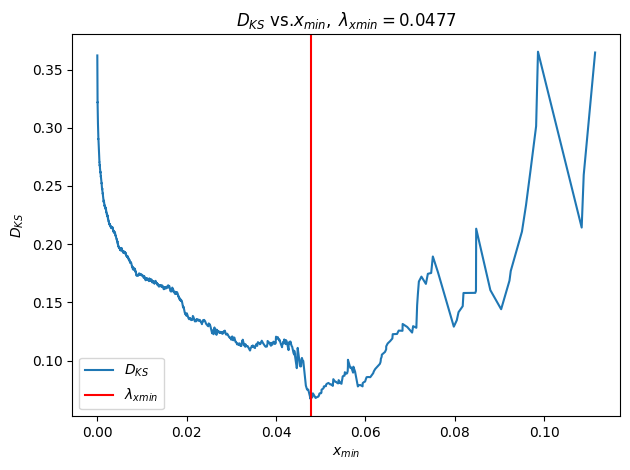

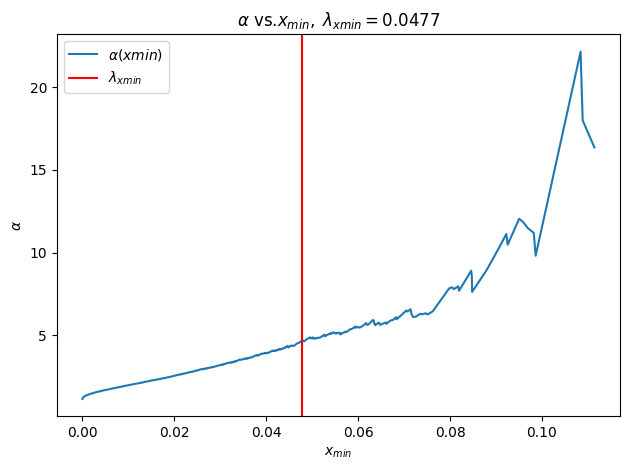

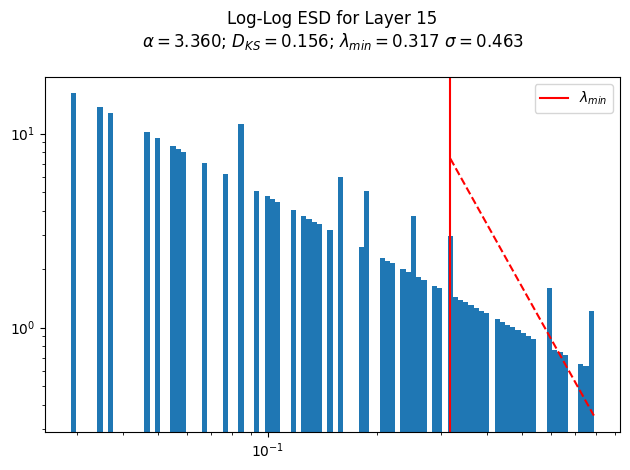

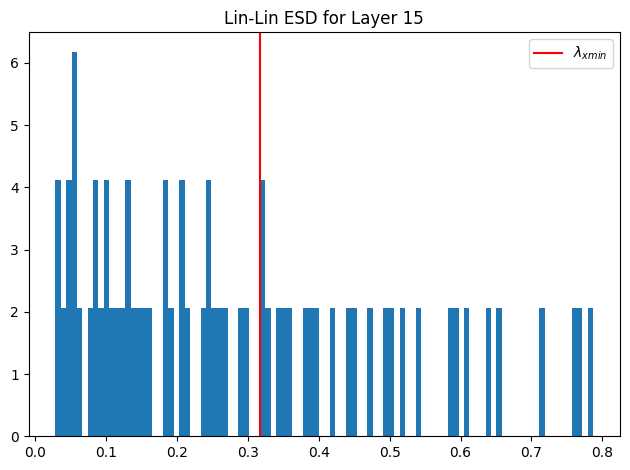

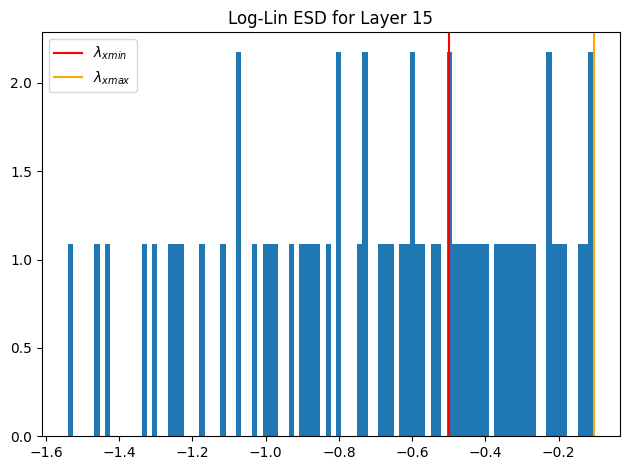

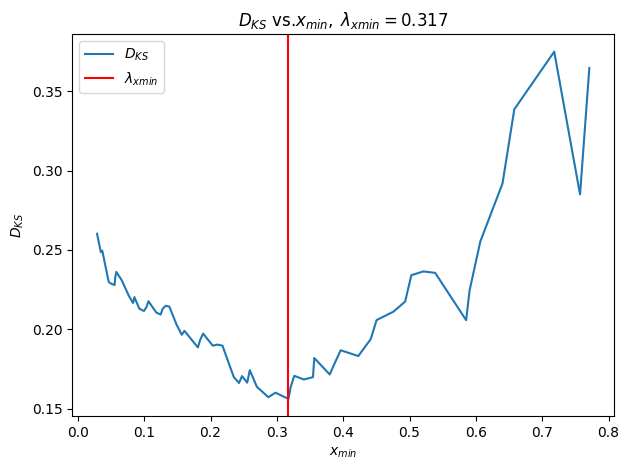

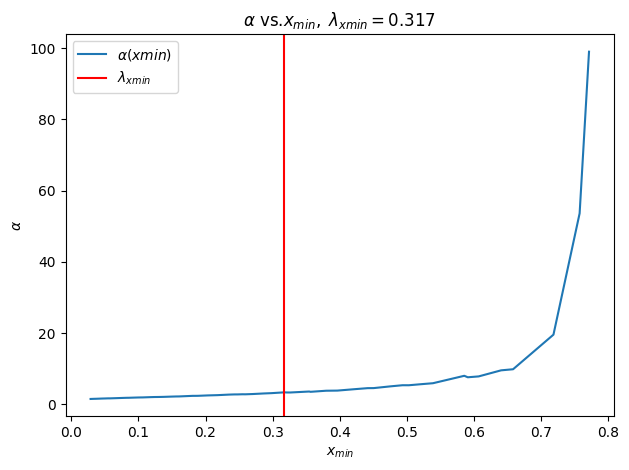

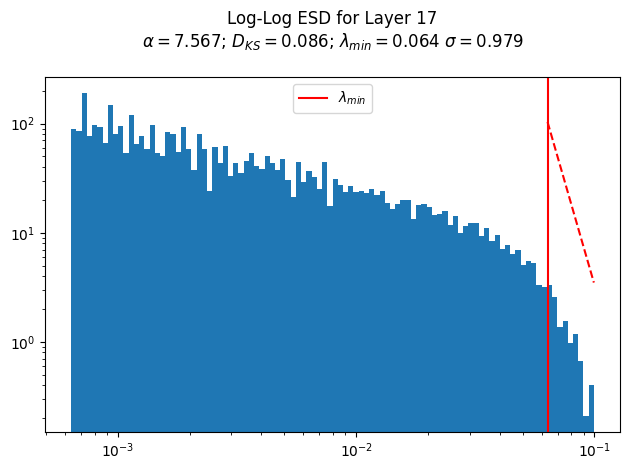

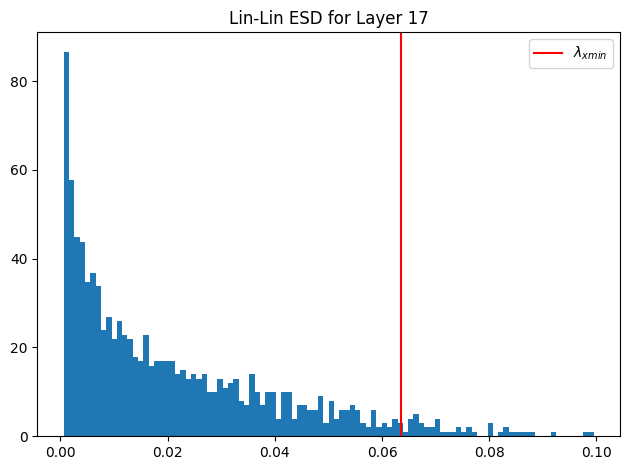

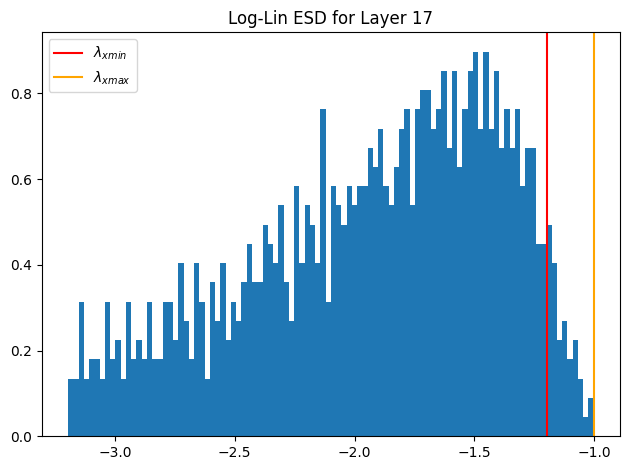

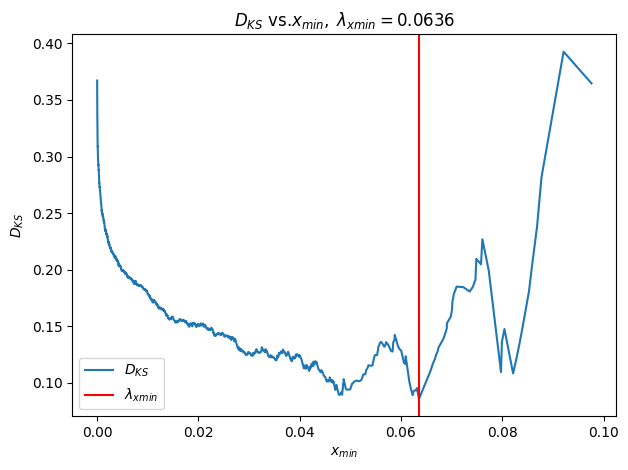

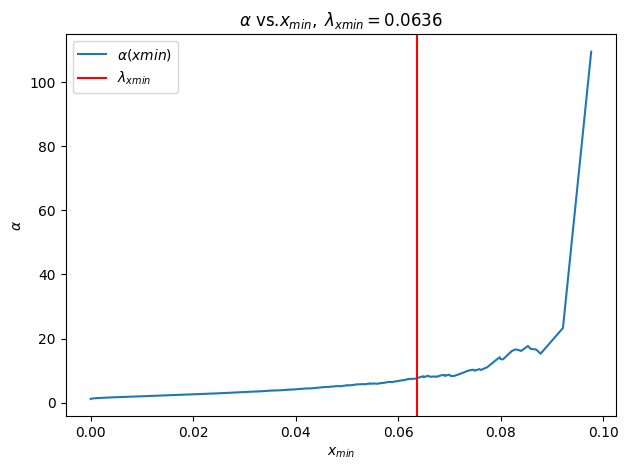

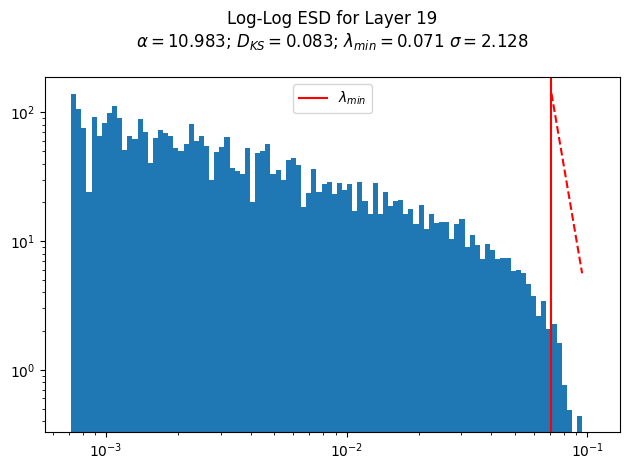

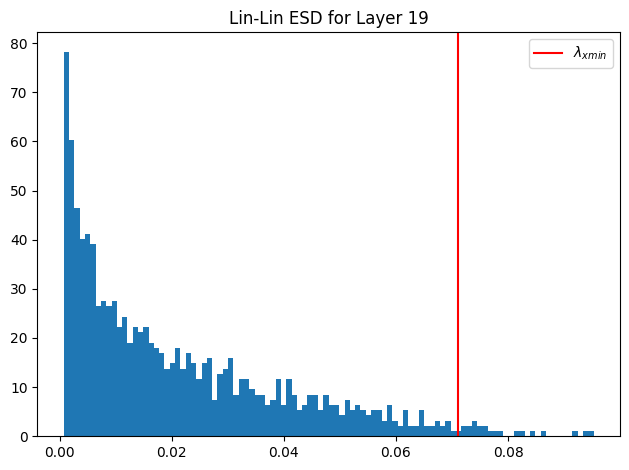

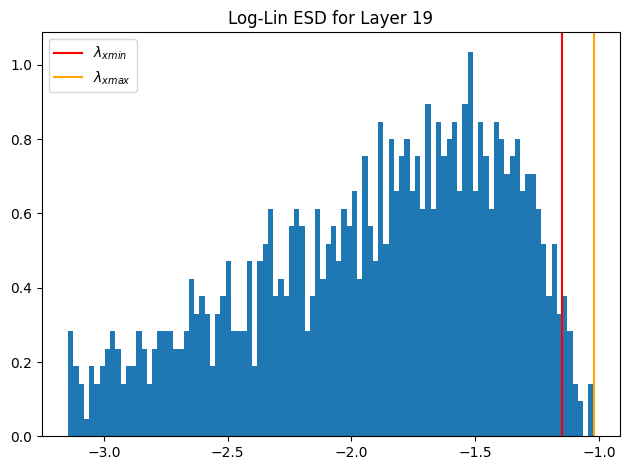

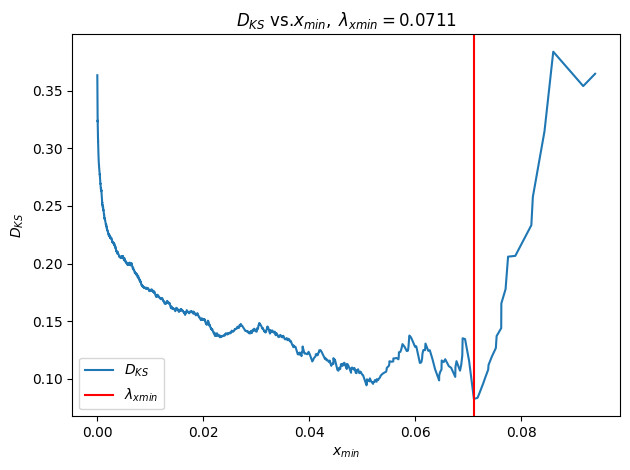

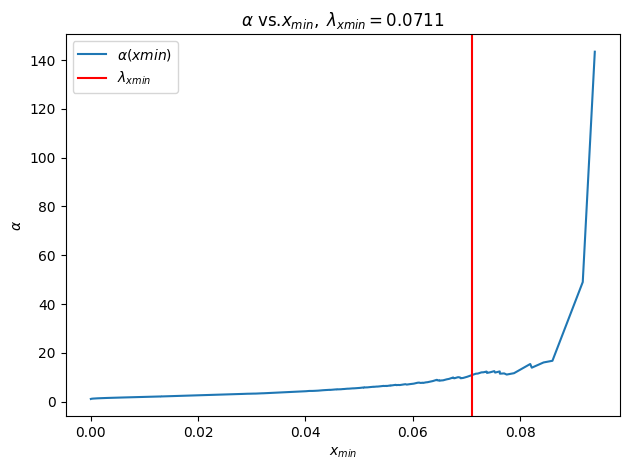

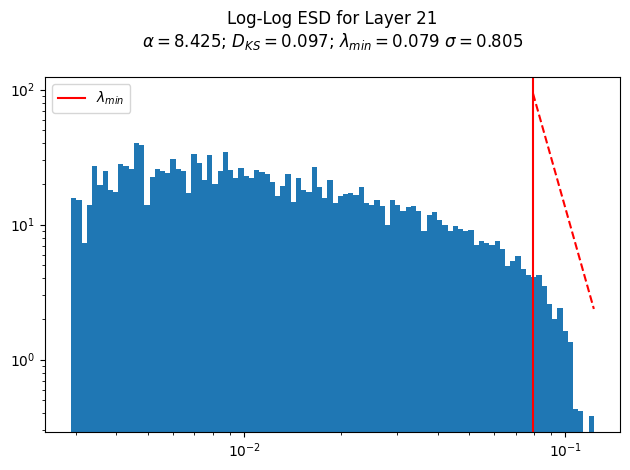

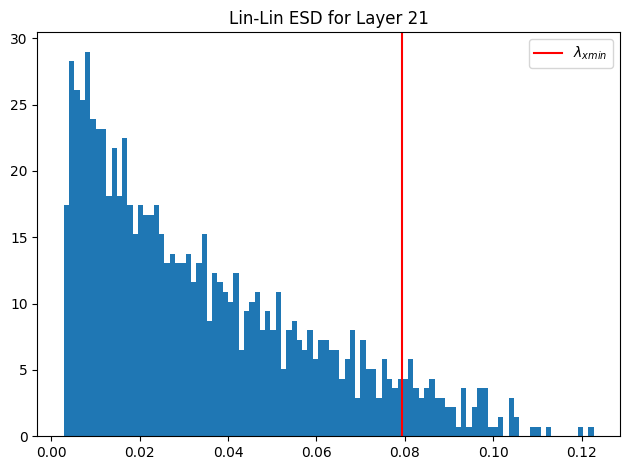

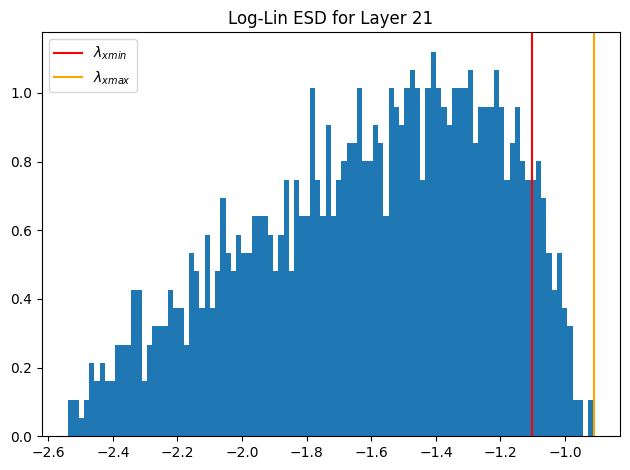

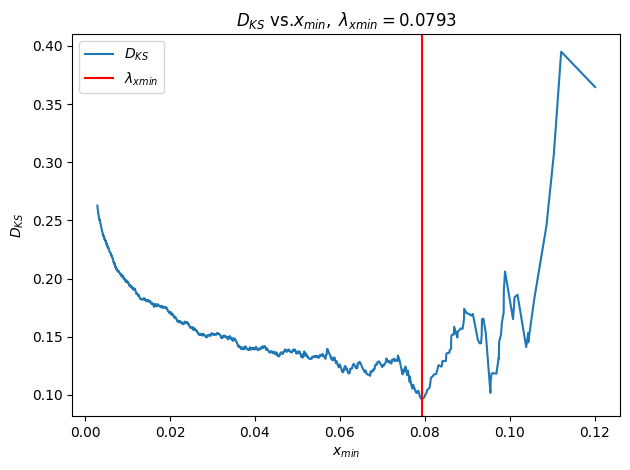

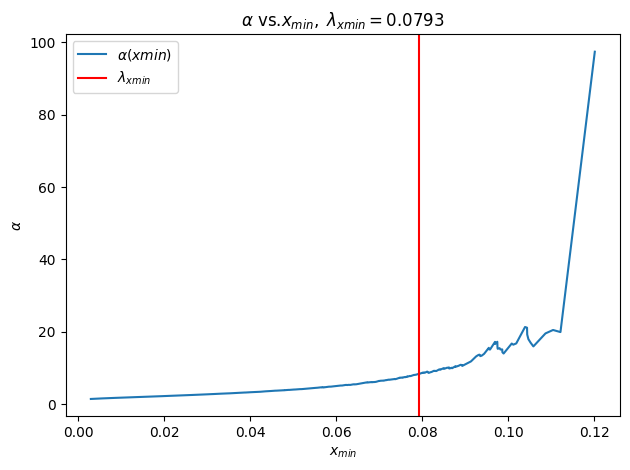

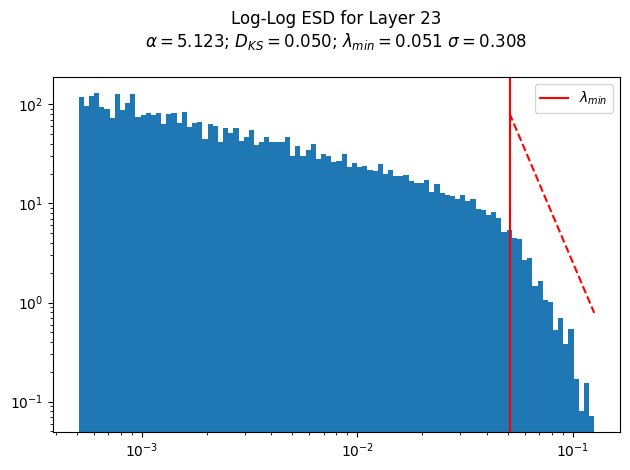

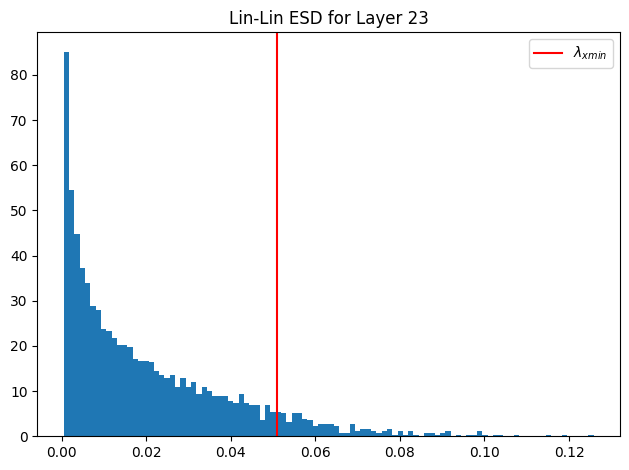

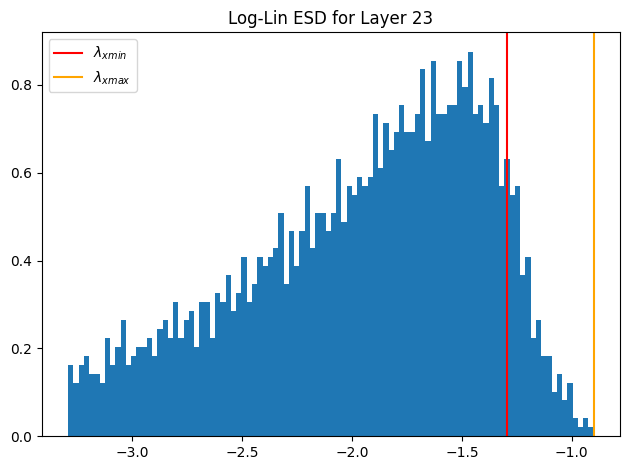

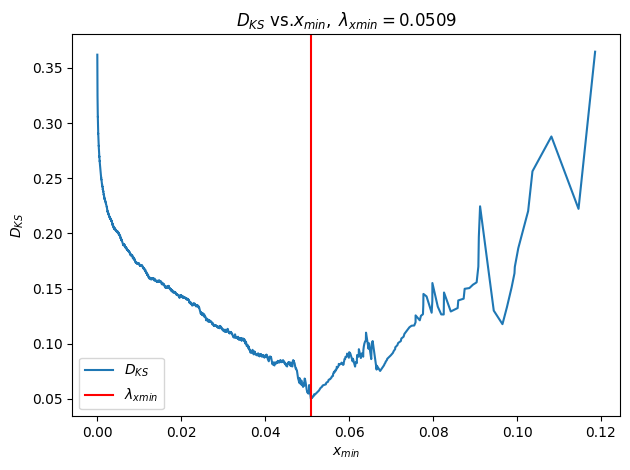

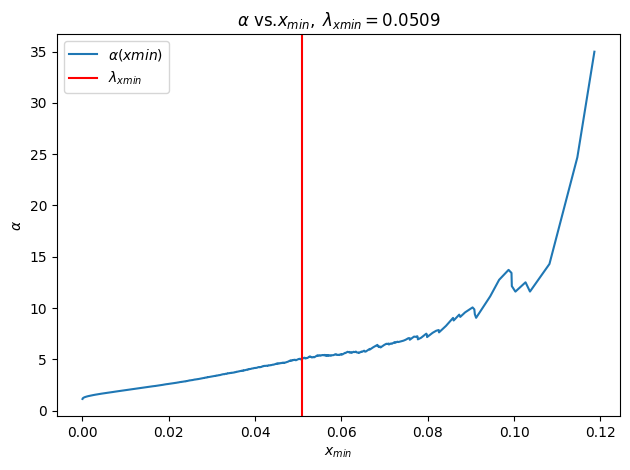

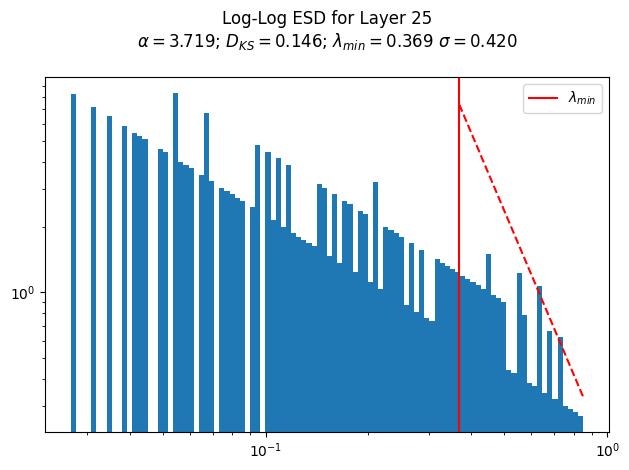

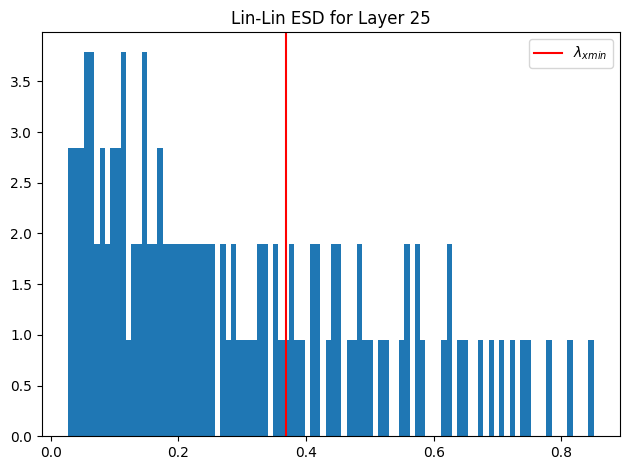

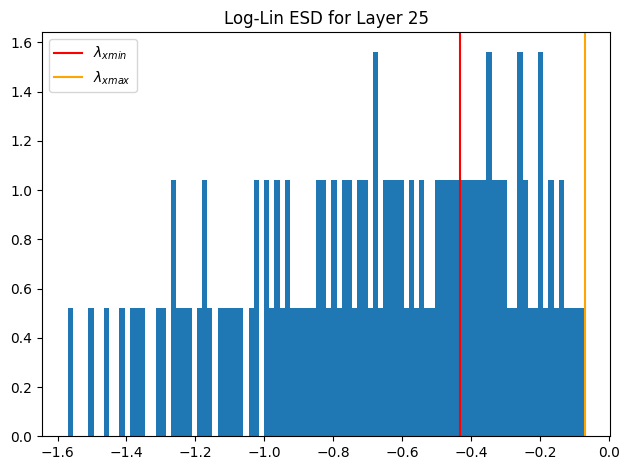

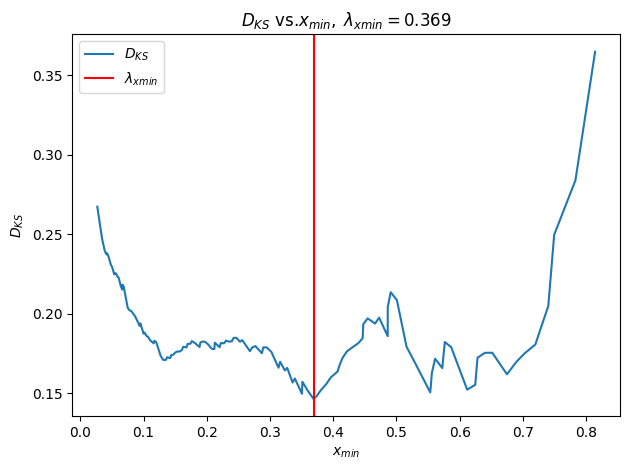

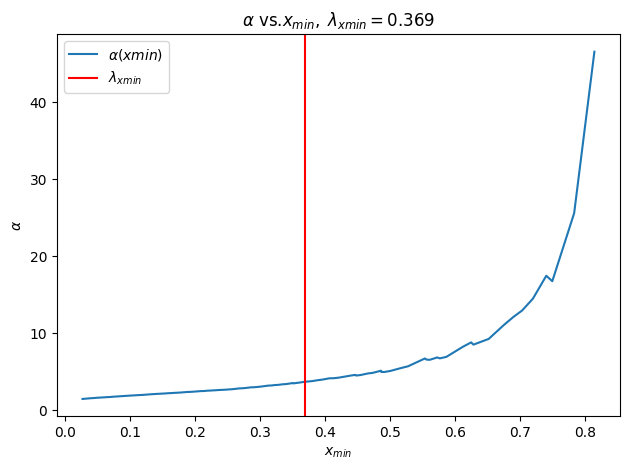

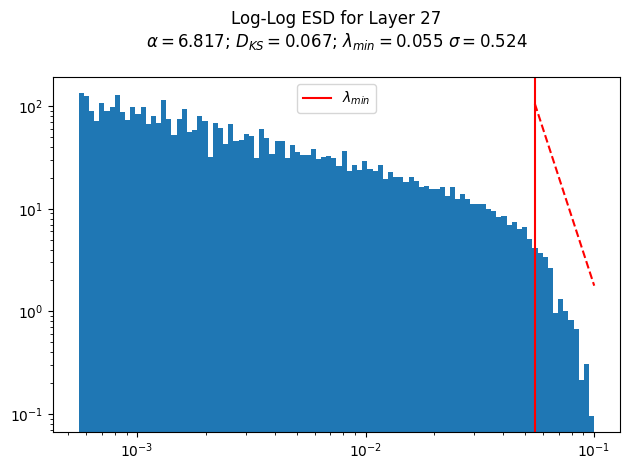

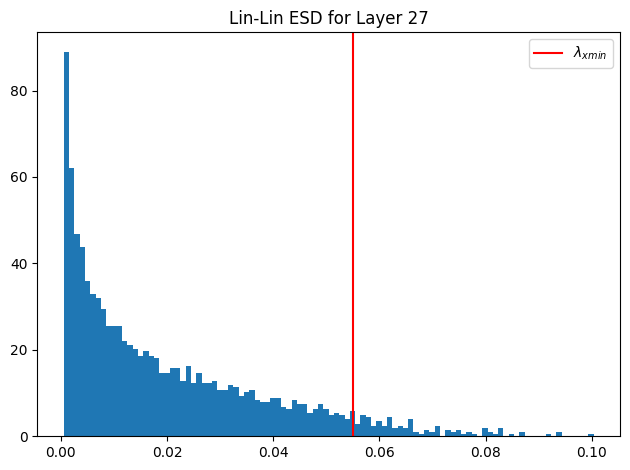

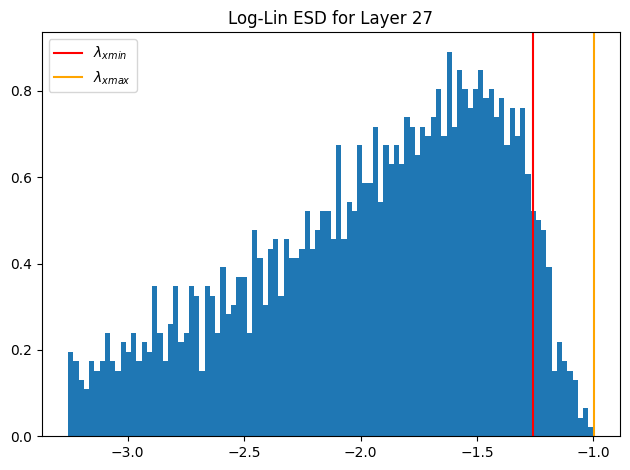

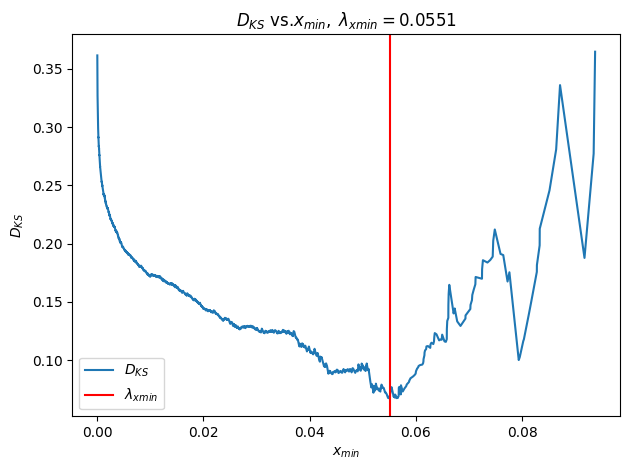

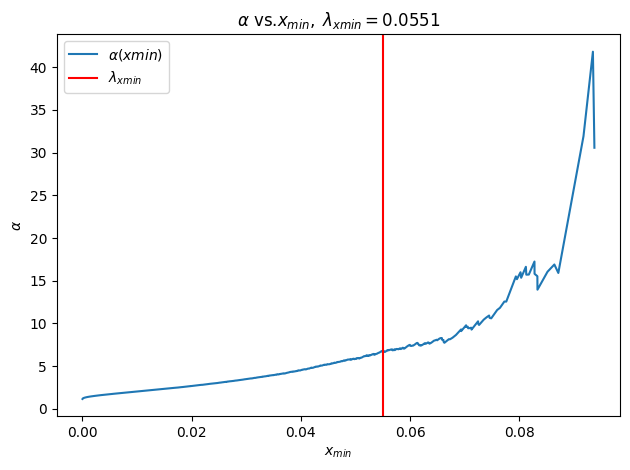

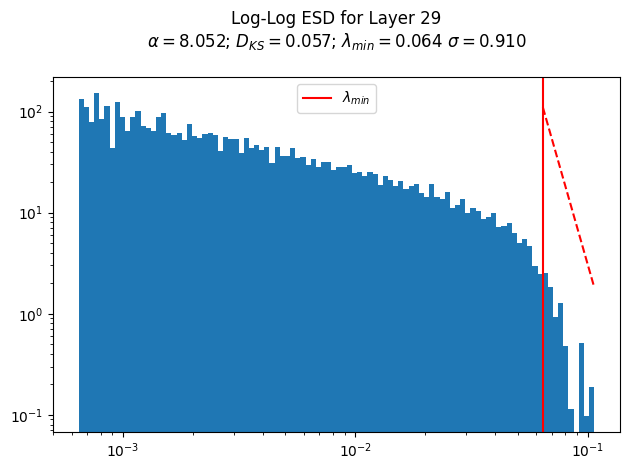

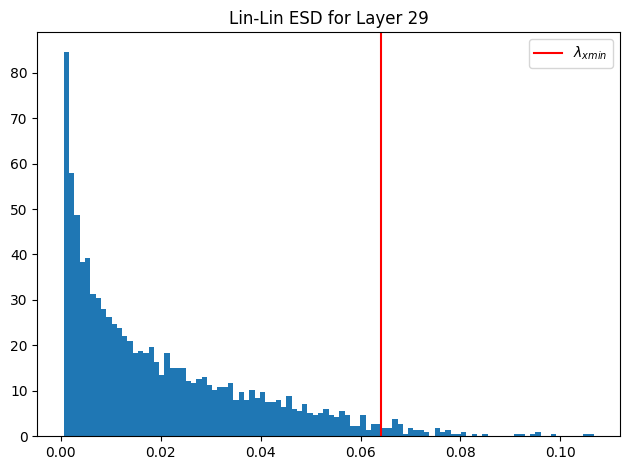

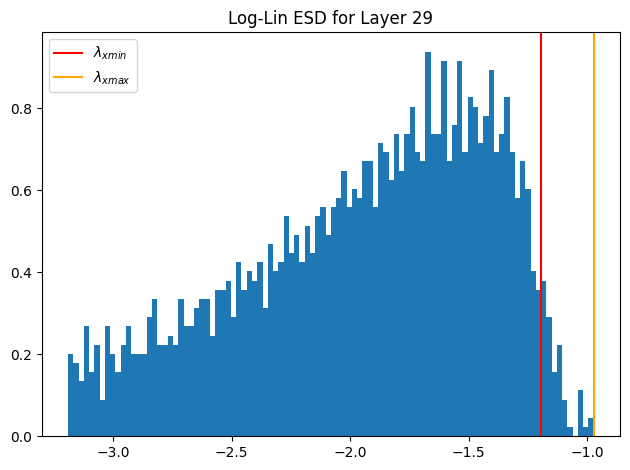

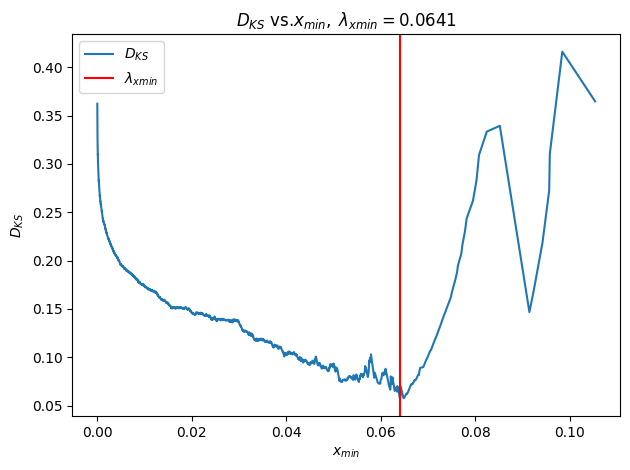

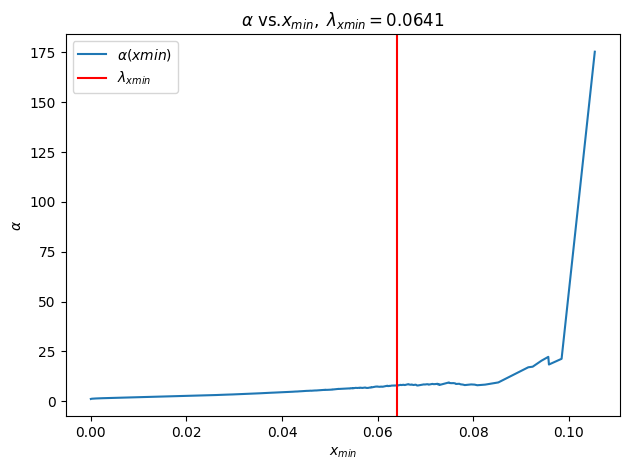

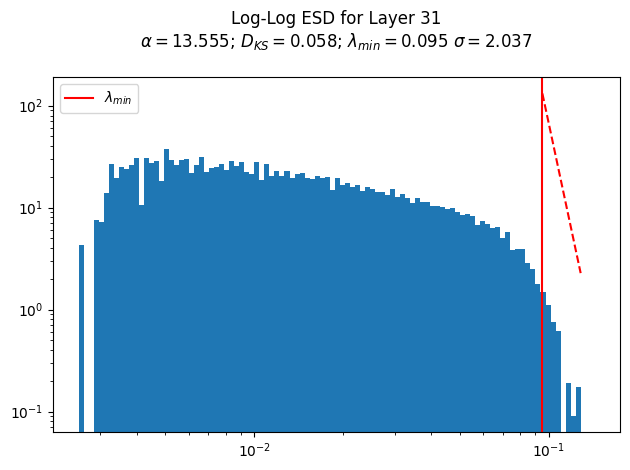

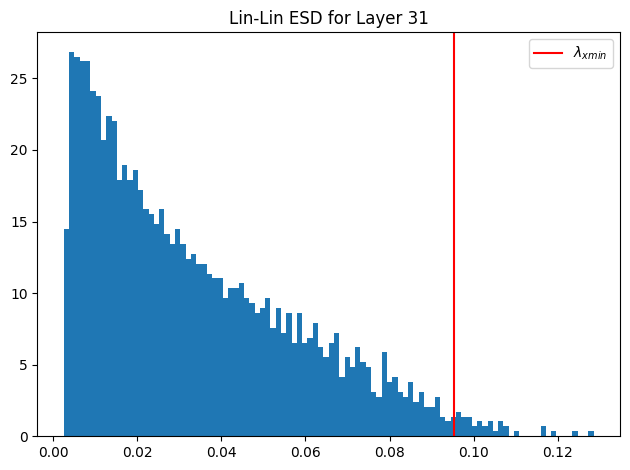

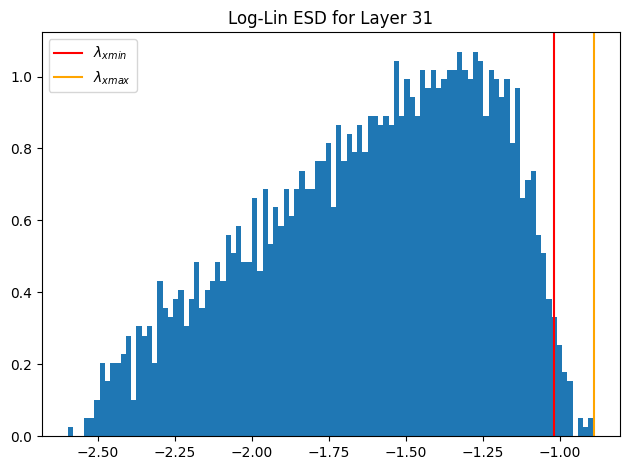

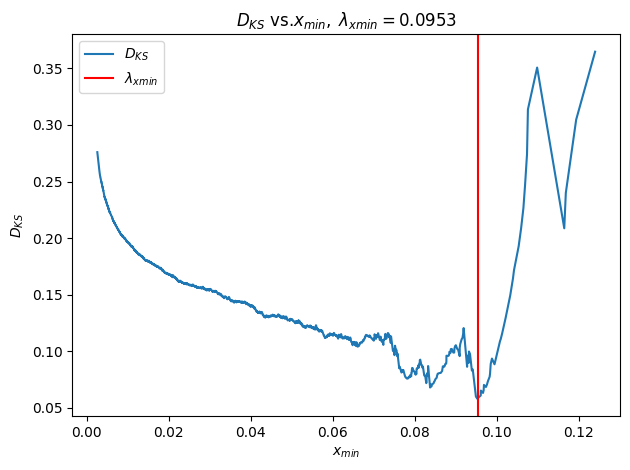

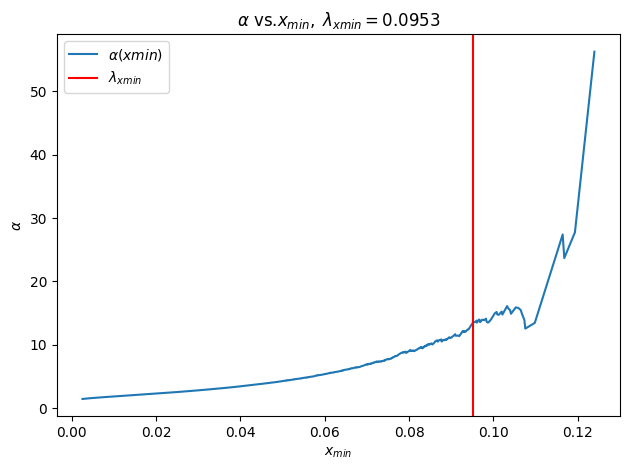

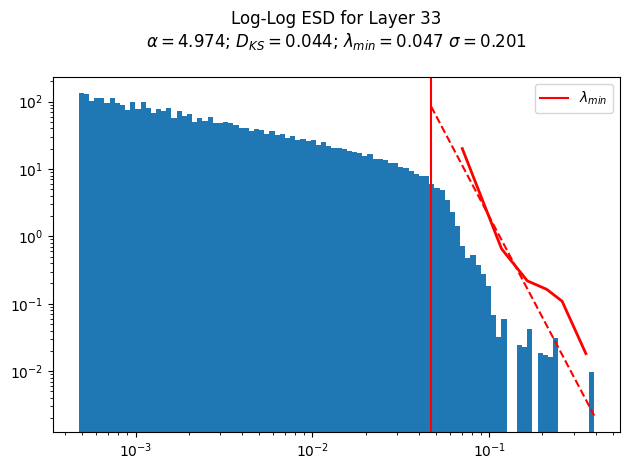

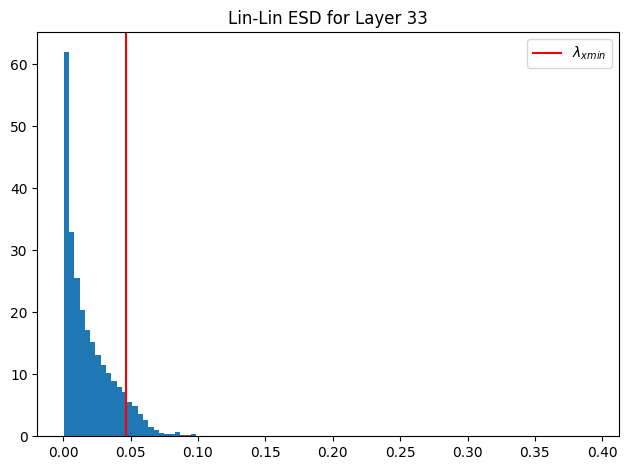

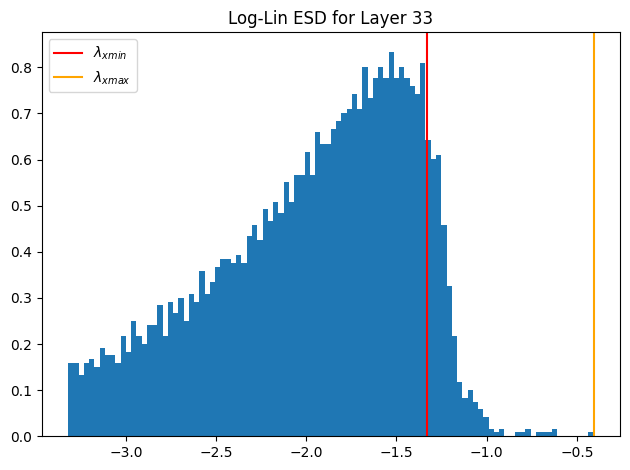

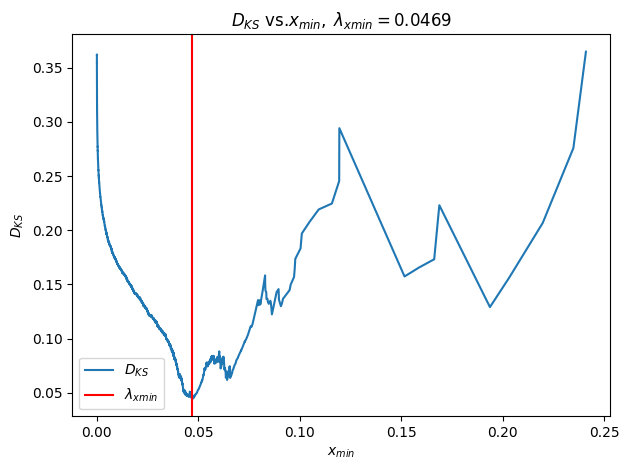

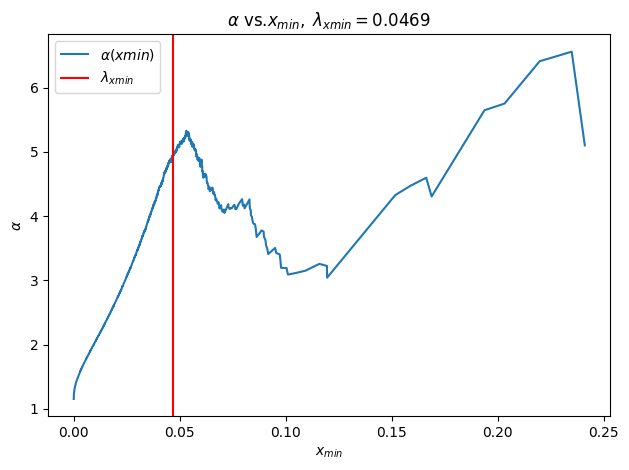

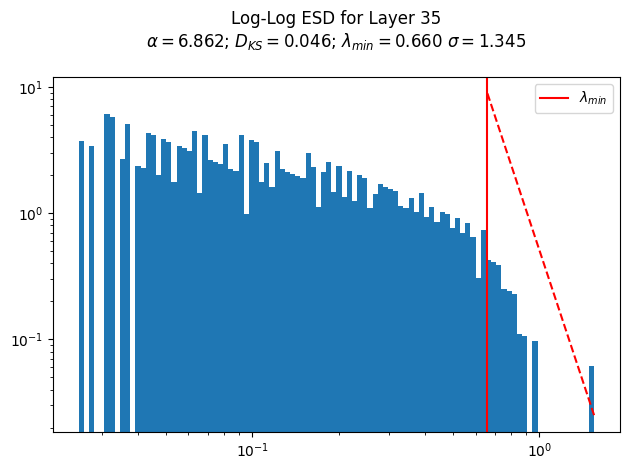

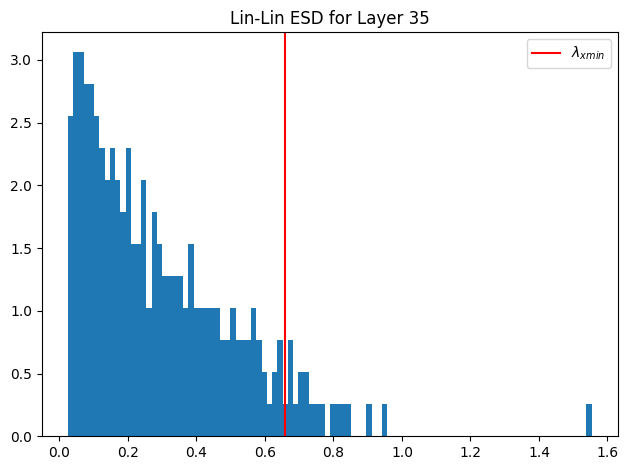

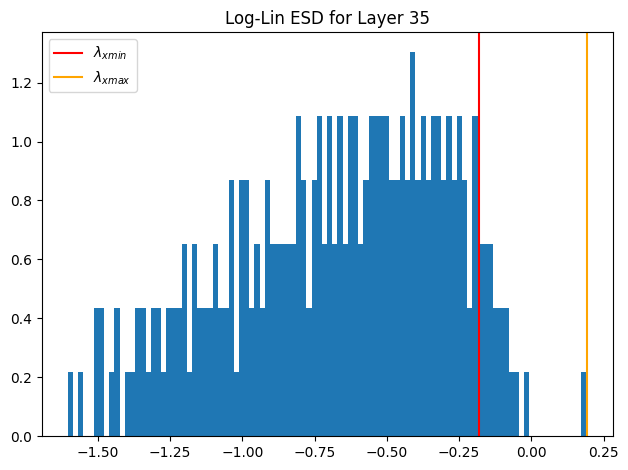

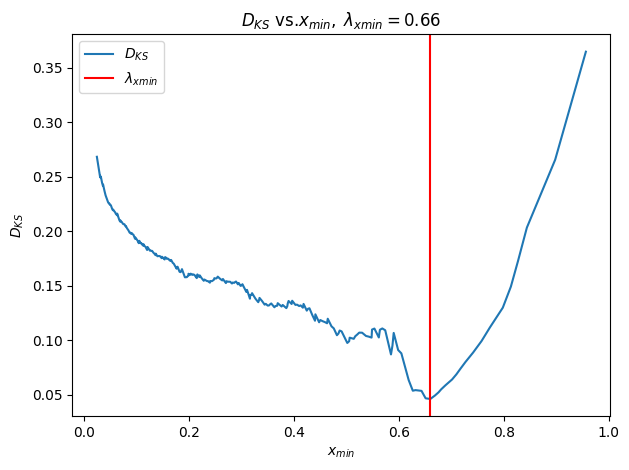

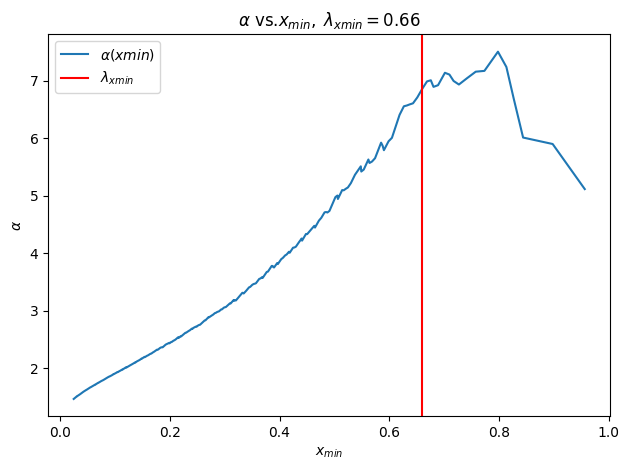

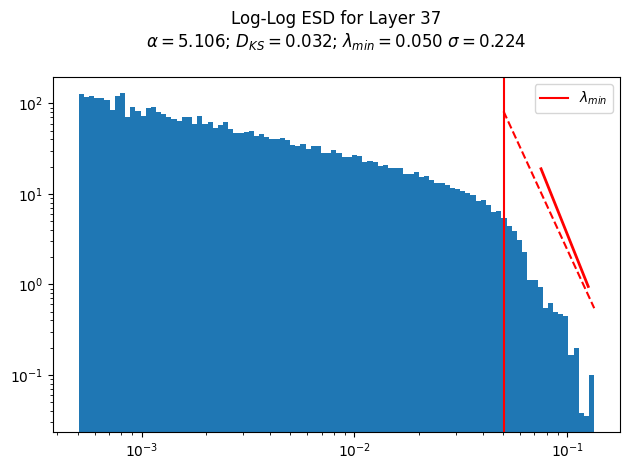

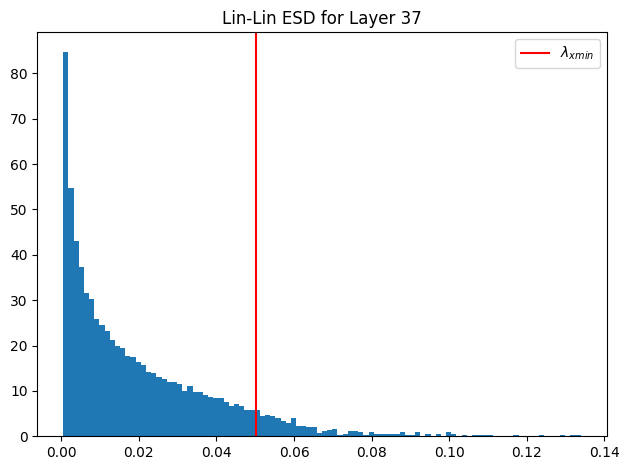

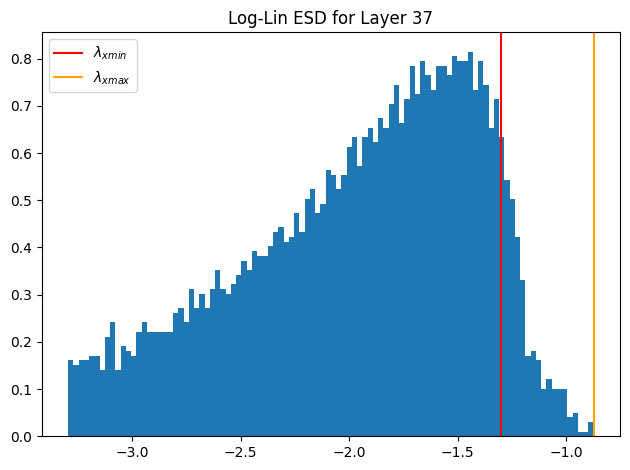

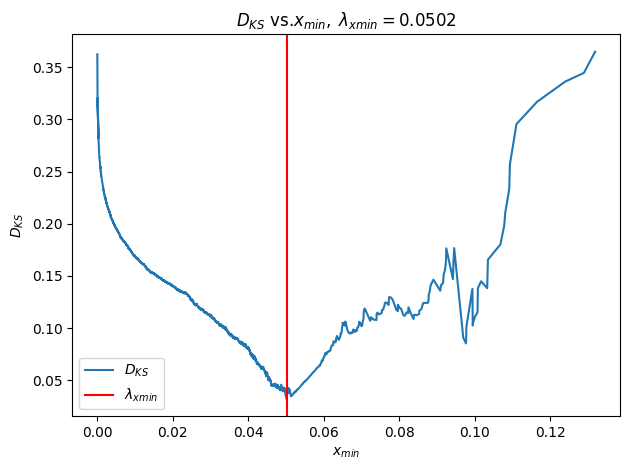

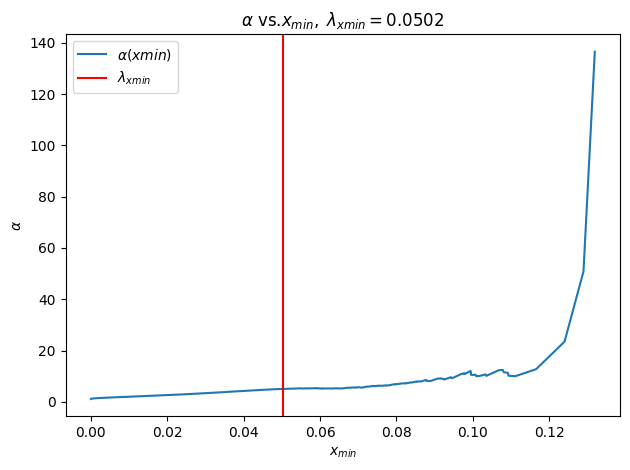

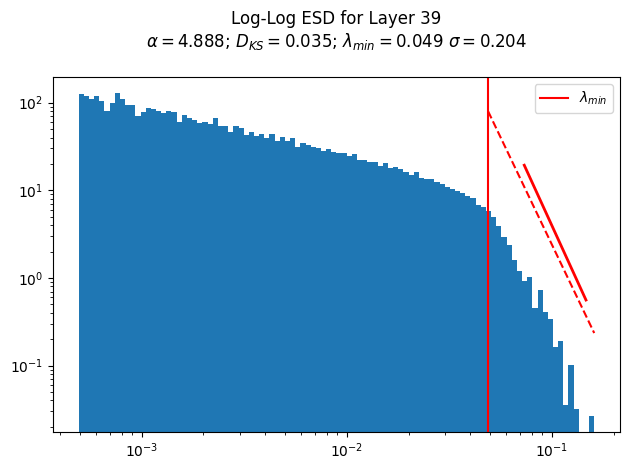

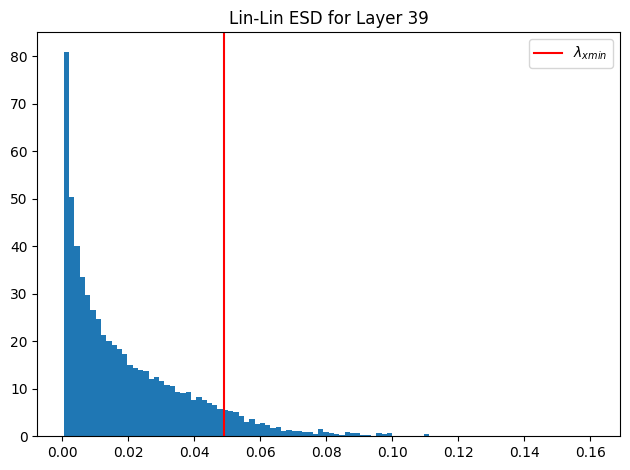

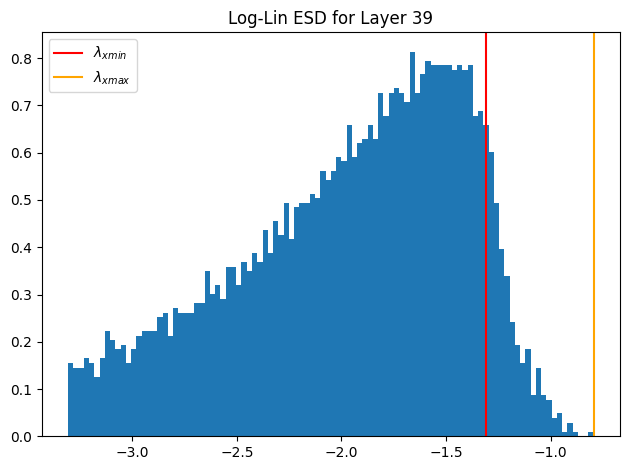

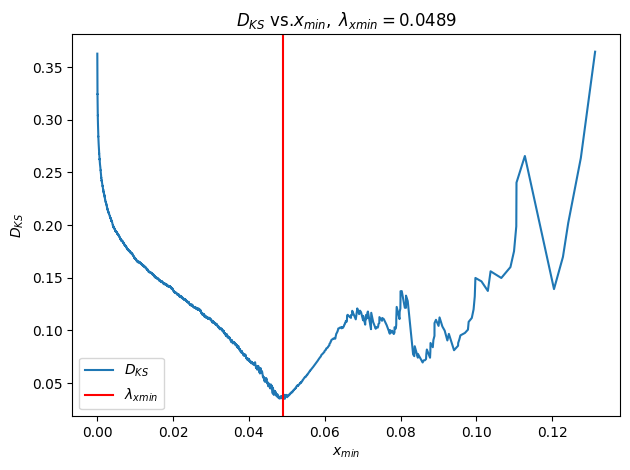

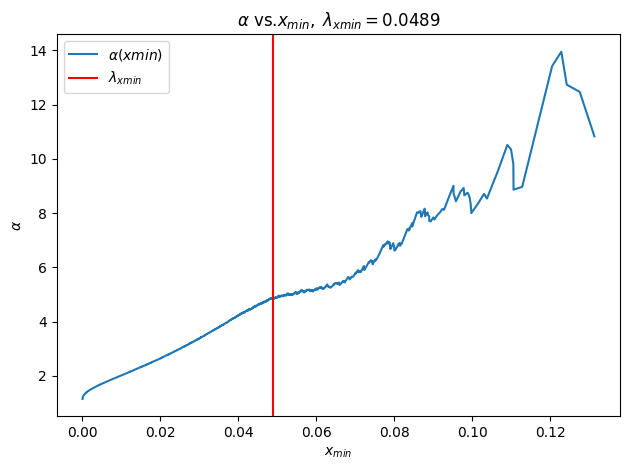

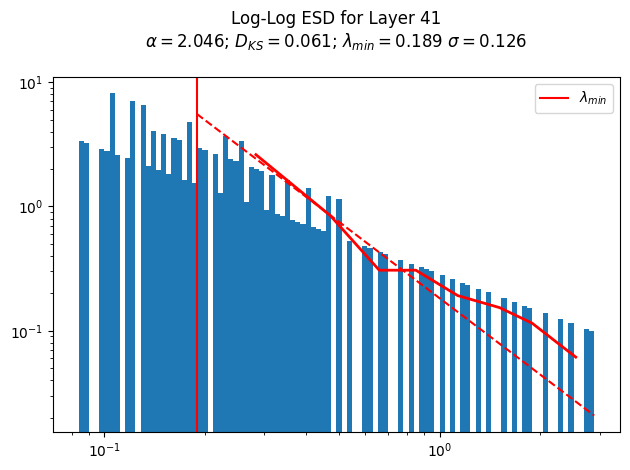

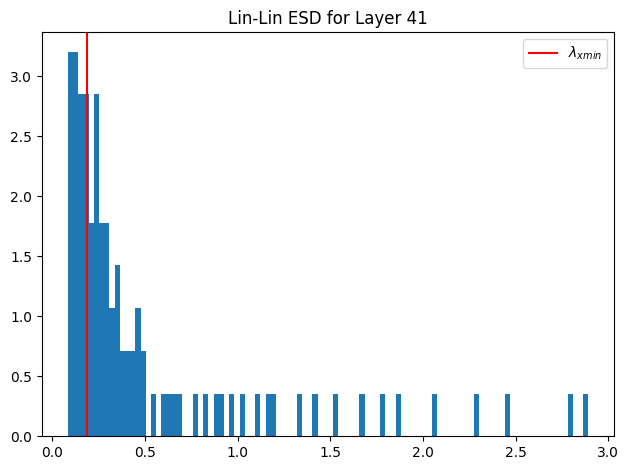

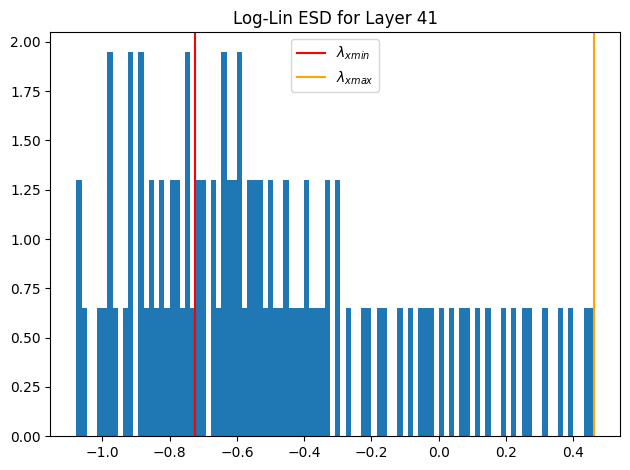

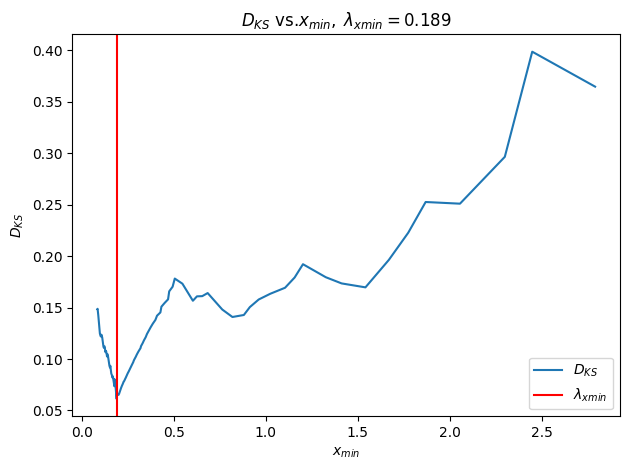

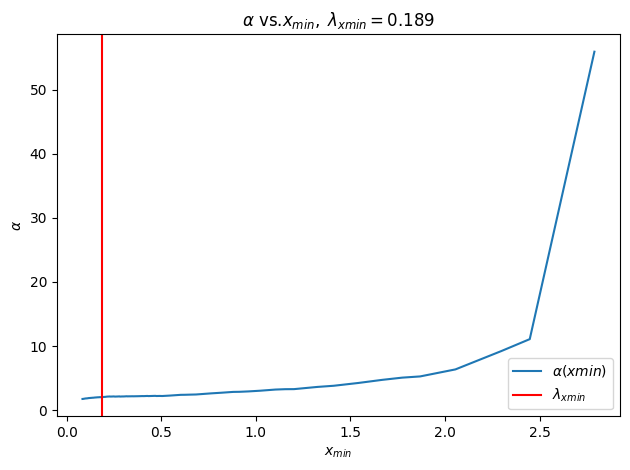

Generated 1 figure(s)
Saved plot 1 to /home/amar/Desktop/DeepFake1M/plots_epoch_2/plot_1.png
Saved all plots to /home/amar/Desktop/DeepFake1M/plots_epoch_2


In [4]:
import os
import torch
import weightwatcher as ww
import matplotlib.pyplot as plt

# Load checkpoint
model_path = "/home/amar/Desktop/DeepFake1M/checkpoints/epoch_2.pth"
checkpoint = torch.load(model_path, map_location=torch.device('cuda'))

# Extract only the model weights
state_dict = checkpoint['model_state_dict']

# Output folder for saving plots
output_dir = "/home/amar/Desktop/DeepFake1M/plots_epoch_2"
os.makedirs(output_dir, exist_ok=True)

# Run WeightWatcher
watcher = ww.WeightWatcher(model=state_dict)
details = watcher.analyze(plot=True)

# Check if any plots were generated
print(f"Generated {len(plt.get_fignums())} figure(s)")

# Save all generated plots
for idx, fig_num in enumerate(plt.get_fignums()):
    try:
        fig = plt.figure(fig_num)
        plot_path = os.path.join(output_dir, f"plot_{idx+1}.png")
        fig.savefig(plot_path)
        print(f"Saved plot {idx+1} to {plot_path}")
    except Exception as e:
        print(f"Error saving plot {idx+1}: {e}")

# Close all to free memory
plt.close('all')

print(f"Saved all plots to {output_dir}")


In [6]:
print(details['alpha'])

0     10.900631
1      3.666340
2      4.799301
3      3.771708
4      3.124826
5      5.221467
6      4.672348
7      3.359977
8      7.567098
9     10.982582
10     8.424571
11     5.122733
12     3.719399
13     6.816784
14     8.051830
15    13.555084
16     4.974246
17     6.862152
18     5.106105
19     4.888255
20     2.046240
Name: alpha, dtype: float64
